In [1]:
import gym
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input

In [2]:
class Buffer:
    def __init__(self, state_shape):
        self.MEMORY_SIZE = 1000000
        self.state_memory = np.zeros((self.MEMORY_SIZE, *state_shape),np.float32)
        self.new_state_memory = np.zeros((self.MEMORY_SIZE, *state_shape),np.float32)
        self.reward_memory = np.zeros((self.MEMORY_SIZE),np.float32)
        self.done_memory = np.zeros((self.MEMORY_SIZE),np.int32)
        self.action_memory = np.zeros((self.MEMORY_SIZE), np.int32)
        self.memory_counter = 0
    
    def store_transition(self, state, action, reward, done, new_state):
        i = self.memory_counter % self.MEMORY_SIZE
        self.state_memory[i] = state
        self.action_memory[i] = action
        self.reward_memory[i] = reward
        self.done_memory[i] = done
        self.new_state_memory[i] = new_state
        self.memory_counter += 1
        
    def sample_buffer(self, buffer_size):
        min_size = min(self.MEMORY_SIZE,self.memory_counter)
        batch = np.random.choice(min_size, buffer_size, replace=False)
        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        dones = self.done_memory[batch]
        new_states = self.new_state_memory[batch]
        return (states, actions, rewards, dones, new_states)


In [3]:
def build_model(input_shape, output_shape, lr):
    model = Sequential()

    model.add(Input(input_shape))

    model.add(Dense(256, activation='relu'))

    model.add(Dense(256, activation='relu'))

    model.add(Dense(output_shape, activation='linear'))

    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')

    return model


In [9]:
import os
class Agent:
    def __init__(self, input_shape, n_actions, gamma = 0.99, lr = 0.0001, batch_size = 64, 
                 epsilon = 1, epsilon_min= 0.01,epsilon_decay = 0.991, fname = "lunar_lander_model.h5"):
        self.lr = lr
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.memory = Buffer(input_shape)
        self.fname = fname
        self.update_target = 0
        if os.path.exists(self.fname):
            self.model = self.__load_model__()
        else:
            self.model = build_model(input_shape, n_actions,lr)
            
        self.model_target = build_model(input_shape, n_actions,lr)
        self.model_target.set_weights(self.model.get_weights())
        
    def store_transition(self, state, action, reward, done, new_state):
        self.memory.store_transition(state, action, reward, done, new_state)
        
    def action(self, state):
        if self.epsilon > np.random.random():
            return np.random.randint(self.n_actions)
        return np.argmax(self.model.predict(np.array([state])))
    
    def learn(self, terminal_state):
        if self.memory.memory_counter < self.batch_size:
            return
        (states, actions, rewards, dones, new_states) = self.memory.sample_buffer(self.batch_size)
        
        current_q_list = self.model.predict(states)
        futur_q_list = self.model_target.predict(new_states)
        
        q_list = np.copy(current_q_list)
        
        batch_index = np.arange(self.batch_size, dtype=np.int32)

        q_list[batch_index, actions] = rewards + self.gamma * np.max(futur_q_list, axis=1)*(1 - dones)

        self.model.train_on_batch(states, q_list)
        
        if terminal_state:
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            self.update_target += 1
        if self.update_target == 5:
            self.model_target.set_weights(self.model.get_weights())
            self.__save_model__()
            self.update_target = 0
    def __save_model__(self):
        self.model.save(self.fname)
    def __load_model__(self):
        return tf.keras.models.load_model(self.fname)

In [5]:
env = gym.make('LunarLander-v2')

In [6]:
input_shape = env.observation_space.shape
n_actions = env.action_space.n
print(input_shape, n_actions)

(8,) 4


In [10]:
tf.compat.v1.disable_eager_execution()
agent = Agent(input_shape, n_actions)

In [11]:
n_games = 2000
scores= []
epsilon_his = []
for i in tqdm(range(n_games), ascii = True, unit="episode"):
    state = env.reset()
    score = 0
    while True:
        action = agent.action(state)
        new_state, reward, done, _ = env.step(action)
        agent.store_transition(state, action, reward, done, new_state)
        agent.learn(done)
        score += reward
        state = new_state
        if done:
            break
    scores.append(score)
    epsilon_his.append(agent.epsilon)
    avg_score = np.mean(scores[-25:])
    print('episode: ', i, 'score %.2f' % score,
            'average_score %.2f' % avg_score,
            'epsilon %.2f' % agent.epsilon)


  0%|          | 0/2000 [00:00<?, ?episode/s]

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.



  0%|          | 1/2000 [00:00<21:54,  1.52episode/s]

episode:  0 score -127.52 average_score -127.52 epsilon 0.99



  0%|          | 2/2000 [00:02<31:38,  1.05episode/s]

episode:  1 score -254.97 average_score -191.24 epsilon 0.98



  0%|          | 3/2000 [00:03<32:56,  1.01episode/s]

episode:  2 score -99.14 average_score -160.54 epsilon 0.97



  0%|          | 4/2000 [00:04<31:57,  1.04episode/s]

episode:  3 score -128.24 average_score -152.47 epsilon 0.96



  0%|          | 5/2000 [00:05<34:17,  1.03s/episode]

episode:  4 score -76.18 average_score -137.21 epsilon 0.96



  0%|          | 6/2000 [00:06<33:27,  1.01s/episode]

episode:  5 score -122.81 average_score -134.81 epsilon 0.95



  0%|          | 7/2000 [00:07<36:56,  1.11s/episode]

episode:  6 score -147.82 average_score -136.67 epsilon 0.94



  0%|          | 8/2000 [00:09<41:38,  1.25s/episode]

episode:  7 score -525.67 average_score -185.29 epsilon 0.93



  0%|          | 9/2000 [00:11<46:18,  1.40s/episode]

episode:  8 score -112.97 average_score -177.26 epsilon 0.92



  0%|          | 10/2000 [00:12<47:27,  1.43s/episode]

episode:  9 score -86.38 average_score -168.17 epsilon 0.91



  1%|          | 11/2000 [00:13<43:13,  1.30s/episode]

episode:  10 score -115.26 average_score -163.36 epsilon 0.91



  1%|          | 12/2000 [00:15<44:38,  1.35s/episode]

episode:  11 score -140.54 average_score -161.46 epsilon 0.90



  1%|          | 13/2000 [00:16<44:43,  1.35s/episode]

episode:  12 score -106.10 average_score -157.20 epsilon 0.89



  1%|          | 14/2000 [00:17<45:53,  1.39s/episode]

episode:  13 score -128.93 average_score -155.18 epsilon 0.88



  1%|          | 15/2000 [00:19<43:32,  1.32s/episode]

episode:  14 score -102.82 average_score -151.69 epsilon 0.87



  1%|          | 16/2000 [00:20<46:14,  1.40s/episode]

episode:  15 score -102.22 average_score -148.60 epsilon 0.87



  1%|          | 17/2000 [00:22<46:16,  1.40s/episode]

episode:  16 score -142.65 average_score -148.25 epsilon 0.86



  1%|          | 18/2000 [00:23<49:00,  1.48s/episode]

episode:  17 score -167.12 average_score -149.30 epsilon 0.85



  1%|          | 19/2000 [00:25<54:29,  1.65s/episode]

episode:  18 score -44.83 average_score -143.80 epsilon 0.84



  1%|1         | 20/2000 [00:26<50:12,  1.52s/episode]

episode:  19 score -85.44 average_score -140.88 epsilon 0.83



  1%|1         | 21/2000 [00:29<57:32,  1.74s/episode]

episode:  20 score -195.53 average_score -143.48 epsilon 0.83



  1%|1         | 22/2000 [00:30<57:16,  1.74s/episode]

episode:  21 score -131.78 average_score -142.95 epsilon 0.82



  1%|1         | 23/2000 [00:33<1:00:21,  1.83s/episode]

episode:  22 score -106.21 average_score -141.35 epsilon 0.81



  1%|1         | 24/2000 [00:34<54:45,  1.66s/episode]  

episode:  23 score -85.51 average_score -139.03 epsilon 0.80



  1%|1         | 25/2000 [00:35<51:42,  1.57s/episode]

episode:  24 score -88.81 average_score -137.02 epsilon 0.80



  1%|1         | 26/2000 [00:37<52:05,  1.58s/episode]

episode:  25 score -74.51 average_score -134.90 epsilon 0.79



  1%|1         | 27/2000 [00:38<50:45,  1.54s/episode]

episode:  26 score -60.93 average_score -127.14 epsilon 0.78



  1%|1         | 28/2000 [00:40<52:50,  1.61s/episode]

episode:  27 score -50.30 average_score -125.18 epsilon 0.78



  1%|1         | 29/2000 [00:41<48:49,  1.49s/episode]

episode:  28 score -19.13 average_score -120.82 epsilon 0.77



  2%|1         | 30/2000 [00:42<45:38,  1.39s/episode]

episode:  29 score -17.07 average_score -118.45 epsilon 0.76



  2%|1         | 31/2000 [00:44<49:20,  1.50s/episode]

episode:  30 score -181.10 average_score -120.79 epsilon 0.76



  2%|1         | 32/2000 [00:46<55:30,  1.69s/episode]

episode:  31 score -30.17 average_score -116.08 epsilon 0.75



  2%|1         | 33/2000 [00:48<56:29,  1.72s/episode]

episode:  32 score -66.88 average_score -97.73 epsilon 0.74



  2%|1         | 34/2000 [00:49<52:47,  1.61s/episode]

episode:  33 score -46.72 average_score -95.08 epsilon 0.74



  2%|1         | 35/2000 [00:51<50:46,  1.55s/episode]

episode:  34 score -44.81 average_score -93.41 epsilon 0.73



  2%|1         | 36/2000 [00:52<48:22,  1.48s/episode]

episode:  35 score -13.28 average_score -89.34 epsilon 0.72



  2%|1         | 37/2000 [00:54<52:52,  1.62s/episode]

episode:  36 score -61.92 average_score -86.19 epsilon 0.72



  2%|1         | 38/2000 [00:55<46:59,  1.44s/episode]

episode:  37 score -79.01 average_score -85.11 epsilon 0.71



  2%|1         | 39/2000 [00:57<47:28,  1.45s/episode]

episode:  38 score -77.19 average_score -83.04 epsilon 0.70



  2%|2         | 40/2000 [00:59<54:47,  1.68s/episode]

episode:  39 score -18.52 average_score -79.67 epsilon 0.70



  2%|2         | 41/2000 [01:00<50:56,  1.56s/episode]

episode:  40 score 11.77 average_score -75.11 epsilon 0.69



  2%|2         | 42/2000 [01:01<46:53,  1.44s/episode]

episode:  41 score -78.04 average_score -72.52 epsilon 0.68



  2%|2         | 43/2000 [01:03<52:36,  1.61s/episode]

episode:  42 score -145.80 average_score -71.67 epsilon 0.68



  2%|2         | 44/2000 [01:05<50:13,  1.54s/episode]

episode:  43 score -46.44 average_score -71.73 epsilon 0.67



  2%|2         | 45/2000 [01:07<1:01:08,  1.88s/episode]

episode:  44 score -158.33 average_score -74.65 epsilon 0.67



  2%|2         | 46/2000 [01:09<59:18,  1.82s/episode]  

episode:  45 score -32.75 average_score -68.14 epsilon 0.66



  2%|2         | 47/2000 [01:10<53:16,  1.64s/episode]

episode:  46 score -11.51 average_score -63.33 epsilon 0.65



  2%|2         | 48/2000 [01:12<52:52,  1.63s/episode]

episode:  47 score -40.83 average_score -60.71 epsilon 0.65



  2%|2         | 49/2000 [01:14<54:28,  1.68s/episode]

episode:  48 score -24.27 average_score -58.26 epsilon 0.64



  2%|2         | 50/2000 [01:15<54:37,  1.68s/episode]

episode:  49 score -60.47 average_score -57.13 epsilon 0.64



  3%|2         | 51/2000 [01:17<58:36,  1.80s/episode]

episode:  50 score -50.88 average_score -56.18 epsilon 0.63



  3%|2         | 52/2000 [01:19<1:02:02,  1.91s/episode]

episode:  51 score -9.14 average_score -54.11 epsilon 0.62



  3%|2         | 53/2000 [01:22<1:07:59,  2.10s/episode]

episode:  52 score -174.09 average_score -59.06 epsilon 0.62



  3%|2         | 54/2000 [01:24<1:06:34,  2.05s/episode]

episode:  53 score -46.35 average_score -60.15 epsilon 0.61



  3%|2         | 55/2000 [01:26<1:02:30,  1.93s/episode]

episode:  54 score -76.03 average_score -62.51 epsilon 0.61



  3%|2         | 56/2000 [01:27<54:37,  1.69s/episode]  

episode:  55 score -78.81 average_score -58.42 epsilon 0.60



  3%|2         | 57/2000 [01:28<51:28,  1.59s/episode]

episode:  56 score -30.74 average_score -58.44 epsilon 0.60



  3%|2         | 58/2000 [01:30<53:07,  1.64s/episode]

episode:  57 score -57.68 average_score -58.07 epsilon 0.59



  3%|2         | 59/2000 [01:31<52:37,  1.63s/episode]

episode:  58 score -70.38 average_score -59.02 epsilon 0.59



  3%|3         | 60/2000 [01:33<53:28,  1.65s/episode]

episode:  59 score -29.01 average_score -58.39 epsilon 0.58



  3%|3         | 61/2000 [01:35<58:12,  1.80s/episode]

episode:  60 score -160.52 average_score -64.28 epsilon 0.58



  3%|3         | 62/2000 [01:37<56:53,  1.76s/episode]

episode:  61 score -1.46 average_score -61.86 epsilon 0.57



  3%|3         | 63/2000 [01:41<1:14:53,  2.32s/episode]

episode:  62 score -285.88 average_score -70.13 epsilon 0.57



  3%|3         | 64/2000 [01:42<1:10:21,  2.18s/episode]

episode:  63 score -127.70 average_score -72.15 epsilon 0.56



  3%|3         | 65/2000 [01:45<1:09:56,  2.17s/episode]

episode:  64 score -7.25 average_score -71.70 epsilon 0.56



  3%|3         | 66/2000 [01:47<1:10:05,  2.17s/episode]

episode:  65 score -230.94 average_score -81.41 epsilon 0.55



  3%|3         | 67/2000 [01:49<1:12:19,  2.24s/episode]

episode:  66 score -172.76 average_score -85.20 epsilon 0.55



  3%|3         | 68/2000 [01:51<1:05:44,  2.04s/episode]

episode:  67 score 3.11 average_score -79.24 epsilon 0.54



  3%|3         | 69/2000 [01:53<1:09:18,  2.15s/episode]

episode:  68 score -5.92 average_score -77.62 epsilon 0.54



  4%|3         | 70/2000 [01:55<1:06:26,  2.07s/episode]

episode:  69 score -45.18 average_score -73.10 epsilon 0.53



  4%|3         | 71/2000 [01:58<1:11:14,  2.22s/episode]

episode:  70 score 6.53 average_score -71.53 epsilon 0.53



  4%|3         | 72/2000 [02:01<1:22:06,  2.56s/episode]

episode:  71 score -191.00 average_score -78.70 epsilon 0.52



  4%|3         | 73/2000 [02:04<1:25:13,  2.65s/episode]

episode:  72 score -7.05 average_score -77.35 epsilon 0.52



  4%|3         | 74/2000 [02:06<1:20:09,  2.50s/episode]

episode:  73 score -10.52 average_score -76.80 epsilon 0.51



  4%|3         | 75/2000 [02:08<1:15:01,  2.34s/episode]

episode:  74 score 17.70 average_score -73.68 epsilon 0.51



  4%|3         | 76/2000 [02:11<1:24:21,  2.63s/episode]

episode:  75 score -34.52 average_score -73.02 epsilon 0.50



  4%|3         | 77/2000 [02:13<1:20:26,  2.51s/episode]

episode:  76 score -12.18 average_score -73.14 epsilon 0.50



  4%|3         | 78/2000 [02:16<1:16:09,  2.38s/episode]

episode:  77 score -19.50 average_score -66.96 epsilon 0.49



  4%|3         | 79/2000 [02:17<1:11:31,  2.23s/episode]

episode:  78 score -124.45 average_score -70.08 epsilon 0.49



  4%|4         | 80/2000 [02:19<1:09:09,  2.16s/episode]

episode:  79 score -42.52 average_score -68.74 epsilon 0.49



  4%|4         | 81/2000 [02:23<1:25:18,  2.67s/episode]

episode:  80 score -61.27 average_score -68.04 epsilon 0.48



  4%|4         | 82/2000 [02:26<1:22:57,  2.60s/episode]

episode:  81 score 2.85 average_score -66.70 epsilon 0.48



  4%|4         | 83/2000 [02:44<3:57:30,  7.43s/episode]

episode:  82 score 36.92 average_score -62.91 epsilon 0.47



  4%|4         | 84/2000 [02:46<2:58:33,  5.59s/episode]

episode:  83 score -52.78 average_score -62.21 epsilon 0.47



  4%|4         | 85/2000 [02:48<2:29:33,  4.69s/episode]

episode:  84 score -178.90 average_score -68.21 epsilon 0.46



  4%|4         | 86/2000 [02:51<2:06:22,  3.96s/episode]

episode:  85 score -15.29 average_score -62.40 epsilon 0.46



  4%|4         | 87/2000 [02:55<2:07:06,  3.99s/episode]

episode:  86 score -14.23 average_score -62.91 epsilon 0.46



  4%|4         | 88/2000 [03:13<4:29:16,  8.45s/episode]

episode:  87 score 68.33 average_score -48.74 epsilon 0.45



  4%|4         | 89/2000 [03:21<4:19:11,  8.14s/episode]

episode:  88 score -68.40 average_score -46.37 epsilon 0.45



  4%|4         | 90/2000 [03:22<3:14:45,  6.12s/episode]

episode:  89 score -58.96 average_score -48.44 epsilon 0.44



  5%|4         | 91/2000 [03:24<2:30:34,  4.73s/episode]

episode:  90 score -18.72 average_score -39.95 epsilon 0.44



  5%|4         | 92/2000 [03:43<4:46:49,  9.02s/episode]

episode:  91 score -0.23 average_score -33.05 epsilon 0.44



  5%|4         | 93/2000 [03:44<3:36:25,  6.81s/episode]

episode:  92 score -50.46 average_score -35.19 epsilon 0.43



  5%|4         | 94/2000 [03:47<2:52:01,  5.42s/episode]

episode:  93 score -9.90 average_score -35.35 epsilon 0.43



  5%|4         | 95/2000 [03:49<2:25:15,  4.58s/episode]

episode:  94 score 6.78 average_score -33.27 epsilon 0.42



  5%|4         | 96/2000 [04:08<4:40:58,  8.85s/episode]

episode:  95 score 53.14 average_score -31.41 epsilon 0.42



  5%|4         | 97/2000 [04:28<6:30:56, 12.33s/episode]

episode:  96 score 60.02 average_score -21.37 epsilon 0.42



  5%|4         | 98/2000 [04:35<5:39:28, 10.71s/episode]

episode:  97 score -73.58 average_score -24.03 epsilon 0.41



  5%|4         | 99/2000 [04:40<4:45:42,  9.02s/episode]

episode:  98 score -232.15 average_score -32.89 epsilon 0.41



  5%|5         | 100/2000 [04:43<3:40:23,  6.96s/episode]

episode:  99 score 51.96 average_score -31.52 epsilon 0.40



  5%|5         | 101/2000 [05:02<5:42:07, 10.81s/episode]

episode:  100 score 6.64 average_score -29.88 epsilon 0.40



  5%|5         | 102/2000 [05:23<7:16:49, 13.81s/episode]

episode:  101 score -2.64 average_score -29.49 epsilon 0.40



  5%|5         | 103/2000 [05:43<8:16:40, 15.71s/episode]

episode:  102 score 35.96 average_score -27.28 epsilon 0.39



  5%|5         | 104/2000 [06:01<8:33:35, 16.25s/episode]

episode:  103 score -324.28 average_score -35.27 epsilon 0.39



  5%|5         | 105/2000 [06:21<9:05:48, 17.28s/episode]

episode:  104 score -47.78 average_score -35.48 epsilon 0.39



  5%|5         | 106/2000 [06:23<6:45:25, 12.84s/episode]

episode:  105 score -8.10 average_score -33.35 epsilon 0.38



  5%|5         | 107/2000 [06:44<7:58:33, 15.17s/episode]

episode:  106 score 26.12 average_score -32.42 epsilon 0.38



  5%|5         | 108/2000 [07:04<8:47:58, 16.74s/episode]

episode:  107 score 39.83 average_score -32.30 epsilon 0.38



  5%|5         | 109/2000 [07:24<9:14:37, 17.60s/episode]

episode:  108 score 39.88 average_score -28.60 epsilon 0.37



  6%|5         | 110/2000 [07:45<9:50:34, 18.75s/episode]

episode:  109 score -1.65 average_score -21.51 epsilon 0.37



  6%|5         | 111/2000 [08:06<10:12:54, 19.47s/episode]

episode:  110 score -29.79 average_score -22.09 epsilon 0.37



  6%|5         | 112/2000 [08:28<10:32:12, 20.09s/episode]

episode:  111 score -53.74 average_score -23.67 epsilon 0.36



  6%|5         | 113/2000 [08:48<10:33:42, 20.15s/episode]

episode:  112 score -97.58 average_score -30.31 epsilon 0.36



  6%|5         | 114/2000 [09:08<10:33:35, 20.16s/episode]

episode:  113 score 7.57 average_score -27.27 epsilon 0.36



  6%|5         | 115/2000 [09:11<7:47:45, 14.89s/episode] 

episode:  114 score -50.74 average_score -26.94 epsilon 0.35



  6%|5         | 116/2000 [09:32<8:42:40, 16.65s/episode]

episode:  115 score 56.32 average_score -23.94 epsilon 0.35



  6%|5         | 117/2000 [09:34<6:30:50, 12.45s/episode]

episode:  116 score -12.01 average_score -24.41 epsilon 0.35



  6%|5         | 118/2000 [09:55<7:47:23, 14.90s/episode]

episode:  117 score -14.66 average_score -22.97 epsilon 0.34



  6%|5         | 119/2000 [10:15<8:32:37, 16.35s/episode]

episode:  118 score -108.72 average_score -26.93 epsilon 0.34



  6%|6         | 120/2000 [10:35<9:08:58, 17.52s/episode]

episode:  119 score -0.59 average_score -27.22 epsilon 0.34



  6%|6         | 121/2000 [10:57<9:51:29, 18.89s/episode]

episode:  120 score 10.21 average_score -28.94 epsilon 0.33



  6%|6         | 122/2000 [11:18<10:12:37, 19.57s/episode]

episode:  121 score 29.78 average_score -30.15 epsilon 0.33



  6%|6         | 123/2000 [11:22<7:42:44, 14.79s/episode] 

episode:  122 score -16.90 average_score -27.88 epsilon 0.33



  6%|6         | 124/2000 [11:25<5:52:00, 11.26s/episode]

episode:  123 score -18.02 average_score -19.32 epsilon 0.33



  6%|6         | 125/2000 [11:46<7:21:57, 14.14s/episode]

episode:  124 score 8.26 average_score -21.06 epsilon 0.32



  6%|6         | 126/2000 [12:06<8:19:31, 15.99s/episode]

episode:  125 score 41.17 average_score -19.68 epsilon 0.32



  6%|6         | 127/2000 [12:27<9:07:18, 17.53s/episode]

episode:  126 score 83.33 average_score -16.24 epsilon 0.32



  6%|6         | 128/2000 [12:30<6:49:01, 13.11s/episode]

episode:  127 score -2.35 average_score -17.78 epsilon 0.31



  6%|6         | 129/2000 [12:51<8:02:48, 15.48s/episode]

episode:  128 score 47.29 average_score -2.91 epsilon 0.31



  6%|6         | 130/2000 [13:12<8:53:13, 17.11s/episode]

episode:  129 score -4.40 average_score -1.18 epsilon 0.31



  7%|6         | 131/2000 [13:14<6:32:17, 12.59s/episode]

episode:  130 score 36.15 average_score 0.59 epsilon 0.31



  7%|6         | 132/2000 [13:35<7:52:26, 15.17s/episode]

episode:  131 score 33.94 average_score 0.90 epsilon 0.30



  7%|6         | 133/2000 [13:57<8:55:44, 17.22s/episode]

episode:  132 score -11.40 average_score -1.15 epsilon 0.30



  7%|6         | 134/2000 [13:59<6:35:25, 12.71s/episode]

episode:  133 score 28.31 average_score -1.61 epsilon 0.30



  7%|6         | 135/2000 [14:22<8:08:39, 15.72s/episode]

episode:  134 score 96.39 average_score 2.31 epsilon 0.30



  7%|6         | 136/2000 [14:44<9:04:42, 17.53s/episode]

episode:  135 score 76.38 average_score 6.56 epsilon 0.29



  7%|6         | 137/2000 [15:06<9:50:40, 19.02s/episode]

episode:  136 score 55.60 average_score 10.93 epsilon 0.29



  7%|6         | 138/2000 [15:27<10:08:30, 19.61s/episode]

episode:  137 score 63.18 average_score 17.36 epsilon 0.29



  7%|6         | 139/2000 [15:29<7:24:41, 14.34s/episode] 

episode:  138 score -11.26 average_score 16.61 epsilon 0.28



  7%|7         | 140/2000 [15:53<8:51:09, 17.13s/episode]

episode:  139 score 63.39 average_score 21.18 epsilon 0.28



  7%|7         | 141/2000 [16:16<9:47:07, 18.95s/episode]

episode:  140 score 83.77 average_score 22.27 epsilon 0.28



  7%|7         | 142/2000 [16:37<10:09:19, 19.68s/episode]

episode:  141 score 64.62 average_score 25.34 epsilon 0.28



  7%|7         | 143/2000 [16:40<7:25:48, 14.40s/episode] 

episode:  142 score -13.23 average_score 25.40 epsilon 0.27



  7%|7         | 144/2000 [17:02<8:35:51, 16.68s/episode]

episode:  143 score -34.73 average_score 28.36 epsilon 0.27



  7%|7         | 145/2000 [17:24<9:27:46, 18.36s/episode]

episode:  144 score 54.73 average_score 30.57 epsilon 0.27



  7%|7         | 146/2000 [17:46<10:00:57, 19.45s/episode]

episode:  145 score 105.42 average_score 34.38 epsilon 0.27



  7%|7         | 147/2000 [18:09<10:37:23, 20.64s/episode]

episode:  146 score 76.85 average_score 36.26 epsilon 0.26



  7%|7         | 148/2000 [18:31<10:44:01, 20.86s/episode]

episode:  147 score 56.70 average_score 39.20 epsilon 0.26



  7%|7         | 149/2000 [18:45<9:40:03, 18.80s/episode] 

episode:  148 score 217.45 average_score 48.62 epsilon 0.26



  8%|7         | 150/2000 [19:10<10:37:09, 20.66s/episode]

episode:  149 score 17.66 average_score 49.00 epsilon 0.26



  8%|7         | 151/2000 [19:34<11:09:09, 21.71s/episode]

episode:  150 score 84.70 average_score 50.74 epsilon 0.26



  8%|7         | 152/2000 [19:56<11:16:29, 21.96s/episode]

episode:  151 score 93.21 average_score 51.13 epsilon 0.25



  8%|7         | 153/2000 [20:21<11:40:15, 22.75s/episode]

episode:  152 score 60.28 average_score 53.64 epsilon 0.25



  8%|7         | 154/2000 [20:43<11:33:42, 22.55s/episode]

episode:  153 score 106.04 average_score 55.99 epsilon 0.25



  8%|7         | 155/2000 [21:08<11:54:23, 23.23s/episode]

episode:  154 score 41.96 average_score 57.84 epsilon 0.25



  8%|7         | 156/2000 [21:24<10:47:17, 21.06s/episode]

episode:  155 score 188.42 average_score 63.93 epsilon 0.24



  8%|7         | 157/2000 [21:46<10:53:13, 21.27s/episode]

episode:  156 score 58.88 average_score 64.93 epsilon 0.24



  8%|7         | 158/2000 [22:09<11:09:11, 21.80s/episode]

episode:  157 score 71.92 average_score 68.27 epsilon 0.24



  8%|7         | 159/2000 [22:31<11:16:46, 22.06s/episode]

episode:  158 score 99.71 average_score 71.12 epsilon 0.24



  8%|8         | 160/2000 [22:45<10:02:16, 19.64s/episode]

episode:  159 score -197.57 average_score 59.36 epsilon 0.24



  8%|8         | 161/2000 [23:09<10:35:50, 20.75s/episode]

episode:  160 score 64.38 average_score 58.88 epsilon 0.23



  8%|8         | 162/2000 [23:32<11:01:54, 21.61s/episode]

episode:  161 score 83.93 average_score 60.02 epsilon 0.23



  8%|8         | 163/2000 [23:57<11:30:47, 22.56s/episode]

episode:  162 score 47.61 average_score 59.39 epsilon 0.23



  8%|8         | 164/2000 [24:19<11:25:41, 22.41s/episode]

episode:  163 score 122.89 average_score 64.76 epsilon 0.23



  8%|8         | 165/2000 [24:42<11:26:34, 22.45s/episode]

episode:  164 score 131.16 average_score 67.47 epsilon 0.22



  8%|8         | 166/2000 [25:07<11:54:16, 23.37s/episode]

episode:  165 score 98.73 average_score 68.07 epsilon 0.22



  8%|8         | 167/2000 [25:29<11:44:40, 23.07s/episode]

episode:  166 score 123.89 average_score 70.44 epsilon 0.22



  8%|8         | 168/2000 [25:51<11:27:14, 22.51s/episode]

episode:  167 score 137.75 average_score 76.48 epsilon 0.22



  8%|8         | 169/2000 [26:15<11:40:18, 22.95s/episode]

episode:  168 score 16.51 average_score 78.53 epsilon 0.22



  8%|8         | 170/2000 [26:38<11:47:29, 23.20s/episode]

episode:  169 score 97.06 average_score 80.22 epsilon 0.22



  9%|8         | 171/2000 [27:01<11:45:03, 23.13s/episode]

episode:  170 score 100.38 average_score 80.02 epsilon 0.21



  9%|8         | 172/2000 [27:25<11:46:43, 23.20s/episode]

episode:  171 score 108.36 average_score 81.28 epsilon 0.21



  9%|8         | 173/2000 [27:49<11:57:39, 23.57s/episode]

episode:  172 score 65.54 average_score 81.63 epsilon 0.21



  9%|8         | 174/2000 [28:13<12:01:41, 23.71s/episode]

episode:  173 score 114.27 average_score 77.51 epsilon 0.21



  9%|8         | 175/2000 [28:38<12:11:04, 24.04s/episode]

episode:  174 score 123.67 average_score 81.75 epsilon 0.21



  9%|8         | 176/2000 [29:02<12:06:32, 23.90s/episode]

episode:  175 score 61.11 average_score 80.80 epsilon 0.20



  9%|8         | 177/2000 [29:23<11:46:06, 23.24s/episode]

episode:  176 score 187.44 average_score 84.57 epsilon 0.20



  9%|8         | 178/2000 [29:48<11:59:54, 23.71s/episode]

episode:  177 score 78.37 average_score 85.30 epsilon 0.20



  9%|8         | 179/2000 [30:13<12:06:57, 23.95s/episode]

episode:  178 score 100.97 average_score 85.09 epsilon 0.20



  9%|9         | 180/2000 [30:18<9:16:12, 18.34s/episode] 

episode:  179 score 279.94 average_score 94.61 epsilon 0.20



  9%|9         | 181/2000 [30:43<10:17:43, 20.38s/episode]

episode:  180 score 82.34 average_score 90.37 epsilon 0.19



  9%|9         | 182/2000 [31:07<10:54:19, 21.60s/episode]

episode:  181 score 65.12 average_score 90.62 epsilon 0.19



  9%|9         | 183/2000 [31:32<11:16:18, 22.33s/episode]

episode:  182 score 65.46 average_score 90.36 epsilon 0.19



  9%|9         | 184/2000 [31:57<11:42:11, 23.20s/episode]

episode:  183 score 145.95 average_score 92.21 epsilon 0.19



  9%|9         | 185/2000 [32:23<12:08:51, 24.09s/episode]

episode:  184 score 103.85 average_score 104.27 epsilon 0.19



  9%|9         | 186/2000 [32:38<10:45:00, 21.33s/episode]

episode:  185 score 119.51 average_score 106.47 epsilon 0.19



  9%|9         | 187/2000 [33:02<11:11:00, 22.21s/episode]

episode:  186 score 137.68 average_score 108.62 epsilon 0.18



  9%|9         | 188/2000 [33:27<11:38:02, 23.11s/episode]

episode:  187 score 106.19 average_score 110.97 epsilon 0.18



  9%|9         | 189/2000 [33:36<9:29:19, 18.86s/episode] 

episode:  188 score -214.56 average_score 97.47 epsilon 0.18



 10%|9         | 190/2000 [34:01<10:19:01, 20.52s/episode]

episode:  189 score 111.69 average_score 96.69 epsilon 0.18



 10%|9         | 191/2000 [34:25<10:52:17, 21.63s/episode]

episode:  190 score 59.87 average_score 95.13 epsilon 0.18



 10%|9         | 192/2000 [34:50<11:22:56, 22.66s/episode]

episode:  191 score 161.68 average_score 96.65 epsilon 0.18



 10%|9         | 193/2000 [35:08<10:42:34, 21.34s/episode]

episode:  192 score 169.40 average_score 97.91 epsilon 0.17



 10%|9         | 194/2000 [35:25<9:57:43, 19.86s/episode] 

episode:  193 score 181.00 average_score 104.49 epsilon 0.17



 10%|9         | 195/2000 [35:48<10:33:34, 21.06s/episode]

episode:  194 score 23.91 average_score 101.57 epsilon 0.17



 10%|9         | 196/2000 [36:14<11:09:45, 22.28s/episode]

episode:  195 score 82.55 average_score 100.85 epsilon 0.17



 10%|9         | 197/2000 [36:18<8:30:14, 16.98s/episode] 

episode:  196 score -171.17 average_score 89.67 epsilon 0.17



 10%|9         | 198/2000 [36:44<9:51:53, 19.71s/episode]

episode:  197 score 42.71 average_score 88.76 epsilon 0.17



 10%|9         | 199/2000 [37:03<9:39:06, 19.29s/episode]

episode:  198 score 209.59 average_score 92.57 epsilon 0.17



 10%|#         | 200/2000 [37:11<8:03:36, 16.12s/episode]

episode:  199 score 297.39 average_score 99.52 epsilon 0.16



 10%|#         | 201/2000 [37:33<8:55:47, 17.87s/episode]

episode:  200 score 195.77 average_score 104.91 epsilon 0.16



 10%|#         | 202/2000 [37:50<8:44:27, 17.50s/episode]

episode:  201 score 182.07 average_score 104.69 epsilon 0.16



 10%|#         | 203/2000 [38:14<9:41:43, 19.42s/episode]

episode:  202 score 214.28 average_score 110.13 epsilon 0.16



 10%|#         | 204/2000 [38:30<9:11:53, 18.44s/episode]

episode:  203 score -151.31 average_score 100.04 epsilon 0.16



 10%|#         | 205/2000 [38:47<8:59:15, 18.03s/episode]

episode:  204 score 216.04 average_score 97.48 epsilon 0.16



 10%|#         | 206/2000 [39:08<9:27:00, 18.96s/episode]

episode:  205 score 222.41 average_score 103.08 epsilon 0.16



 10%|#         | 207/2000 [39:20<8:23:29, 16.85s/episode]

episode:  206 score 211.99 average_score 108.96 epsilon 0.15



 10%|#         | 208/2000 [39:33<7:47:48, 15.66s/episode]

episode:  207 score 219.98 average_score 115.14 epsilon 0.15



 10%|#         | 209/2000 [39:52<8:22:13, 16.83s/episode]

episode:  208 score 160.52 average_score 115.72 epsilon 0.15



 10%|#         | 210/2000 [40:13<8:50:57, 17.80s/episode]

episode:  209 score 224.24 average_score 120.54 epsilon 0.15



 11%|#         | 211/2000 [40:28<8:32:40, 17.19s/episode]

episode:  210 score 205.84 average_score 123.99 epsilon 0.15



 11%|#         | 212/2000 [40:54<9:44:17, 19.61s/episode]

episode:  211 score -6.54 average_score 118.22 epsilon 0.15



 11%|#         | 213/2000 [41:20<10:43:37, 21.61s/episode]

episode:  212 score 67.22 average_score 116.66 epsilon 0.15



 11%|#         | 214/2000 [41:46<11:22:02, 22.91s/episode]

episode:  213 score 100.52 average_score 129.27 epsilon 0.14



 11%|#         | 215/2000 [42:12<11:50:11, 23.87s/episode]

episode:  214 score 53.32 average_score 126.93 epsilon 0.14



 11%|#         | 216/2000 [42:36<11:54:19, 24.02s/episode]

episode:  215 score 158.26 average_score 130.87 epsilon 0.14



 11%|#         | 217/2000 [42:58<11:37:03, 23.46s/episode]

episode:  216 score 153.35 average_score 130.53 epsilon 0.14



 11%|#         | 218/2000 [43:10<9:49:34, 19.85s/episode] 

episode:  217 score 172.26 average_score 130.65 epsilon 0.14



 11%|#         | 219/2000 [43:29<9:39:03, 19.51s/episode]

episode:  218 score 172.83 average_score 130.32 epsilon 0.14



 11%|#1        | 220/2000 [43:53<10:23:00, 21.00s/episode]

episode:  219 score 187.98 average_score 136.88 epsilon 0.14



 11%|#1        | 221/2000 [44:04<8:55:02, 18.05s/episode] 

episode:  220 score 254.10 average_score 143.75 epsilon 0.14



 11%|#1        | 222/2000 [44:16<7:58:55, 16.16s/episode]

episode:  221 score 190.48 average_score 158.21 epsilon 0.13



 11%|#1        | 223/2000 [44:29<7:31:38, 15.25s/episode]

episode:  222 score 220.53 average_score 165.32 epsilon 0.13



 11%|#1        | 224/2000 [44:57<9:24:13, 19.06s/episode]

episode:  223 score 96.28 average_score 160.79 epsilon 0.13



 11%|#1        | 225/2000 [45:22<10:13:57, 20.75s/episode]

episode:  224 score 191.54 average_score 156.56 epsilon 0.13



 11%|#1        | 226/2000 [45:39<9:44:06, 19.76s/episode] 

episode:  225 score 198.92 average_score 156.68 epsilon 0.13



 11%|#1        | 227/2000 [45:58<9:32:09, 19.36s/episode]

episode:  226 score 195.46 average_score 157.22 epsilon 0.13



 11%|#1        | 228/2000 [46:21<10:05:37, 20.51s/episode]

episode:  227 score 203.96 average_score 156.81 epsilon 0.13



 11%|#1        | 229/2000 [46:44<10:27:06, 21.25s/episode]

episode:  228 score -52.19 average_score 160.77 epsilon 0.13



 12%|#1        | 230/2000 [47:03<10:09:45, 20.67s/episode]

episode:  229 score 181.87 average_score 159.40 epsilon 0.13



 12%|#1        | 231/2000 [47:30<11:01:33, 22.44s/episode]

episode:  230 score 10.22 average_score 150.92 epsilon 0.12



 12%|#1        | 232/2000 [47:52<11:01:38, 22.45s/episode]

episode:  231 score 202.50 average_score 150.54 epsilon 0.12



 12%|#1        | 233/2000 [48:08<10:06:10, 20.58s/episode]

episode:  232 score 167.80 average_score 148.45 epsilon 0.12



 12%|#1        | 234/2000 [48:35<10:59:52, 22.42s/episode]

episode:  233 score 78.74 average_score 145.18 epsilon 0.12



 12%|#1        | 235/2000 [49:03<11:46:55, 24.03s/episode]

episode:  234 score 60.74 average_score 138.64 epsilon 0.12



 12%|#1        | 236/2000 [49:21<10:50:26, 22.12s/episode]

episode:  235 score 219.18 average_score 139.17 epsilon 0.12



 12%|#1        | 237/2000 [49:31<9:10:01, 18.72s/episode] 

episode:  236 score 210.67 average_score 147.86 epsilon 0.12



 12%|#1        | 238/2000 [50:00<10:36:22, 21.67s/episode]

episode:  237 score 73.55 average_score 148.11 epsilon 0.12



 12%|#1        | 239/2000 [50:16<9:45:57, 19.96s/episode] 

episode:  238 score 181.27 average_score 151.34 epsilon 0.12



 12%|#2        | 240/2000 [50:32<9:11:24, 18.80s/episode]

episode:  239 score 185.42 average_score 156.63 epsilon 0.11



 12%|#2        | 241/2000 [51:00<10:36:29, 21.71s/episode]

episode:  240 score 71.19 average_score 153.15 epsilon 0.11



 12%|#2        | 242/2000 [51:30<11:44:55, 24.06s/episode]

episode:  241 score 29.16 average_score 148.18 epsilon 0.11



 12%|#2        | 243/2000 [51:46<10:31:33, 21.57s/episode]

episode:  242 score 165.13 average_score 147.89 epsilon 0.11



 12%|#2        | 244/2000 [52:06<10:15:44, 21.04s/episode]

episode:  243 score 211.15 average_score 149.43 epsilon 0.11



 12%|#2        | 245/2000 [52:35<11:28:24, 23.54s/episode]

episode:  244 score 29.98 average_score 143.11 epsilon 0.11



 12%|#2        | 246/2000 [52:55<10:58:44, 22.53s/episode]

episode:  245 score 198.46 average_score 140.88 epsilon 0.11



 12%|#2        | 247/2000 [53:17<10:50:10, 22.25s/episode]

episode:  246 score 251.85 average_score 143.34 epsilon 0.11



 12%|#2        | 248/2000 [53:45<11:42:16, 24.05s/episode]

episode:  247 score 12.58 average_score 135.02 epsilon 0.11



 12%|#2        | 249/2000 [54:12<12:04:54, 24.84s/episode]

episode:  248 score 114.98 average_score 135.77 epsilon 0.11



 12%|#2        | 250/2000 [54:35<11:54:48, 24.51s/episode]

episode:  249 score 173.30 average_score 135.04 epsilon 0.10



 13%|#2        | 251/2000 [54:58<11:37:13, 23.92s/episode]

episode:  250 score 176.15 average_score 134.13 epsilon 0.10



 13%|#2        | 252/2000 [55:22<11:41:05, 24.07s/episode]

episode:  251 score 171.96 average_score 133.19 epsilon 0.10



 13%|#2        | 253/2000 [55:51<12:16:57, 25.31s/episode]

episode:  252 score 58.20 average_score 127.36 epsilon 0.10



 13%|#2        | 254/2000 [56:08<11:12:29, 23.11s/episode]

episode:  253 score 224.61 average_score 138.43 epsilon 0.10



 13%|#2        | 255/2000 [56:37<11:59:57, 24.75s/episode]

episode:  254 score 39.38 average_score 132.73 epsilon 0.10



 13%|#2        | 256/2000 [56:51<10:27:38, 21.59s/episode]

episode:  255 score 222.84 average_score 141.23 epsilon 0.10



 13%|#2        | 257/2000 [57:20<11:31:14, 23.80s/episode]

episode:  256 score 35.86 average_score 134.57 epsilon 0.10



 13%|#2        | 258/2000 [57:32<9:46:18, 20.19s/episode] 

episode:  257 score 264.75 average_score 138.45 epsilon 0.10



 13%|#2        | 259/2000 [58:02<11:07:56, 23.02s/episode]

episode:  258 score 169.46 average_score 142.07 epsilon 0.10



 13%|#3        | 260/2000 [58:26<11:15:57, 23.31s/episode]

episode:  259 score 169.36 average_score 146.42 epsilon 0.10



 13%|#3        | 261/2000 [58:37<9:30:13, 19.67s/episode] 

episode:  260 score 233.08 average_score 146.98 epsilon 0.09



 13%|#3        | 262/2000 [59:01<10:13:19, 21.17s/episode]

episode:  261 score 171.55 average_score 145.41 epsilon 0.09



 13%|#3        | 263/2000 [59:16<9:12:56, 19.10s/episode] 

episode:  262 score 228.00 average_score 151.59 epsilon 0.09



 13%|#3        | 264/2000 [59:27<8:00:23, 16.60s/episode]

episode:  263 score 227.76 average_score 153.45 epsilon 0.09



 13%|#3        | 265/2000 [59:42<7:48:33, 16.20s/episode]

episode:  264 score 239.77 average_score 155.62 epsilon 0.09



 13%|#3        | 266/2000 [1:00:11<9:40:46, 20.10s/episode]

episode:  265 score 71.26 average_score 155.62 epsilon 0.09



 13%|#3        | 267/2000 [1:00:22<8:23:34, 17.44s/episode]

episode:  266 score 285.76 average_score 165.89 epsilon 0.09



 13%|#3        | 268/2000 [1:00:42<8:44:52, 18.18s/episode]

episode:  267 score 184.45 average_score 166.66 epsilon 0.09



 13%|#3        | 269/2000 [1:00:56<8:03:45, 16.77s/episode]

episode:  268 score 191.50 average_score 165.88 epsilon 0.09



 14%|#3        | 270/2000 [1:01:11<7:51:43, 16.36s/episode]

episode:  269 score 191.01 average_score 172.32 epsilon 0.09



 14%|#3        | 271/2000 [1:01:27<7:47:13, 16.21s/episode]

episode:  270 score 186.33 average_score 171.83 epsilon 0.09



 14%|#3        | 272/2000 [1:01:42<7:33:41, 15.75s/episode]

episode:  271 score 206.21 average_score 170.01 epsilon 0.09



 14%|#3        | 273/2000 [1:01:53<6:59:59, 14.59s/episode]

episode:  272 score 246.95 average_score 179.38 epsilon 0.08



 14%|#3        | 274/2000 [1:02:02<6:10:00, 12.86s/episode]

episode:  273 score 227.81 average_score 183.89 epsilon 0.08



 14%|#3        | 275/2000 [1:02:15<6:09:26, 12.85s/episode]

episode:  274 score 187.00 average_score 184.44 epsilon 0.08



 14%|#3        | 276/2000 [1:02:29<6:21:05, 13.26s/episode]

episode:  275 score 216.50 average_score 186.06 epsilon 0.08



 14%|#3        | 277/2000 [1:02:48<7:10:31, 14.99s/episode]

episode:  276 score 259.17 average_score 189.54 epsilon 0.08



 14%|#3        | 278/2000 [1:03:09<8:02:01, 16.80s/episode]

episode:  277 score 188.39 average_score 194.75 epsilon 0.08



 14%|#3        | 279/2000 [1:03:24<7:47:07, 16.29s/episode]

episode:  278 score 236.26 average_score 195.22 epsilon 0.08



 14%|#4        | 280/2000 [1:03:39<7:33:54, 15.83s/episode]

episode:  279 score 210.27 average_score 202.05 epsilon 0.08



 14%|#4        | 281/2000 [1:04:09<9:30:35, 19.92s/episode]

episode:  280 score 17.99 average_score 193.86 epsilon 0.08



 14%|#4        | 282/2000 [1:04:27<9:17:20, 19.46s/episode]

episode:  281 score 211.99 average_score 200.90 epsilon 0.08



 14%|#4        | 283/2000 [1:04:40<8:19:39, 17.46s/episode]

episode:  282 score 204.57 average_score 198.50 epsilon 0.08



 14%|#4        | 284/2000 [1:04:54<7:52:26, 16.52s/episode]

episode:  283 score 224.90 average_score 200.71 epsilon 0.08



 14%|#4        | 285/2000 [1:05:24<9:46:31, 20.52s/episode]

episode:  284 score 89.43 average_score 197.52 epsilon 0.08



 14%|#4        | 286/2000 [1:05:53<10:56:49, 22.99s/episode]

episode:  285 score 81.09 average_score 191.44 epsilon 0.08



 14%|#4        | 287/2000 [1:06:02<8:54:20, 18.72s/episode] 

episode:  286 score 242.37 average_score 194.27 epsilon 0.07



 14%|#4        | 288/2000 [1:06:19<8:39:19, 18.20s/episode]

episode:  287 score 217.13 average_score 193.84 epsilon 0.07



 14%|#4        | 289/2000 [1:06:30<7:42:39, 16.22s/episode]

episode:  288 score 213.02 average_score 193.25 epsilon 0.07



 14%|#4        | 290/2000 [1:06:45<7:31:13, 15.83s/episode]

episode:  289 score 215.27 average_score 192.27 epsilon 0.07



 15%|#4        | 291/2000 [1:07:05<8:02:15, 16.93s/episode]

episode:  290 score 211.93 average_score 197.89 epsilon 0.07



 15%|#4        | 292/2000 [1:07:22<8:07:23, 17.12s/episode]

episode:  291 score 171.77 average_score 193.33 epsilon 0.07



 15%|#4        | 293/2000 [1:07:53<10:07:33, 21.36s/episode]

episode:  292 score 58.14 average_score 188.28 epsilon 0.07



 15%|#4        | 294/2000 [1:08:17<10:29:25, 22.14s/episode]

episode:  293 score 212.18 average_score 189.11 epsilon 0.07



 15%|#4        | 295/2000 [1:08:28<8:50:57, 18.68s/episode] 

episode:  294 score 214.84 average_score 190.06 epsilon 0.07



 15%|#4        | 296/2000 [1:08:46<8:41:11, 18.35s/episode]

episode:  295 score 181.09 average_score 189.85 epsilon 0.07



 15%|#4        | 297/2000 [1:09:09<9:21:11, 19.77s/episode]

episode:  296 score 130.70 average_score 186.83 epsilon 0.07



 15%|#4        | 298/2000 [1:09:20<8:06:23, 17.15s/episode]

episode:  297 score 248.80 average_score 186.90 epsilon 0.07



 15%|#4        | 299/2000 [1:09:28<6:52:27, 14.55s/episode]

episode:  298 score 242.94 average_score 187.51 epsilon 0.07



 15%|#5        | 300/2000 [1:09:45<7:13:20, 15.29s/episode]

episode:  299 score 190.96 average_score 187.67 epsilon 0.07



 15%|#5        | 301/2000 [1:09:55<6:30:15, 13.78s/episode]

episode:  300 score 239.89 average_score 188.60 epsilon 0.07



 15%|#5        | 302/2000 [1:10:10<6:34:42, 13.95s/episode]

episode:  301 score 214.52 average_score 186.82 epsilon 0.07



 15%|#5        | 303/2000 [1:10:19<5:57:43, 12.65s/episode]

episode:  302 score 238.65 average_score 188.83 epsilon 0.06



 15%|#5        | 304/2000 [1:10:36<6:33:39, 13.93s/episode]

episode:  303 score 215.34 average_score 187.99 epsilon 0.06



 15%|#5        | 305/2000 [1:10:57<7:33:17, 16.05s/episode]

episode:  304 score 242.13 average_score 189.27 epsilon 0.06



 15%|#5        | 306/2000 [1:11:17<8:03:23, 17.12s/episode]

episode:  305 score 247.72 average_score 198.45 epsilon 0.06



 15%|#5        | 307/2000 [1:11:27<7:02:45, 14.98s/episode]

episode:  306 score 271.79 average_score 200.85 epsilon 0.06



 15%|#5        | 308/2000 [1:11:48<7:58:21, 16.96s/episode]

episode:  307 score 219.09 average_score 201.43 epsilon 0.06



 15%|#5        | 309/2000 [1:12:15<9:19:53, 19.87s/episode]

episode:  308 score 103.33 average_score 196.56 epsilon 0.06



 16%|#5        | 310/2000 [1:12:39<9:49:45, 20.94s/episode]

episode:  309 score 204.33 average_score 201.16 epsilon 0.06



 16%|#5        | 311/2000 [1:12:56<9:21:11, 19.94s/episode]

episode:  310 score 233.66 average_score 207.26 epsilon 0.06



 16%|#5        | 312/2000 [1:13:18<9:37:57, 20.54s/episode]

episode:  311 score 155.61 average_score 203.79 epsilon 0.06



 16%|#5        | 313/2000 [1:13:29<8:17:55, 17.71s/episode]

episode:  312 score 233.86 average_score 204.46 epsilon 0.06



 16%|#5        | 314/2000 [1:13:52<9:00:33, 19.24s/episode]

episode:  313 score 287.12 average_score 207.43 epsilon 0.06



 16%|#5        | 315/2000 [1:14:02<7:39:40, 16.37s/episode]

episode:  314 score 210.46 average_score 207.23 epsilon 0.06



 16%|#5        | 316/2000 [1:14:13<6:53:05, 14.72s/episode]

episode:  315 score 220.01 average_score 207.56 epsilon 0.06



 16%|#5        | 317/2000 [1:14:44<9:11:01, 19.64s/episode]

episode:  316 score 113.32 average_score 205.22 epsilon 0.06



 16%|#5        | 318/2000 [1:14:55<8:01:05, 17.16s/episode]

episode:  317 score 242.64 average_score 212.60 epsilon 0.06



 16%|#5        | 319/2000 [1:15:08<7:29:31, 16.04s/episode]

episode:  318 score 231.93 average_score 213.39 epsilon 0.06



 16%|#6        | 320/2000 [1:15:24<7:21:48, 15.78s/episode]

episode:  319 score 241.97 average_score 214.47 epsilon 0.06



 16%|#6        | 321/2000 [1:15:36<6:50:37, 14.67s/episode]

episode:  320 score 219.96 average_score 216.03 epsilon 0.05



 16%|#6        | 322/2000 [1:15:47<6:19:31, 13.57s/episode]

episode:  321 score 211.76 average_score 219.27 epsilon 0.05



 16%|#6        | 323/2000 [1:15:59<6:06:15, 13.10s/episode]

episode:  322 score 223.08 average_score 218.24 epsilon 0.05



 16%|#6        | 324/2000 [1:16:09<5:41:40, 12.23s/episode]

episode:  323 score 278.25 average_score 219.66 epsilon 0.05



 16%|#6        | 325/2000 [1:16:24<6:02:27, 12.98s/episode]

episode:  324 score 218.54 average_score 220.76 epsilon 0.05



 16%|#6        | 326/2000 [1:16:31<5:14:55, 11.29s/episode]

episode:  325 score 259.07 average_score 221.53 epsilon 0.05



 16%|#6        | 327/2000 [1:16:47<5:53:29, 12.68s/episode]

episode:  326 score 217.74 average_score 221.66 epsilon 0.05



 16%|#6        | 328/2000 [1:17:08<7:02:54, 15.18s/episode]

episode:  327 score 210.32 average_score 220.52 epsilon 0.05



 16%|#6        | 329/2000 [1:17:22<6:51:42, 14.78s/episode]

episode:  328 score 219.91 average_score 220.70 epsilon 0.05



 16%|#6        | 330/2000 [1:17:36<6:45:07, 14.56s/episode]

episode:  329 score 247.16 average_score 220.91 epsilon 0.05



 17%|#6        | 331/2000 [1:17:53<7:02:50, 15.20s/episode]

episode:  330 score 213.76 average_score 219.55 epsilon 0.05



 17%|#6        | 332/2000 [1:18:11<7:32:20, 16.27s/episode]

episode:  331 score 193.53 average_score 216.42 epsilon 0.05



 17%|#6        | 333/2000 [1:18:32<8:11:03, 17.67s/episode]

episode:  332 score 113.25 average_score 212.18 epsilon 0.05



 17%|#6        | 334/2000 [1:18:47<7:42:48, 16.67s/episode]

episode:  333 score 242.44 average_score 217.75 epsilon 0.05



 17%|#6        | 335/2000 [1:18:54<6:26:39, 13.93s/episode]

episode:  334 score 235.41 average_score 218.99 epsilon 0.05



 17%|#6        | 336/2000 [1:19:13<7:10:24, 15.52s/episode]

episode:  335 score 156.47 average_score 215.90 epsilon 0.05



 17%|#6        | 337/2000 [1:19:31<7:29:57, 16.23s/episode]

episode:  336 score 236.67 average_score 219.15 epsilon 0.05



 17%|#6        | 338/2000 [1:19:42<6:42:12, 14.52s/episode]

episode:  337 score 246.91 average_score 219.67 epsilon 0.05



 17%|#6        | 339/2000 [1:19:57<6:47:22, 14.72s/episode]

episode:  338 score 245.65 average_score 218.01 epsilon 0.05



 17%|#7        | 340/2000 [1:20:05<5:53:01, 12.76s/episode]

episode:  339 score 222.73 average_score 218.50 epsilon 0.05



 17%|#7        | 341/2000 [1:20:17<5:42:40, 12.39s/episode]

episode:  340 score 180.33 average_score 216.91 epsilon 0.05



 17%|#7        | 342/2000 [1:20:29<5:45:37, 12.51s/episode]

episode:  341 score 265.15 average_score 222.99 epsilon 0.05



 17%|#7        | 343/2000 [1:20:45<6:13:50, 13.54s/episode]

episode:  342 score 256.34 average_score 223.53 epsilon 0.05



 17%|#7        | 344/2000 [1:21:06<7:16:20, 15.81s/episode]

episode:  343 score 175.57 average_score 221.28 epsilon 0.04



 17%|#7        | 345/2000 [1:21:39<9:31:59, 20.74s/episode]

episode:  344 score 147.42 average_score 217.50 epsilon 0.04



 17%|#7        | 346/2000 [1:21:50<8:10:00, 17.78s/episode]

episode:  345 score 226.71 average_score 217.77 epsilon 0.04



 17%|#7        | 347/2000 [1:21:58<6:55:00, 15.06s/episode]

episode:  346 score 251.12 average_score 219.34 epsilon 0.04



 17%|#7        | 348/2000 [1:22:10<6:26:45, 14.05s/episode]

episode:  347 score 204.10 average_score 218.58 epsilon 0.04



 17%|#7        | 349/2000 [1:22:19<5:44:35, 12.52s/episode]

episode:  348 score 239.72 average_score 217.04 epsilon 0.04



 18%|#7        | 350/2000 [1:22:38<6:38:17, 14.48s/episode]

episode:  349 score 171.67 average_score 215.17 epsilon 0.04



 18%|#7        | 351/2000 [1:23:00<7:41:52, 16.81s/episode]

episode:  350 score 155.62 average_score 211.03 epsilon 0.04



 18%|#7        | 352/2000 [1:23:15<7:24:05, 16.17s/episode]

episode:  351 score 205.72 average_score 210.55 epsilon 0.04



 18%|#7        | 353/2000 [1:23:31<7:19:50, 16.02s/episode]

episode:  352 score 234.43 average_score 211.51 epsilon 0.04



 18%|#7        | 354/2000 [1:23:40<6:27:37, 14.13s/episode]

episode:  353 score 243.86 average_score 212.47 epsilon 0.04



 18%|#7        | 355/2000 [1:23:52<6:03:04, 13.24s/episode]

episode:  354 score 252.00 average_score 212.66 epsilon 0.04



 18%|#7        | 356/2000 [1:23:59<5:17:27, 11.59s/episode]

episode:  355 score 228.33 average_score 213.25 epsilon 0.04



 18%|#7        | 357/2000 [1:24:08<4:53:58, 10.74s/episode]

episode:  356 score 239.64 average_score 215.09 epsilon 0.04



 18%|#7        | 358/2000 [1:24:39<7:40:08, 16.81s/episode]

episode:  357 score 100.10 average_score 214.57 epsilon 0.04



 18%|#7        | 359/2000 [1:24:52<7:08:29, 15.67s/episode]

episode:  358 score 122.68 average_score 209.77 epsilon 0.04



 18%|#8        | 360/2000 [1:25:11<7:35:29, 16.66s/episode]

episode:  359 score 232.43 average_score 209.66 epsilon 0.04



 18%|#8        | 361/2000 [1:25:21<6:40:29, 14.66s/episode]

episode:  360 score 259.22 average_score 213.77 epsilon 0.04



 18%|#8        | 362/2000 [1:25:36<6:39:53, 14.65s/episode]

episode:  361 score 235.45 average_score 213.72 epsilon 0.04



 18%|#8        | 363/2000 [1:25:53<7:03:07, 15.51s/episode]

episode:  362 score 244.58 average_score 213.62 epsilon 0.04



 18%|#8        | 364/2000 [1:26:03<6:15:14, 13.76s/episode]

episode:  363 score 243.28 average_score 213.53 epsilon 0.04



 18%|#8        | 365/2000 [1:26:14<5:57:33, 13.12s/episode]

episode:  364 score 232.48 average_score 213.92 epsilon 0.04



 18%|#8        | 366/2000 [1:26:24<5:27:56, 12.04s/episode]

episode:  365 score 181.56 average_score 213.97 epsilon 0.04



 18%|#8        | 367/2000 [1:26:56<8:09:46, 18.00s/episode]

episode:  366 score 84.41 average_score 206.74 epsilon 0.04



 18%|#8        | 368/2000 [1:27:05<6:54:03, 15.22s/episode]

episode:  367 score 239.09 average_score 206.05 epsilon 0.04



 18%|#8        | 369/2000 [1:27:31<8:24:35, 18.56s/episode]

episode:  368 score 198.21 average_score 206.95 epsilon 0.04



 18%|#8        | 370/2000 [1:27:51<8:34:30, 18.94s/episode]

episode:  369 score 157.02 average_score 207.34 epsilon 0.04



 19%|#8        | 371/2000 [1:28:20<9:56:19, 21.96s/episode]

episode:  370 score 126.09 average_score 203.31 epsilon 0.03



 19%|#8        | 372/2000 [1:28:24<7:32:30, 16.68s/episode]

episode:  371 score -687.62 average_score 165.76 epsilon 0.03



 19%|#8        | 373/2000 [1:28:44<7:57:16, 17.60s/episode]

episode:  372 score 151.51 average_score 163.66 epsilon 0.03



 19%|#8        | 374/2000 [1:28:57<7:20:23, 16.25s/episode]

episode:  373 score 210.88 average_score 162.51 epsilon 0.03



 19%|#8        | 375/2000 [1:29:11<7:05:20, 15.70s/episode]

episode:  374 score 243.35 average_score 165.37 epsilon 0.03



 19%|#8        | 376/2000 [1:29:44<9:24:22, 20.85s/episode]

episode:  375 score 116.96 average_score 163.83 epsilon 0.03



 19%|#8        | 377/2000 [1:29:53<7:42:31, 17.10s/episode]

episode:  376 score 220.80 average_score 164.43 epsilon 0.03



 19%|#8        | 378/2000 [1:30:08<7:26:00, 16.50s/episode]

episode:  377 score 213.24 average_score 163.58 epsilon 0.03



 19%|#8        | 379/2000 [1:30:26<7:40:27, 17.04s/episode]

episode:  378 score 173.73 average_score 160.78 epsilon 0.03



 19%|#9        | 380/2000 [1:30:51<8:40:50, 19.29s/episode]

episode:  379 score 229.38 average_score 159.87 epsilon 0.03



 19%|#9        | 381/2000 [1:31:04<7:52:55, 17.53s/episode]

episode:  380 score 182.32 average_score 158.03 epsilon 0.03



 19%|#9        | 382/2000 [1:31:16<7:06:18, 15.81s/episode]

episode:  381 score 280.35 average_score 159.66 epsilon 0.03



 19%|#9        | 383/2000 [1:31:24<6:05:06, 13.55s/episode]

episode:  382 score 220.10 average_score 164.46 epsilon 0.03



 19%|#9        | 384/2000 [1:31:53<8:05:52, 18.04s/episode]

episode:  383 score 141.63 average_score 165.22 epsilon 0.03



 19%|#9        | 385/2000 [1:32:19<9:15:41, 20.64s/episode]

episode:  384 score 163.16 average_score 162.45 epsilon 0.03



 19%|#9        | 386/2000 [1:32:31<8:05:53, 18.06s/episode]

episode:  385 score 196.57 average_score 159.94 epsilon 0.03



 19%|#9        | 387/2000 [1:32:46<7:39:37, 17.10s/episode]

episode:  386 score 237.68 average_score 160.03 epsilon 0.03



 19%|#9        | 388/2000 [1:33:05<7:49:51, 17.49s/episode]

episode:  387 score 217.98 average_score 158.97 epsilon 0.03



 19%|#9        | 389/2000 [1:33:15<6:50:18, 15.28s/episode]

episode:  388 score 216.13 average_score 157.88 epsilon 0.03



 20%|#9        | 390/2000 [1:33:37<7:47:35, 17.43s/episode]

episode:  389 score 177.96 average_score 155.70 epsilon 0.03



 20%|#9        | 391/2000 [1:33:46<6:38:28, 14.86s/episode]

episode:  390 score 264.97 average_score 159.04 epsilon 0.03



 20%|#9        | 392/2000 [1:34:01<6:42:17, 15.01s/episode]

episode:  391 score 217.16 average_score 164.35 epsilon 0.03



 20%|#9        | 393/2000 [1:34:17<6:46:32, 15.18s/episode]

episode:  392 score 214.88 average_score 163.38 epsilon 0.03



 20%|#9        | 394/2000 [1:34:35<7:13:30, 16.20s/episode]

episode:  393 score 214.52 average_score 164.03 epsilon 0.03



 20%|#9        | 395/2000 [1:35:08<9:28:16, 21.24s/episode]

episode:  394 score -27.71 average_score 156.64 epsilon 0.03



 20%|#9        | 396/2000 [1:35:26<9:00:35, 20.22s/episode]

episode:  395 score 230.12 average_score 160.80 epsilon 0.03



 20%|#9        | 397/2000 [1:35:53<9:53:03, 22.20s/episode]

episode:  396 score 190.79 average_score 195.94 epsilon 0.03



 20%|#9        | 398/2000 [1:36:11<9:16:00, 20.82s/episode]

episode:  397 score 196.96 average_score 197.76 epsilon 0.03



 20%|#9        | 399/2000 [1:36:26<8:27:57, 19.04s/episode]

episode:  398 score 249.89 average_score 199.32 epsilon 0.03



 20%|##        | 400/2000 [1:36:41<7:55:48, 17.84s/episode]

episode:  399 score 251.32 average_score 199.64 epsilon 0.03



 20%|##        | 401/2000 [1:37:14<9:57:03, 22.40s/episode]

episode:  400 score -32.70 average_score 193.65 epsilon 0.03



 20%|##        | 402/2000 [1:37:34<9:41:36, 21.84s/episode]

episode:  401 score 148.05 average_score 190.74 epsilon 0.03



 20%|##        | 403/2000 [1:37:56<9:41:07, 21.83s/episode]

episode:  402 score 170.52 average_score 189.03 epsilon 0.03



 20%|##        | 404/2000 [1:38:11<8:43:51, 19.69s/episode]

episode:  403 score 196.14 average_score 189.93 epsilon 0.03



 20%|##        | 405/2000 [1:38:21<7:24:53, 16.74s/episode]

episode:  404 score 255.61 average_score 190.98 epsilon 0.03



 20%|##        | 406/2000 [1:38:28<6:09:47, 13.92s/episode]

episode:  405 score 241.02 average_score 193.32 epsilon 0.03



 20%|##        | 407/2000 [1:38:44<6:25:06, 14.50s/episode]

episode:  406 score 209.87 average_score 190.51 epsilon 0.03



 20%|##        | 408/2000 [1:38:53<5:44:11, 12.97s/episode]

episode:  407 score 233.68 average_score 191.05 epsilon 0.03



 20%|##        | 409/2000 [1:39:28<8:36:41, 19.49s/episode]

episode:  408 score -24.12 average_score 184.42 epsilon 0.02



 20%|##        | 410/2000 [1:39:36<7:03:37, 15.99s/episode]

episode:  409 score 227.13 average_score 186.98 epsilon 0.02



 21%|##        | 411/2000 [1:40:11<9:39:08, 21.87s/episode]

episode:  410 score -29.16 average_score 177.95 epsilon 0.02



 21%|##        | 412/2000 [1:40:22<8:06:56, 18.40s/episode]

episode:  411 score 233.37 average_score 177.78 epsilon 0.02



 21%|##        | 413/2000 [1:40:55<10:01:54, 22.76s/episode]

episode:  412 score -21.15 average_score 168.21 epsilon 0.02



 21%|##        | 414/2000 [1:41:25<11:04:01, 25.12s/episode]

episode:  413 score 209.57 average_score 167.95 epsilon 0.02



 21%|##        | 415/2000 [1:41:59<12:09:24, 27.61s/episode]

episode:  414 score -33.03 average_score 159.51 epsilon 0.02



 21%|##        | 416/2000 [1:42:12<10:14:20, 23.27s/episode]

episode:  415 score 229.88 average_score 158.11 epsilon 0.02



 21%|##        | 417/2000 [1:42:26<9:03:17, 20.59s/episode] 

episode:  416 score 242.68 average_score 159.13 epsilon 0.02



 21%|##        | 418/2000 [1:43:00<10:51:11, 24.70s/episode]

episode:  417 score 23.32 average_score 151.46 epsilon 0.02



 21%|##        | 419/2000 [1:43:26<11:00:46, 25.08s/episode]

episode:  418 score 177.44 average_score 149.98 epsilon 0.02



 21%|##1       | 420/2000 [1:44:02<12:26:16, 28.34s/episode]

episode:  419 score -34.34 average_score 149.72 epsilon 0.02



 21%|##1       | 421/2000 [1:44:11<9:54:15, 22.58s/episode] 

episode:  420 score 230.61 average_score 149.73 epsilon 0.02



 21%|##1       | 422/2000 [1:44:41<10:45:49, 24.56s/episode]

episode:  421 score 185.89 average_score 149.54 epsilon 0.02



 21%|##1       | 423/2000 [1:44:58<9:52:14, 22.53s/episode] 

episode:  422 score 192.22 average_score 149.35 epsilon 0.02



 21%|##1       | 424/2000 [1:45:26<10:28:29, 23.93s/episode]

episode:  423 score 198.62 average_score 147.30 epsilon 0.02



 21%|##1       | 425/2000 [1:45:37<8:49:16, 20.16s/episode] 

episode:  424 score 257.21 average_score 147.53 epsilon 0.02



 21%|##1       | 426/2000 [1:46:13<10:50:14, 24.79s/episode]

episode:  425 score -52.44 average_score 146.74 epsilon 0.02



 21%|##1       | 427/2000 [1:46:26<9:17:25, 21.26s/episode] 

episode:  426 score 211.12 average_score 149.27 epsilon 0.02



 21%|##1       | 428/2000 [1:46:44<8:51:48, 20.30s/episode]

episode:  427 score 190.48 average_score 150.07 epsilon 0.02



 21%|##1       | 429/2000 [1:46:56<7:46:14, 17.81s/episode]

episode:  428 score 223.83 average_score 151.17 epsilon 0.02



 22%|##1       | 430/2000 [1:47:17<8:16:31, 18.98s/episode]

episode:  429 score 202.51 average_score 149.05 epsilon 0.02



 22%|##1       | 431/2000 [1:47:25<6:44:25, 15.47s/episode]

episode:  430 score 232.94 average_score 148.73 epsilon 0.02



 22%|##1       | 432/2000 [1:47:36<6:14:07, 14.32s/episode]

episode:  431 score 264.88 average_score 150.93 epsilon 0.02



 22%|##1       | 433/2000 [1:48:11<8:52:01, 20.37s/episode]

episode:  432 score -22.78 average_score 140.67 epsilon 0.02



 22%|##1       | 434/2000 [1:48:23<7:49:50, 18.00s/episode]

episode:  433 score 238.56 average_score 151.17 epsilon 0.02



 22%|##1       | 435/2000 [1:48:47<8:35:12, 19.75s/episode]

episode:  434 score 155.47 average_score 148.31 epsilon 0.02



 22%|##1       | 436/2000 [1:49:21<10:29:17, 24.14s/episode]

episode:  435 score -18.85 average_score 148.72 epsilon 0.02



 22%|##1       | 437/2000 [1:49:49<10:55:43, 25.17s/episode]

episode:  436 score 239.30 average_score 148.96 epsilon 0.02



 22%|##1       | 438/2000 [1:50:24<12:09:51, 28.04s/episode]

episode:  437 score 154.01 average_score 155.96 epsilon 0.02



 22%|##1       | 439/2000 [1:50:34<9:48:09, 22.61s/episode] 

episode:  438 score 247.54 average_score 157.48 epsilon 0.02



 22%|##2       | 440/2000 [1:51:09<11:31:02, 26.58s/episode]

episode:  439 score -42.58 average_score 157.10 epsilon 0.02



 22%|##2       | 441/2000 [1:51:45<12:40:40, 29.28s/episode]

episode:  440 score -41.83 average_score 146.23 epsilon 0.02



 22%|##2       | 442/2000 [1:52:09<11:58:23, 27.67s/episode]

episode:  441 score 225.35 average_score 145.54 epsilon 0.02



 22%|##2       | 443/2000 [1:52:43<12:50:29, 29.69s/episode]

episode:  442 score -28.90 average_score 143.45 epsilon 0.02



 22%|##2       | 444/2000 [1:52:58<10:55:14, 25.27s/episode]

episode:  443 score 213.40 average_score 144.89 epsilon 0.02



 22%|##2       | 445/2000 [1:53:20<10:23:01, 24.04s/episode]

episode:  444 score 213.09 average_score 154.79 epsilon 0.02



 22%|##2       | 446/2000 [1:53:31<8:46:18, 20.32s/episode] 

episode:  445 score 221.73 average_score 154.43 epsilon 0.02



 22%|##2       | 447/2000 [1:53:50<8:33:27, 19.84s/episode]

episode:  446 score 227.02 average_score 156.08 epsilon 0.02



 22%|##2       | 448/2000 [1:54:21<10:03:05, 23.32s/episode]

episode:  447 score 137.25 average_score 153.88 epsilon 0.02



 22%|##2       | 449/2000 [1:54:41<9:35:36, 22.27s/episode] 

episode:  448 score 222.52 average_score 154.83 epsilon 0.02



 22%|##2       | 450/2000 [1:55:16<11:16:09, 26.17s/episode]

episode:  449 score -21.62 average_score 143.68 epsilon 0.02



 23%|##2       | 451/2000 [1:55:41<11:02:51, 25.68s/episode]

episode:  450 score 191.63 average_score 153.44 epsilon 0.02



 23%|##2       | 452/2000 [1:56:16<12:15:30, 28.51s/episode]

episode:  451 score -6.96 average_score 144.72 epsilon 0.02



 23%|##2       | 453/2000 [1:56:26<9:52:49, 22.99s/episode] 

episode:  452 score 241.01 average_score 146.74 epsilon 0.02



 23%|##2       | 454/2000 [1:56:41<8:51:54, 20.64s/episode]

episode:  453 score 227.45 average_score 146.89 epsilon 0.02



 23%|##2       | 455/2000 [1:56:59<8:30:21, 19.82s/episode]

episode:  454 score -27.78 average_score 137.67 epsilon 0.02



 23%|##2       | 456/2000 [1:57:37<10:45:29, 25.08s/episode]

episode:  455 score -79.38 average_score 125.18 epsilon 0.02



 23%|##2       | 457/2000 [1:57:49<9:08:31, 21.33s/episode] 

episode:  456 score 243.67 average_score 124.33 epsilon 0.02



 23%|##2       | 458/2000 [1:58:24<10:55:06, 25.49s/episode]

episode:  457 score -30.98 average_score 124.00 epsilon 0.02



 23%|##2       | 459/2000 [1:58:43<9:59:20, 23.34s/episode] 

episode:  458 score 194.94 average_score 122.26 epsilon 0.02



 23%|##3       | 460/2000 [1:58:57<8:48:41, 20.60s/episode]

episode:  459 score 214.16 average_score 124.61 epsilon 0.02



 23%|##3       | 461/2000 [1:59:33<10:47:33, 25.25s/episode]

episode:  460 score -1.73 average_score 125.29 epsilon 0.02



 23%|##3       | 462/2000 [1:59:51<9:49:06, 22.98s/episode] 

episode:  461 score 221.98 average_score 124.60 epsilon 0.02



 23%|##3       | 463/2000 [2:00:17<10:13:06, 23.93s/episode]

episode:  462 score 159.13 average_score 124.80 epsilon 0.02



 23%|##3       | 464/2000 [2:00:39<9:58:29, 23.38s/episode] 

episode:  463 score 217.18 average_score 123.59 epsilon 0.02



 23%|##3       | 465/2000 [2:01:14<11:31:15, 27.02s/episode]

episode:  464 score -11.14 average_score 124.85 epsilon 0.01



 23%|##3       | 466/2000 [2:01:29<9:57:22, 23.37s/episode] 

episode:  465 score 233.99 average_score 135.88 epsilon 0.01



 23%|##3       | 467/2000 [2:01:52<9:55:04, 23.29s/episode]

episode:  466 score 188.90 average_score 134.42 epsilon 0.01



 23%|##3       | 468/2000 [2:02:01<8:05:08, 19.00s/episode]

episode:  467 score 254.70 average_score 145.77 epsilon 0.01



 23%|##3       | 469/2000 [2:02:09<6:38:09, 15.60s/episode]

episode:  468 score 240.64 average_score 146.86 epsilon 0.01



 24%|##3       | 470/2000 [2:02:23<6:28:12, 15.22s/episode]

episode:  469 score 217.75 average_score 147.04 epsilon 0.01



 24%|##3       | 471/2000 [2:02:39<6:32:52, 15.42s/episode]

episode:  470 score 218.80 average_score 146.93 epsilon 0.01



 24%|##3       | 472/2000 [2:02:56<6:45:01, 15.90s/episode]

episode:  471 score 228.22 average_score 146.97 epsilon 0.01



 24%|##3       | 473/2000 [2:03:04<5:41:33, 13.42s/episode]

episode:  472 score 242.84 average_score 151.20 epsilon 0.01



 24%|##3       | 474/2000 [2:03:18<5:42:51, 13.48s/episode]

episode:  473 score 231.23 average_score 151.55 epsilon 0.01



 24%|##3       | 475/2000 [2:03:33<5:59:28, 14.14s/episode]

episode:  474 score 229.07 average_score 161.57 epsilon 0.01



 24%|##3       | 476/2000 [2:03:42<5:17:55, 12.52s/episode]

episode:  475 score 240.38 average_score 163.52 epsilon 0.01



 24%|##3       | 477/2000 [2:04:19<8:21:02, 19.74s/episode]

episode:  476 score -59.21 average_score 161.43 epsilon 0.01



 24%|##3       | 478/2000 [2:04:41<8:45:01, 20.70s/episode]

episode:  477 score 164.22 average_score 158.36 epsilon 0.01



 24%|##3       | 479/2000 [2:04:55<7:46:37, 18.41s/episode]

episode:  478 score 231.42 average_score 158.52 epsilon 0.01



 24%|##4       | 480/2000 [2:05:31<10:06:12, 23.93s/episode]

episode:  479 score -9.23 average_score 159.26 epsilon 0.01



 24%|##4       | 481/2000 [2:05:39<8:03:30, 19.10s/episode] 

episode:  480 score 264.31 average_score 173.01 epsilon 0.01



 24%|##4       | 482/2000 [2:05:50<6:58:13, 16.53s/episode]

episode:  481 score 230.78 average_score 172.49 epsilon 0.01



 24%|##4       | 483/2000 [2:05:58<5:58:27, 14.18s/episode]

episode:  482 score 229.94 average_score 182.93 epsilon 0.01



 24%|##4       | 484/2000 [2:06:08<5:27:17, 12.95s/episode]

episode:  483 score 243.89 average_score 184.89 epsilon 0.01



 24%|##4       | 485/2000 [2:06:22<5:28:26, 13.01s/episode]

episode:  484 score 201.23 average_score 184.37 epsilon 0.01



 24%|##4       | 486/2000 [2:06:35<5:30:50, 13.11s/episode]

episode:  485 score 234.21 average_score 193.81 epsilon 0.01



 24%|##4       | 487/2000 [2:06:51<5:53:07, 14.00s/episode]

episode:  486 score 241.92 average_score 194.61 epsilon 0.01



 24%|##4       | 488/2000 [2:06:59<5:08:49, 12.25s/episode]

episode:  487 score 240.24 average_score 197.85 epsilon 0.01



 24%|##4       | 489/2000 [2:07:19<6:04:11, 14.46s/episode]

episode:  488 score 230.66 average_score 198.39 epsilon 0.01



 24%|##4       | 490/2000 [2:07:35<6:17:39, 15.01s/episode]

episode:  489 score 247.06 average_score 208.72 epsilon 0.01



 25%|##4       | 491/2000 [2:08:11<8:56:56, 21.35s/episode]

episode:  490 score -41.30 average_score 197.71 epsilon 0.01



 25%|##4       | 492/2000 [2:08:49<11:01:08, 26.31s/episode]

episode:  491 score -25.77 average_score 189.12 epsilon 0.01



 25%|##4       | 493/2000 [2:08:57<8:44:48, 20.89s/episode] 

episode:  492 score 269.93 average_score 189.73 epsilon 0.01



 25%|##4       | 494/2000 [2:09:08<7:24:55, 17.73s/episode]

episode:  493 score 241.09 average_score 189.75 epsilon 0.01



 25%|##4       | 495/2000 [2:09:24<7:13:25, 17.28s/episode]

episode:  494 score 209.51 average_score 189.42 epsilon 0.01



 25%|##4       | 496/2000 [2:09:36<6:31:29, 15.62s/episode]

episode:  495 score 245.46 average_score 190.48 epsilon 0.01



 25%|##4       | 497/2000 [2:09:43<5:29:40, 13.16s/episode]

episode:  496 score 237.37 average_score 190.85 epsilon 0.01



 25%|##4       | 498/2000 [2:09:51<4:52:23, 11.68s/episode]

episode:  497 score 256.94 average_score 191.41 epsilon 0.01



 25%|##4       | 499/2000 [2:10:29<8:09:48, 19.58s/episode]

episode:  498 score -20.52 average_score 181.34 epsilon 0.01



 25%|##5       | 500/2000 [2:11:07<10:23:47, 24.95s/episode]

episode:  499 score -12.93 average_score 171.66 epsilon 0.01



 25%|##5       | 501/2000 [2:11:16<8:27:29, 20.31s/episode] 

episode:  500 score 209.29 average_score 170.42 epsilon 0.01



 25%|##5       | 502/2000 [2:11:26<7:06:40, 17.09s/episode]

episode:  501 score 234.11 average_score 182.15 epsilon 0.01



 25%|##5       | 503/2000 [2:11:34<6:01:43, 14.50s/episode]

episode:  502 score 284.55 average_score 186.97 epsilon 0.01



 25%|##5       | 504/2000 [2:11:50<6:06:36, 14.70s/episode]

episode:  503 score 231.91 average_score 186.99 epsilon 0.01



 25%|##5       | 505/2000 [2:11:57<5:10:15, 12.45s/episode]

episode:  504 score 264.47 average_score 197.93 epsilon 0.01



 25%|##5       | 506/2000 [2:12:03<4:24:59, 10.64s/episode]

episode:  505 score 244.22 average_score 197.13 epsilon 0.01



 25%|##5       | 507/2000 [2:12:34<6:52:26, 16.58s/episode]

episode:  506 score 206.78 average_score 196.17 epsilon 0.01



 25%|##5       | 508/2000 [2:13:10<9:23:25, 22.66s/episode]

episode:  507 score -36.87 average_score 185.50 epsilon 0.01



 25%|##5       | 509/2000 [2:13:21<7:53:23, 19.05s/episode]

episode:  508 score 236.96 average_score 185.22 epsilon 0.01



 26%|##5       | 510/2000 [2:13:58<10:06:44, 24.43s/episode]

episode:  509 score 166.55 average_score 183.83 epsilon 0.01



 26%|##5       | 511/2000 [2:14:05<7:56:50, 19.21s/episode] 

episode:  510 score 245.13 average_score 184.27 epsilon 0.01



 26%|##5       | 512/2000 [2:14:46<10:40:41, 25.83s/episode]

episode:  511 score -40.01 average_score 172.99 epsilon 0.01



 26%|##5       | 513/2000 [2:15:19<11:32:48, 27.95s/episode]

episode:  512 score 196.34 average_score 171.24 epsilon 0.01



 26%|##5       | 514/2000 [2:15:31<9:30:05, 23.02s/episode] 

episode:  513 score 233.76 average_score 171.36 epsilon 0.01



 26%|##5       | 515/2000 [2:15:42<8:01:41, 19.46s/episode]

episode:  514 score 251.04 average_score 171.52 epsilon 0.01



 26%|##5       | 516/2000 [2:15:52<6:49:32, 16.56s/episode]

episode:  515 score 18.69 average_score 173.92 epsilon 0.01



 26%|##5       | 517/2000 [2:16:01<5:57:03, 14.45s/episode]

episode:  516 score 246.13 average_score 184.80 epsilon 0.01



 26%|##5       | 518/2000 [2:16:12<5:31:32, 13.42s/episode]

episode:  517 score 241.60 average_score 183.66 epsilon 0.01



 26%|##5       | 519/2000 [2:16:24<5:17:38, 12.87s/episode]

episode:  518 score 298.94 average_score 185.98 epsilon 0.01



 26%|##6       | 520/2000 [2:16:35<5:01:28, 12.22s/episode]

episode:  519 score 259.89 average_score 187.99 epsilon 0.01



 26%|##6       | 521/2000 [2:16:43<4:36:38, 11.22s/episode]

episode:  520 score 253.57 average_score 188.32 epsilon 0.01



 26%|##6       | 522/2000 [2:16:55<4:41:37, 11.43s/episode]

episode:  521 score 244.05 average_score 188.58 epsilon 0.01



 26%|##6       | 523/2000 [2:17:08<4:51:52, 11.86s/episode]

episode:  522 score 230.89 average_score 187.54 epsilon 0.01



 26%|##6       | 524/2000 [2:17:17<4:30:47, 11.01s/episode]

episode:  523 score 287.49 average_score 199.86 epsilon 0.01



 26%|##6       | 525/2000 [2:17:29<4:34:14, 11.16s/episode]

episode:  524 score 246.37 average_score 210.23 epsilon 0.01



 26%|##6       | 526/2000 [2:17:37<4:13:13, 10.31s/episode]

episode:  525 score 286.94 average_score 213.34 epsilon 0.01



 26%|##6       | 527/2000 [2:18:00<5:45:06, 14.06s/episode]

episode:  526 score 216.59 average_score 212.64 epsilon 0.01



 26%|##6       | 528/2000 [2:18:12<5:32:13, 13.54s/episode]

episode:  527 score 273.13 average_score 212.18 epsilon 0.01



 26%|##6       | 529/2000 [2:18:21<4:55:26, 12.05s/episode]

episode:  528 score 241.43 average_score 212.56 epsilon 0.01



 26%|##6       | 530/2000 [2:18:33<4:55:20, 12.05s/episode]

episode:  529 score 249.43 average_score 211.96 epsilon 0.01



 27%|##6       | 531/2000 [2:18:51<5:40:07, 13.89s/episode]

episode:  530 score 271.95 average_score 213.07 epsilon 0.01



 27%|##6       | 532/2000 [2:19:30<8:45:42, 21.49s/episode]

episode:  531 score -55.69 average_score 202.57 epsilon 0.01



 27%|##6       | 533/2000 [2:19:48<8:19:23, 20.43s/episode]

episode:  532 score 180.98 average_score 211.29 epsilon 0.01



 27%|##6       | 534/2000 [2:20:27<10:32:14, 25.88s/episode]

episode:  533 score -72.04 average_score 198.93 epsilon 0.01



 27%|##6       | 535/2000 [2:20:36<8:32:04, 20.97s/episode] 

episode:  534 score 245.21 average_score 202.07 epsilon 0.01



 27%|##6       | 536/2000 [2:20:58<8:40:01, 21.31s/episode]

episode:  535 score 226.57 average_score 201.33 epsilon 0.01



 27%|##6       | 537/2000 [2:21:19<8:31:43, 20.99s/episode]

episode:  536 score 230.99 average_score 212.17 epsilon 0.01



 27%|##6       | 538/2000 [2:21:42<8:45:54, 21.58s/episode]

episode:  537 score 260.51 average_score 214.74 epsilon 0.01



 27%|##6       | 539/2000 [2:21:59<8:11:35, 20.19s/episode]

episode:  538 score 258.76 average_score 215.74 epsilon 0.01



 27%|##7       | 540/2000 [2:22:07<6:46:34, 16.71s/episode]

episode:  539 score 269.35 average_score 216.47 epsilon 0.01



 27%|##7       | 541/2000 [2:22:19<6:10:08, 15.22s/episode]

episode:  540 score 291.94 average_score 227.40 epsilon 0.01



 27%|##7       | 542/2000 [2:22:30<5:43:07, 14.12s/episode]

episode:  541 score 240.20 average_score 227.16 epsilon 0.01



 27%|##7       | 543/2000 [2:22:40<5:12:54, 12.89s/episode]

episode:  542 score 243.18 average_score 227.23 epsilon 0.01



 27%|##7       | 544/2000 [2:22:50<4:45:54, 11.78s/episode]

episode:  543 score 247.38 average_score 225.16 epsilon 0.01



 27%|##7       | 545/2000 [2:23:04<5:06:56, 12.66s/episode]

episode:  544 score 229.57 average_score 223.95 epsilon 0.01



 27%|##7       | 546/2000 [2:23:14<4:42:34, 11.66s/episode]

episode:  545 score 266.60 average_score 224.47 epsilon 0.01



 27%|##7       | 547/2000 [2:23:24<4:30:32, 11.17s/episode]

episode:  546 score 270.66 average_score 225.54 epsilon 0.01



 27%|##7       | 548/2000 [2:23:48<6:08:06, 15.21s/episode]

episode:  547 score 238.87 average_score 225.86 epsilon 0.01



 27%|##7       | 549/2000 [2:24:04<6:10:40, 15.33s/episode]

episode:  548 score 249.25 average_score 224.33 epsilon 0.01



 28%|##7       | 550/2000 [2:24:13<5:26:51, 13.53s/episode]

episode:  549 score 266.84 average_score 225.14 epsilon 0.01



 28%|##7       | 551/2000 [2:24:22<4:54:14, 12.18s/episode]

episode:  550 score 256.93 average_score 223.94 epsilon 0.01



 28%|##7       | 552/2000 [2:24:35<4:56:37, 12.29s/episode]

episode:  551 score 242.12 average_score 224.97 epsilon 0.01



 28%|##7       | 553/2000 [2:24:44<4:31:13, 11.25s/episode]

episode:  552 score 231.81 average_score 223.31 epsilon 0.01



 28%|##7       | 554/2000 [2:25:14<6:52:11, 17.10s/episode]

episode:  553 score 121.18 average_score 218.50 epsilon 0.01



 28%|##7       | 555/2000 [2:25:24<5:59:35, 14.93s/episode]

episode:  554 score 241.71 average_score 218.19 epsilon 0.01



 28%|##7       | 556/2000 [2:25:34<5:21:02, 13.34s/episode]

episode:  555 score 265.78 average_score 217.95 epsilon 0.01



 28%|##7       | 557/2000 [2:25:44<5:00:24, 12.49s/episode]

episode:  556 score 216.83 average_score 228.85 epsilon 0.01



 28%|##7       | 558/2000 [2:25:55<4:44:11, 11.82s/episode]

episode:  557 score 239.82 average_score 231.20 epsilon 0.01



 28%|##7       | 559/2000 [2:26:06<4:40:17, 11.67s/episode]

episode:  558 score 267.68 average_score 244.79 epsilon 0.01



 28%|##8       | 560/2000 [2:26:17<4:33:41, 11.40s/episode]

episode:  559 score 272.33 average_score 245.87 epsilon 0.01



 28%|##8       | 561/2000 [2:26:35<5:23:15, 13.48s/episode]

episode:  560 score 228.11 average_score 245.94 epsilon 0.01



 28%|##8       | 562/2000 [2:26:48<5:14:45, 13.13s/episode]

episode:  561 score 250.72 average_score 246.72 epsilon 0.01



 28%|##8       | 563/2000 [2:27:28<8:29:19, 21.27s/episode]

episode:  562 score 102.33 average_score 240.40 epsilon 0.01



 28%|##8       | 564/2000 [2:27:35<6:50:43, 17.16s/episode]

episode:  563 score 281.37 average_score 241.30 epsilon 0.01



 28%|##8       | 565/2000 [2:27:49<6:26:52, 16.18s/episode]

episode:  564 score 260.25 average_score 240.94 epsilon 0.01



 28%|##8       | 566/2000 [2:28:01<5:53:39, 14.80s/episode]

episode:  565 score 253.39 average_score 239.40 epsilon 0.01



 28%|##8       | 567/2000 [2:28:11<5:22:59, 13.52s/episode]

episode:  566 score 267.88 average_score 240.50 epsilon 0.01



 28%|##8       | 568/2000 [2:28:25<5:23:14, 13.54s/episode]

episode:  567 score 257.51 average_score 241.08 epsilon 0.01



 28%|##8       | 569/2000 [2:28:33<4:46:45, 12.02s/episode]

episode:  568 score 281.07 average_score 242.42 epsilon 0.01



 28%|##8       | 570/2000 [2:28:51<5:29:16, 13.82s/episode]

episode:  569 score 245.86 average_score 243.07 epsilon 0.01



 29%|##8       | 571/2000 [2:29:00<4:54:37, 12.37s/episode]

episode:  570 score 276.00 average_score 243.45 epsilon 0.01



 29%|##8       | 572/2000 [2:29:11<4:39:58, 11.76s/episode]

episode:  571 score 257.90 average_score 242.94 epsilon 0.01



 29%|##8       | 573/2000 [2:29:26<5:08:06, 12.96s/episode]

episode:  572 score 253.59 average_score 243.53 epsilon 0.01



 29%|##8       | 574/2000 [2:29:35<4:39:44, 11.77s/episode]

episode:  573 score 250.69 average_score 243.59 epsilon 0.01



 29%|##8       | 575/2000 [2:29:45<4:21:21, 11.00s/episode]

episode:  574 score 242.53 average_score 242.61 epsilon 0.01



 29%|##8       | 576/2000 [2:29:56<4:22:06, 11.04s/episode]

episode:  575 score 255.96 average_score 242.58 epsilon 0.01



 29%|##8       | 577/2000 [2:30:14<5:15:05, 13.29s/episode]

episode:  576 score 261.51 average_score 243.35 epsilon 0.01



 29%|##8       | 578/2000 [2:30:26<5:05:32, 12.89s/episode]

episode:  577 score 286.09 average_score 245.52 epsilon 0.01



 29%|##8       | 579/2000 [2:30:36<4:43:25, 11.97s/episode]

episode:  578 score 262.38 average_score 251.17 epsilon 0.01



 29%|##9       | 580/2000 [2:30:48<4:42:22, 11.93s/episode]

episode:  579 score 251.71 average_score 251.57 epsilon 0.01



 29%|##9       | 581/2000 [2:30:59<4:34:10, 11.59s/episode]

episode:  580 score 248.41 average_score 250.88 epsilon 0.01



 29%|##9       | 582/2000 [2:31:10<4:31:25, 11.48s/episode]

episode:  581 score 227.52 average_score 251.30 epsilon 0.01



 29%|##9       | 583/2000 [2:31:21<4:25:29, 11.24s/episode]

episode:  582 score 252.59 average_score 251.81 epsilon 0.01



 29%|##9       | 584/2000 [2:31:32<4:22:45, 11.13s/episode]

episode:  583 score 263.81 average_score 251.66 epsilon 0.01



 29%|##9       | 585/2000 [2:31:42<4:18:00, 10.94s/episode]

episode:  584 score 261.68 average_score 251.23 epsilon 0.01



 29%|##9       | 586/2000 [2:31:52<4:13:12, 10.74s/episode]

episode:  585 score 240.94 average_score 251.75 epsilon 0.01



 29%|##9       | 587/2000 [2:32:04<4:20:38, 11.07s/episode]

episode:  586 score 248.46 average_score 251.66 epsilon 0.01



 29%|##9       | 588/2000 [2:32:17<4:29:53, 11.47s/episode]

episode:  587 score 239.51 average_score 257.14 epsilon 0.01



 29%|##9       | 589/2000 [2:32:39<5:49:08, 14.85s/episode]

episode:  588 score 234.16 average_score 255.26 epsilon 0.01



 30%|##9       | 590/2000 [2:32:50<5:20:43, 13.65s/episode]

episode:  589 score 258.96 average_score 255.20 epsilon 0.01



 30%|##9       | 591/2000 [2:33:05<5:29:42, 14.04s/episode]

episode:  590 score 221.76 average_score 253.94 epsilon 0.01



 30%|##9       | 592/2000 [2:33:16<5:05:35, 13.02s/episode]

episode:  591 score 288.40 average_score 254.76 epsilon 0.01



 30%|##9       | 593/2000 [2:33:56<8:14:27, 21.09s/episode]

episode:  592 score 98.83 average_score 248.41 epsilon 0.01



 30%|##9       | 594/2000 [2:34:14<7:52:21, 20.16s/episode]

episode:  593 score 219.01 average_score 245.93 epsilon 0.01



 30%|##9       | 595/2000 [2:34:23<6:36:10, 16.92s/episode]

episode:  594 score 273.70 average_score 247.04 epsilon 0.01



 30%|##9       | 596/2000 [2:34:45<7:11:40, 18.45s/episode]

episode:  595 score 229.48 average_score 245.18 epsilon 0.01



 30%|##9       | 597/2000 [2:34:56<6:20:41, 16.28s/episode]

episode:  596 score 241.87 average_score 244.54 epsilon 0.01



 30%|##9       | 598/2000 [2:35:07<5:40:34, 14.58s/episode]

episode:  597 score 261.70 average_score 244.87 epsilon 0.01



 30%|##9       | 599/2000 [2:35:25<6:03:28, 15.57s/episode]

episode:  598 score 242.40 average_score 244.53 epsilon 0.01



 30%|###       | 600/2000 [2:35:34<5:21:31, 13.78s/episode]

episode:  599 score 256.50 average_score 245.09 epsilon 0.01



 30%|###       | 601/2000 [2:36:10<7:52:27, 20.26s/episode]

episode:  600 score 245.54 average_score 244.68 epsilon 0.01



 30%|###       | 602/2000 [2:36:20<6:44:50, 17.38s/episode]

episode:  601 score 286.65 average_score 245.68 epsilon 0.01



 30%|###       | 603/2000 [2:36:32<6:07:38, 15.79s/episode]

episode:  602 score 248.62 average_score 244.18 epsilon 0.01



 30%|###       | 604/2000 [2:36:45<5:43:54, 14.78s/episode]

episode:  603 score 254.79 average_score 243.88 epsilon 0.01



 30%|###       | 605/2000 [2:36:58<5:30:49, 14.23s/episode]

episode:  604 score 267.63 average_score 244.52 epsilon 0.01



 30%|###       | 606/2000 [2:37:08<5:03:40, 13.07s/episode]

episode:  605 score 274.36 average_score 245.55 epsilon 0.01



 30%|###       | 607/2000 [2:37:18<4:43:41, 12.22s/episode]

episode:  606 score 243.56 average_score 246.20 epsilon 0.01



 30%|###       | 608/2000 [2:37:30<4:37:31, 11.96s/episode]

episode:  607 score 259.16 average_score 246.46 epsilon 0.01



 30%|###       | 609/2000 [2:37:40<4:28:19, 11.57s/episode]

episode:  608 score 260.39 average_score 246.32 epsilon 0.01



 30%|###       | 610/2000 [2:37:52<4:25:25, 11.46s/episode]

episode:  609 score 235.11 average_score 245.26 epsilon 0.01



 31%|###       | 611/2000 [2:38:01<4:11:37, 10.87s/episode]

episode:  610 score 260.53 average_score 246.04 epsilon 0.01



 31%|###       | 612/2000 [2:38:13<4:20:02, 11.24s/episode]

episode:  611 score 291.37 average_score 247.76 epsilon 0.01



 31%|###       | 613/2000 [2:38:26<4:32:08, 11.77s/episode]

episode:  612 score 295.37 average_score 249.99 epsilon 0.01



 31%|###       | 614/2000 [2:38:57<6:43:06, 17.45s/episode]

episode:  613 score 241.94 average_score 250.31 epsilon 0.01



 31%|###       | 615/2000 [2:39:02<5:18:45, 13.81s/episode]

episode:  614 score 21.28 average_score 240.80 epsilon 0.01



 31%|###       | 616/2000 [2:39:13<5:00:13, 13.02s/episode]

episode:  615 score 284.86 average_score 243.32 epsilon 0.01



 31%|###       | 617/2000 [2:39:23<4:34:13, 11.90s/episode]

episode:  616 score 264.88 average_score 242.38 epsilon 0.01



 31%|###       | 618/2000 [2:39:36<4:43:24, 12.30s/episode]

episode:  617 score 224.86 average_score 247.42 epsilon 0.01



 31%|###       | 619/2000 [2:39:43<4:06:53, 10.73s/episode]

episode:  618 score -24.15 average_score 237.70 epsilon 0.01



 31%|###1      | 620/2000 [2:39:54<4:05:35, 10.68s/episode]

episode:  619 score 238.05 average_score 236.27 epsilon 0.01



 31%|###1      | 621/2000 [2:40:03<3:58:58, 10.40s/episode]

episode:  620 score 249.15 average_score 237.06 epsilon 0.01



 31%|###1      | 622/2000 [2:40:14<3:57:23, 10.34s/episode]

episode:  621 score 245.54 average_score 237.20 epsilon 0.01



 31%|###1      | 623/2000 [2:40:23<3:48:48,  9.97s/episode]

episode:  622 score 235.53 average_score 236.16 epsilon 0.01



 31%|###1      | 624/2000 [2:40:34<3:56:33, 10.31s/episode]

episode:  623 score 289.69 average_score 238.05 epsilon 0.01



 31%|###1      | 625/2000 [2:40:45<4:03:13, 10.61s/episode]

episode:  624 score 255.32 average_score 238.00 epsilon 0.01



 31%|###1      | 626/2000 [2:40:57<4:10:29, 10.94s/episode]

episode:  625 score 289.79 average_score 239.77 epsilon 0.01



 31%|###1      | 627/2000 [2:41:06<3:58:04, 10.40s/episode]

episode:  626 score 8.54 average_score 228.65 epsilon 0.01



 31%|###1      | 628/2000 [2:41:17<3:59:37, 10.48s/episode]

episode:  627 score 230.93 average_score 227.94 epsilon 0.01



 31%|###1      | 629/2000 [2:41:26<3:55:26, 10.30s/episode]

episode:  628 score -37.65 average_score 216.24 epsilon 0.01



 32%|###1      | 630/2000 [2:41:37<3:59:11, 10.48s/episode]

episode:  629 score 290.02 average_score 217.14 epsilon 0.01



 32%|###1      | 631/2000 [2:41:47<3:54:57, 10.30s/episode]

episode:  630 score 225.00 average_score 215.16 epsilon 0.01



 32%|###1      | 632/2000 [2:42:01<4:20:18, 11.42s/episode]

episode:  631 score 285.47 average_score 216.84 epsilon 0.01



 32%|###1      | 633/2000 [2:42:18<4:59:03, 13.13s/episode]

episode:  632 score 244.44 average_score 216.25 epsilon 0.01



 32%|###1      | 634/2000 [2:42:26<4:23:07, 11.56s/episode]

episode:  633 score 9.45 average_score 206.21 epsilon 0.01



 32%|###1      | 635/2000 [2:42:46<5:17:32, 13.96s/episode]

episode:  634 score 261.94 average_score 207.29 epsilon 0.01



 32%|###1      | 636/2000 [2:42:55<4:44:09, 12.50s/episode]

episode:  635 score 248.53 average_score 206.81 epsilon 0.01



 32%|###1      | 637/2000 [2:43:06<4:33:33, 12.04s/episode]

episode:  636 score 267.37 average_score 205.85 epsilon 0.01



 32%|###1      | 638/2000 [2:43:16<4:20:35, 11.48s/episode]

episode:  637 score 257.10 average_score 204.31 epsilon 0.01



 32%|###1      | 639/2000 [2:43:27<4:17:37, 11.36s/episode]

episode:  638 score 277.02 average_score 205.72 epsilon 0.01



 32%|###2      | 640/2000 [2:43:36<4:03:13, 10.73s/episode]

episode:  639 score 255.38 average_score 215.08 epsilon 0.01



 32%|###2      | 641/2000 [2:43:47<3:59:49, 10.59s/episode]

episode:  640 score 239.77 average_score 213.28 epsilon 0.01



 32%|###2      | 642/2000 [2:43:59<4:09:04, 11.00s/episode]

episode:  641 score 291.80 average_score 214.36 epsilon 0.01



 32%|###2      | 643/2000 [2:44:11<4:18:59, 11.45s/episode]

episode:  642 score 239.64 average_score 214.95 epsilon 0.01



 32%|###2      | 644/2000 [2:44:21<4:06:42, 10.92s/episode]

episode:  643 score -247.65 average_score 206.01 epsilon 0.01



 32%|###2      | 645/2000 [2:44:31<3:59:17, 10.60s/episode]

episode:  644 score 288.21 average_score 208.01 epsilon 0.01



 32%|###2      | 646/2000 [2:44:40<3:53:42, 10.36s/episode]

episode:  645 score 248.61 average_score 207.99 epsilon 0.01



 32%|###2      | 647/2000 [2:44:57<4:34:04, 12.15s/episode]

episode:  646 score 226.73 average_score 207.24 epsilon 0.01



 32%|###2      | 648/2000 [2:45:07<4:23:39, 11.70s/episode]

episode:  647 score 219.45 average_score 206.60 epsilon 0.01



 32%|###2      | 649/2000 [2:45:20<4:27:23, 11.88s/episode]

episode:  648 score 253.58 average_score 205.15 epsilon 0.01



 32%|###2      | 650/2000 [2:45:30<4:16:41, 11.41s/episode]

episode:  649 score 272.49 average_score 205.84 epsilon 0.01



 33%|###2      | 651/2000 [2:45:40<4:06:11, 10.95s/episode]

episode:  650 score 267.56 average_score 204.95 epsilon 0.01



 33%|###2      | 652/2000 [2:45:58<4:52:06, 13.00s/episode]

episode:  651 score 269.30 average_score 215.38 epsilon 0.01



 33%|###2      | 653/2000 [2:46:10<4:44:30, 12.67s/episode]

episode:  652 score 264.24 average_score 216.71 epsilon 0.01



 33%|###2      | 654/2000 [2:46:22<4:41:24, 12.54s/episode]

episode:  653 score 241.81 average_score 227.89 epsilon 0.01



 33%|###2      | 655/2000 [2:46:35<4:44:19, 12.68s/episode]

episode:  654 score 240.93 average_score 225.93 epsilon 0.01



 33%|###2      | 656/2000 [2:46:47<4:39:10, 12.46s/episode]

episode:  655 score 272.94 average_score 227.84 epsilon 0.01



 33%|###2      | 657/2000 [2:46:59<4:38:34, 12.45s/episode]

episode:  656 score 273.04 average_score 227.35 epsilon 0.01



 33%|###2      | 658/2000 [2:47:09<4:18:16, 11.55s/episode]

episode:  657 score 246.52 average_score 227.43 epsilon 0.01



 33%|###2      | 659/2000 [2:47:20<4:17:35, 11.53s/episode]

episode:  658 score 259.53 average_score 237.43 epsilon 0.01



 33%|###3      | 660/2000 [2:47:36<4:45:36, 12.79s/episode]

episode:  659 score 283.16 average_score 238.28 epsilon 0.01



 33%|###3      | 661/2000 [2:47:47<4:33:59, 12.28s/episode]

episode:  660 score 233.54 average_score 237.68 epsilon 0.01



 33%|###3      | 662/2000 [2:47:59<4:30:20, 12.12s/episode]

episode:  661 score 238.38 average_score 236.52 epsilon 0.01



 33%|###3      | 663/2000 [2:48:10<4:25:50, 11.93s/episode]

episode:  662 score 237.47 average_score 235.74 epsilon 0.01



 33%|###3      | 664/2000 [2:48:23<4:28:05, 12.04s/episode]

episode:  663 score 283.56 average_score 236.00 epsilon 0.01



 33%|###3      | 665/2000 [2:48:34<4:26:06, 11.96s/episode]

episode:  664 score 245.05 average_score 235.58 epsilon 0.01



 33%|###3      | 666/2000 [2:48:45<4:19:20, 11.66s/episode]

episode:  665 score 239.47 average_score 235.57 epsilon 0.01



 33%|###3      | 667/2000 [2:48:57<4:22:01, 11.79s/episode]

episode:  666 score 270.06 average_score 234.70 epsilon 0.01



 33%|###3      | 668/2000 [2:49:39<7:40:20, 20.74s/episode]

episode:  667 score 126.46 average_score 230.18 epsilon 0.01



 33%|###3      | 669/2000 [2:49:51<6:39:01, 17.99s/episode]

episode:  668 score 235.04 average_score 249.48 epsilon 0.01



 34%|###3      | 670/2000 [2:50:23<8:12:00, 22.20s/episode]

episode:  669 score 185.59 average_score 245.38 epsilon 0.01



 34%|###3      | 671/2000 [2:50:35<7:07:13, 19.29s/episode]

episode:  670 score 262.31 average_score 245.93 epsilon 0.01



 34%|###3      | 672/2000 [2:50:53<6:57:53, 18.88s/episode]

episode:  671 score 278.52 average_score 248.00 epsilon 0.01



 34%|###3      | 673/2000 [2:51:05<6:13:12, 16.87s/episode]

episode:  672 score 224.37 average_score 248.20 epsilon 0.01



 34%|###3      | 674/2000 [2:51:17<5:40:00, 15.38s/episode]

episode:  673 score 245.38 average_score 247.87 epsilon 0.01



 34%|###3      | 675/2000 [2:51:33<5:46:05, 15.67s/episode]

episode:  674 score 230.31 average_score 246.18 epsilon 0.01



 34%|###3      | 676/2000 [2:51:46<5:26:30, 14.80s/episode]

episode:  675 score 275.02 average_score 246.48 epsilon 0.01



 34%|###3      | 677/2000 [2:51:57<4:59:58, 13.60s/episode]

episode:  676 score 274.21 average_score 246.68 epsilon 0.01



 34%|###3      | 678/2000 [2:52:27<6:47:56, 18.51s/episode]

episode:  677 score 222.98 average_score 245.03 epsilon 0.01



 34%|###3      | 679/2000 [2:52:38<6:00:05, 16.36s/episode]

episode:  678 score 276.13 average_score 246.40 epsilon 0.01



 34%|###4      | 680/2000 [2:52:52<5:45:27, 15.70s/episode]

episode:  679 score 270.24 average_score 247.57 epsilon 0.01



 34%|###4      | 681/2000 [2:53:04<5:16:55, 14.42s/episode]

episode:  680 score 284.39 average_score 248.03 epsilon 0.01



 34%|###4      | 682/2000 [2:53:16<4:58:47, 13.60s/episode]

episode:  681 score 260.76 average_score 247.54 epsilon 0.01



 34%|###4      | 683/2000 [2:53:32<5:14:23, 14.32s/episode]

episode:  682 score 226.65 average_score 246.74 epsilon 0.01



 34%|###4      | 684/2000 [2:53:45<5:07:13, 14.01s/episode]

episode:  683 score 271.04 average_score 247.20 epsilon 0.01



 34%|###4      | 685/2000 [2:53:58<4:58:06, 13.60s/episode]

episode:  684 score 244.83 average_score 245.67 epsilon 0.01



 34%|###4      | 686/2000 [2:54:10<4:53:18, 13.39s/episode]

episode:  685 score 231.98 average_score 245.61 epsilon 0.01



 34%|###4      | 687/2000 [2:54:21<4:34:42, 12.55s/episode]

episode:  686 score 257.75 average_score 246.38 epsilon 0.01



 34%|###4      | 688/2000 [2:54:32<4:27:15, 12.22s/episode]

episode:  687 score 269.13 average_score 247.65 epsilon 0.01



 34%|###4      | 689/2000 [2:54:50<4:59:50, 13.72s/episode]

episode:  688 score 227.89 average_score 245.42 epsilon 0.01



 34%|###4      | 690/2000 [2:55:01<4:45:56, 13.10s/episode]

episode:  689 score 257.24 average_score 245.91 epsilon 0.01



 35%|###4      | 691/2000 [2:55:14<4:43:08, 12.98s/episode]

episode:  690 score 293.39 average_score 248.07 epsilon 0.01



 35%|###4      | 692/2000 [2:55:27<4:41:55, 12.93s/episode]

episode:  691 score 242.03 average_score 246.95 epsilon 0.01



 35%|###4      | 693/2000 [2:55:39<4:38:21, 12.78s/episode]

episode:  692 score 246.36 average_score 251.74 epsilon 0.01



 35%|###4      | 694/2000 [2:55:54<4:50:03, 13.33s/episode]

episode:  693 score 254.56 average_score 252.52 epsilon 0.01



 35%|###4      | 695/2000 [2:56:05<4:32:48, 12.54s/episode]

episode:  694 score 236.50 average_score 254.56 epsilon 0.01



 35%|###4      | 696/2000 [2:56:22<5:02:25, 13.92s/episode]

episode:  695 score 265.62 average_score 254.69 epsilon 0.01



 35%|###4      | 697/2000 [2:56:34<4:53:52, 13.53s/episode]

episode:  696 score 247.92 average_score 253.47 epsilon 0.01



 35%|###4      | 698/2000 [2:56:46<4:40:00, 12.90s/episode]

episode:  697 score 252.57 average_score 254.60 epsilon 0.01



 35%|###4      | 699/2000 [2:56:57<4:28:14, 12.37s/episode]

episode:  698 score 260.42 average_score 255.20 epsilon 0.01



 35%|###5      | 700/2000 [2:57:28<6:32:38, 18.12s/episode]

episode:  699 score 251.42 average_score 256.04 epsilon 0.01



 35%|###5      | 701/2000 [2:57:59<7:50:30, 21.73s/episode]

episode:  700 score 188.03 average_score 252.56 epsilon 0.01



 35%|###5      | 702/2000 [2:58:13<7:00:57, 19.46s/episode]

episode:  701 score 237.46 average_score 251.09 epsilon 0.01



 35%|###5      | 703/2000 [2:58:25<6:12:07, 17.21s/episode]

episode:  702 score 252.49 average_score 252.27 epsilon 0.01



 35%|###5      | 704/2000 [2:58:41<6:04:47, 16.89s/episode]

episode:  703 score 278.62 average_score 252.37 epsilon 0.01



 35%|###5      | 705/2000 [2:58:54<5:41:23, 15.82s/episode]

episode:  704 score 299.34 average_score 253.54 epsilon 0.01



 35%|###5      | 706/2000 [2:59:08<5:28:20, 15.22s/episode]

episode:  705 score 237.85 average_score 251.67 epsilon 0.01



 35%|###5      | 707/2000 [2:59:20<5:09:06, 14.34s/episode]

episode:  706 score 266.51 average_score 251.90 epsilon 0.01



 35%|###5      | 708/2000 [2:59:32<4:49:07, 13.43s/episode]

episode:  707 score 250.05 average_score 252.84 epsilon 0.01



 35%|###5      | 709/2000 [2:59:56<6:02:20, 16.84s/episode]

episode:  708 score 246.84 average_score 251.87 epsilon 0.01



 36%|###5      | 710/2000 [3:00:09<5:32:35, 15.47s/episode]

episode:  709 score 239.58 average_score 251.66 epsilon 0.01



 36%|###5      | 711/2000 [3:00:18<4:50:52, 13.54s/episode]

episode:  710 score 252.96 average_score 252.50 epsilon 0.01



 36%|###5      | 712/2000 [3:00:28<4:30:04, 12.58s/episode]

episode:  711 score 242.65 average_score 251.90 epsilon 0.01



 36%|###5      | 713/2000 [3:00:40<4:26:08, 12.41s/episode]

episode:  712 score 262.95 average_score 251.65 epsilon 0.01



 36%|###5      | 714/2000 [3:01:03<5:35:23, 15.65s/episode]

episode:  713 score 234.87 average_score 251.93 epsilon 0.01



 36%|###5      | 715/2000 [3:01:15<5:09:39, 14.46s/episode]

episode:  714 score 247.97 average_score 251.56 epsilon 0.01



 36%|###5      | 716/2000 [3:01:33<5:32:42, 15.55s/episode]

episode:  715 score 227.86 average_score 248.94 epsilon 0.01



 36%|###5      | 717/2000 [3:01:49<5:34:12, 15.63s/episode]

episode:  716 score 239.37 average_score 248.83 epsilon 0.01



 36%|###5      | 718/2000 [3:02:01<5:13:26, 14.67s/episode]

episode:  717 score 262.16 average_score 249.46 epsilon 0.01



 36%|###5      | 719/2000 [3:02:15<5:09:51, 14.51s/episode]

episode:  718 score 255.28 average_score 249.49 epsilon 0.01



 36%|###6      | 720/2000 [3:02:33<5:27:19, 15.34s/episode]

episode:  719 score 245.99 average_score 249.87 epsilon 0.01



 36%|###6      | 721/2000 [3:02:59<6:37:57, 18.67s/episode]

episode:  720 score 224.90 average_score 248.24 epsilon 0.01



 36%|###6      | 722/2000 [3:03:23<7:12:54, 20.32s/episode]

episode:  721 score 240.35 average_score 247.94 epsilon 0.01



 36%|###6      | 723/2000 [3:04:06<9:32:14, 26.89s/episode]

episode:  722 score 177.52 average_score 244.94 epsilon 0.01



 36%|###6      | 724/2000 [3:04:19<8:07:32, 22.92s/episode]

episode:  723 score 286.83 average_score 245.99 epsilon 0.01



 36%|###6      | 725/2000 [3:04:30<6:51:33, 19.37s/episode]

episode:  724 score 235.67 average_score 245.36 epsilon 0.01



 36%|###6      | 726/2000 [3:04:45<6:20:20, 17.91s/episode]

episode:  725 score 270.53 average_score 248.66 epsilon 0.01



 36%|###6      | 727/2000 [3:04:57<5:45:46, 16.30s/episode]

episode:  726 score 256.58 average_score 249.43 epsilon 0.01



 36%|###6      | 728/2000 [3:05:09<5:18:24, 15.02s/episode]

episode:  727 score 196.32 average_score 247.18 epsilon 0.01



 36%|###6      | 729/2000 [3:05:29<5:44:26, 16.26s/episode]

episode:  728 score 236.00 average_score 245.48 epsilon 0.01



 36%|###6      | 730/2000 [3:05:45<5:42:33, 16.18s/episode]

episode:  729 score 279.95 average_score 244.70 epsilon 0.01



 37%|###6      | 731/2000 [3:05:57<5:19:46, 15.12s/episode]

episode:  730 score 211.72 average_score 243.66 epsilon 0.01



 37%|###6      | 732/2000 [3:06:12<5:20:03, 15.14s/episode]

episode:  731 score 265.12 average_score 243.60 epsilon 0.01



 37%|###6      | 733/2000 [3:06:36<6:11:03, 17.57s/episode]

episode:  732 score 233.02 average_score 242.92 epsilon 0.01



 37%|###6      | 734/2000 [3:06:47<5:32:47, 15.77s/episode]

episode:  733 score 235.03 average_score 242.45 epsilon 0.01



 37%|###6      | 735/2000 [3:07:23<7:37:37, 21.71s/episode]

episode:  734 score 196.95 average_score 240.74 epsilon 0.01



 37%|###6      | 736/2000 [3:07:33<6:27:16, 18.38s/episode]

episode:  735 score 271.84 average_score 241.50 epsilon 0.01



 37%|###6      | 737/2000 [3:07:49<6:06:35, 17.42s/episode]

episode:  736 score 246.63 average_score 241.66 epsilon 0.01



 37%|###6      | 738/2000 [3:08:00<5:28:04, 15.60s/episode]

episode:  737 score 263.81 average_score 241.69 epsilon 0.01



 37%|###6      | 739/2000 [3:08:17<5:40:21, 16.19s/episode]

episode:  738 score 210.96 average_score 240.73 epsilon 0.01



 37%|###7      | 740/2000 [3:08:36<5:55:11, 16.91s/episode]

episode:  739 score 258.10 average_score 241.14 epsilon 0.01



 37%|###7      | 741/2000 [3:08:49<5:28:28, 15.65s/episode]

episode:  740 score 250.62 average_score 242.05 epsilon 0.01



 37%|###7      | 742/2000 [3:09:12<6:16:06, 17.94s/episode]

episode:  741 score 247.49 average_score 242.38 epsilon 0.01



 37%|###7      | 743/2000 [3:09:30<6:15:44, 17.94s/episode]

episode:  742 score 244.26 average_score 241.66 epsilon 0.01



 37%|###7      | 744/2000 [3:10:14<8:58:40, 25.73s/episode]

episode:  743 score 114.85 average_score 236.04 epsilon 0.01



 37%|###7      | 745/2000 [3:10:25<7:28:59, 21.47s/episode]

episode:  744 score 273.81 average_score 237.15 epsilon 0.01



 37%|###7      | 746/2000 [3:10:43<7:01:30, 20.17s/episode]

episode:  745 score 225.31 average_score 237.17 epsilon 0.01



 37%|###7      | 747/2000 [3:10:54<6:09:12, 17.68s/episode]

episode:  746 score 261.75 average_score 238.03 epsilon 0.01



 37%|###7      | 748/2000 [3:11:05<5:26:26, 15.64s/episode]

episode:  747 score 257.74 average_score 241.24 epsilon 0.01



 37%|###7      | 749/2000 [3:11:16<4:54:10, 14.11s/episode]

episode:  748 score 261.00 average_score 240.20 epsilon 0.01



 38%|###7      | 750/2000 [3:11:30<4:54:43, 14.15s/episode]

episode:  749 score 261.12 average_score 241.22 epsilon 0.01



 38%|###7      | 751/2000 [3:11:43<4:46:51, 13.78s/episode]

episode:  750 score 265.86 average_score 241.03 epsilon 0.01



 38%|###7      | 752/2000 [3:12:07<5:49:10, 16.79s/episode]

episode:  751 score 250.66 average_score 240.80 epsilon 0.01



 38%|###7      | 753/2000 [3:12:24<5:53:18, 17.00s/episode]

episode:  752 score 254.18 average_score 243.11 epsilon 0.01



 38%|###7      | 754/2000 [3:12:35<5:14:58, 15.17s/episode]

episode:  753 score 238.90 average_score 243.23 epsilon 0.01



 38%|###7      | 755/2000 [3:12:46<4:45:24, 13.75s/episode]

episode:  754 score 247.10 average_score 241.91 epsilon 0.01



 38%|###7      | 756/2000 [3:12:57<4:30:48, 13.06s/episode]

episode:  755 score 259.63 average_score 243.83 epsilon 0.01



 38%|###7      | 757/2000 [3:13:11<4:34:00, 13.23s/episode]

episode:  756 score 221.57 average_score 242.09 epsilon 0.01



 38%|###7      | 758/2000 [3:13:28<4:59:50, 14.49s/episode]

episode:  757 score 262.35 average_score 243.26 epsilon 0.01



 38%|###7      | 759/2000 [3:13:41<4:51:10, 14.08s/episode]

episode:  758 score 254.01 average_score 244.02 epsilon 0.01



 38%|###8      | 760/2000 [3:13:57<5:00:25, 14.54s/episode]

episode:  759 score 213.01 average_score 244.66 epsilon 0.01



 38%|###8      | 761/2000 [3:14:22<6:04:00, 17.63s/episode]

episode:  760 score 200.23 average_score 241.80 epsilon 0.01



 38%|###8      | 762/2000 [3:14:36<5:43:02, 16.63s/episode]

episode:  761 score 253.69 average_score 242.08 epsilon 0.01



 38%|###8      | 763/2000 [3:15:01<6:32:39, 19.05s/episode]

episode:  762 score 227.76 average_score 240.64 epsilon 0.01



 38%|###8      | 764/2000 [3:15:27<7:18:38, 21.29s/episode]

episode:  763 score 237.44 average_score 241.70 epsilon 0.01



 38%|###8      | 765/2000 [3:15:40<6:26:59, 18.80s/episode]

episode:  764 score 212.41 average_score 239.87 epsilon 0.01



 38%|###8      | 766/2000 [3:16:16<8:13:48, 24.01s/episode]

episode:  765 score 140.85 average_score 235.48 epsilon 0.01



 38%|###8      | 767/2000 [3:16:26<6:46:50, 19.80s/episode]

episode:  766 score 272.67 average_score 236.49 epsilon 0.01



 38%|###8      | 768/2000 [3:16:40<6:05:38, 17.81s/episode]

episode:  767 score 259.20 average_score 237.08 epsilon 0.01



 38%|###8      | 769/2000 [3:16:50<5:18:16, 15.51s/episode]

episode:  768 score 258.57 average_score 242.83 epsilon 0.01



 38%|###8      | 770/2000 [3:17:20<6:51:41, 20.08s/episode]

episode:  769 score 216.18 average_score 240.53 epsilon 0.01



 39%|###8      | 771/2000 [3:17:52<8:03:08, 23.59s/episode]

episode:  770 score 158.52 average_score 237.86 epsilon 0.01



 39%|###8      | 772/2000 [3:18:15<7:56:02, 23.26s/episode]

episode:  771 score 249.94 average_score 237.38 epsilon 0.01



 39%|###8      | 773/2000 [3:18:26<6:40:01, 19.56s/episode]

episode:  772 score 268.15 average_score 237.80 epsilon 0.01



 39%|###8      | 774/2000 [3:18:47<6:48:04, 19.97s/episode]

episode:  773 score 210.91 average_score 235.80 epsilon 0.01



 39%|###8      | 775/2000 [3:18:59<6:00:16, 17.65s/episode]

episode:  774 score 249.41 average_score 235.33 epsilon 0.01



 39%|###8      | 776/2000 [3:19:10<5:20:58, 15.73s/episode]

episode:  775 score 270.46 average_score 235.51 epsilon 0.01



 39%|###8      | 777/2000 [3:19:25<5:13:41, 15.39s/episode]

episode:  776 score 233.52 average_score 234.83 epsilon 0.01



 39%|###8      | 778/2000 [3:19:58<7:04:04, 20.82s/episode]

episode:  777 score 198.66 average_score 232.61 epsilon 0.01



 39%|###8      | 779/2000 [3:20:10<6:10:02, 18.18s/episode]

episode:  778 score 294.21 average_score 234.82 epsilon 0.01



 39%|###9      | 780/2000 [3:20:23<5:36:19, 16.54s/episode]

episode:  779 score 257.90 average_score 235.25 epsilon 0.01



 39%|###9      | 781/2000 [3:20:36<5:14:40, 15.49s/episode]

episode:  780 score 225.83 average_score 233.90 epsilon 0.01



 39%|###9      | 782/2000 [3:21:17<7:48:31, 23.08s/episode]

episode:  781 score 140.55 average_score 230.66 epsilon 0.01



 39%|###9      | 783/2000 [3:21:38<7:40:17, 22.69s/episode]

episode:  782 score 220.79 average_score 228.99 epsilon 0.01



 39%|###9      | 784/2000 [3:22:00<7:32:30, 22.33s/episode]

episode:  783 score -126.63 average_score 213.77 epsilon 0.01



 39%|###9      | 785/2000 [3:22:47<10:01:14, 29.69s/episode]

episode:  784 score -73.47 average_score 202.31 epsilon 0.01



 39%|###9      | 786/2000 [3:23:05<8:52:12, 26.30s/episode] 

episode:  785 score 167.51 average_score 201.00 epsilon 0.01



 39%|###9      | 787/2000 [3:23:17<7:22:10, 21.87s/episode]

episode:  786 score 251.81 average_score 200.93 epsilon 0.01



 39%|###9      | 788/2000 [3:23:30<6:28:54, 19.25s/episode]

episode:  787 score 223.74 average_score 200.77 epsilon 0.01



 39%|###9      | 789/2000 [3:23:44<5:57:37, 17.72s/episode]

episode:  788 score 208.06 average_score 199.59 epsilon 0.01



 40%|###9      | 790/2000 [3:23:55<5:15:19, 15.64s/episode]

episode:  789 score 265.65 average_score 201.72 epsilon 0.01



 40%|###9      | 791/2000 [3:24:18<6:03:13, 18.03s/episode]

episode:  790 score 209.56 average_score 204.47 epsilon 0.01



 40%|###9      | 792/2000 [3:24:37<6:06:24, 18.20s/episode]

episode:  791 score 165.03 average_score 200.16 epsilon 0.01



 40%|###9      | 793/2000 [3:24:49<5:31:42, 16.49s/episode]

episode:  792 score 243.41 average_score 199.53 epsilon 0.01



 40%|###9      | 794/2000 [3:25:10<5:53:44, 17.60s/episode]

episode:  793 score 227.03 average_score 198.27 epsilon 0.01



 40%|###9      | 795/2000 [3:25:24<5:36:10, 16.74s/episode]

episode:  794 score 191.35 average_score 197.28 epsilon 0.01



 40%|###9      | 796/2000 [3:25:42<5:40:46, 16.98s/episode]

episode:  795 score 189.73 average_score 198.52 epsilon 0.01



 40%|###9      | 797/2000 [3:26:13<7:06:13, 21.26s/episode]

episode:  796 score 176.52 average_score 195.59 epsilon 0.01



 40%|###9      | 798/2000 [3:26:33<6:54:25, 20.69s/episode]

episode:  797 score 248.79 average_score 194.81 epsilon 0.01



 40%|###9      | 799/2000 [3:26:47<6:15:52, 18.78s/episode]

episode:  798 score 246.19 average_score 196.22 epsilon 0.01



 40%|####      | 800/2000 [3:26:59<5:36:55, 16.85s/episode]

episode:  799 score 256.73 average_score 196.52 epsilon 0.01



 40%|####      | 801/2000 [3:27:17<5:44:04, 17.22s/episode]

episode:  800 score 283.56 average_score 197.04 epsilon 0.01



 40%|####      | 802/2000 [3:27:33<5:31:53, 16.62s/episode]

episode:  801 score 173.27 average_score 194.63 epsilon 0.01



 40%|####      | 803/2000 [3:27:50<5:37:58, 16.94s/episode]

episode:  802 score 226.65 average_score 195.75 epsilon 0.01



 40%|####      | 804/2000 [3:28:08<5:43:25, 17.23s/episode]

episode:  803 score 252.72 average_score 194.09 epsilon 0.01



 40%|####      | 805/2000 [3:28:23<5:31:39, 16.65s/episode]

episode:  804 score 183.43 average_score 191.11 epsilon 0.01



 40%|####      | 806/2000 [3:28:40<5:27:59, 16.48s/episode]

episode:  805 score 253.61 average_score 192.22 epsilon 0.01



 40%|####      | 807/2000 [3:28:51<4:56:47, 14.93s/episode]

episode:  806 score 251.79 average_score 196.67 epsilon 0.01



 40%|####      | 808/2000 [3:29:10<5:20:41, 16.14s/episode]

episode:  807 score 244.17 average_score 197.61 epsilon 0.01



 40%|####      | 809/2000 [3:29:26<5:18:47, 16.06s/episode]

episode:  808 score 241.38 average_score 212.33 epsilon 0.01



 40%|####      | 810/2000 [3:29:39<5:01:20, 15.19s/episode]

episode:  809 score 246.37 average_score 225.12 epsilon 0.01



 41%|####      | 811/2000 [3:29:51<4:40:41, 14.16s/episode]

episode:  810 score 249.48 average_score 228.40 epsilon 0.01



 41%|####      | 812/2000 [3:30:03<4:29:56, 13.63s/episode]

episode:  811 score 233.75 average_score 227.68 epsilon 0.01



 41%|####      | 813/2000 [3:30:27<5:34:07, 16.89s/episode]

episode:  812 score 145.26 average_score 224.54 epsilon 0.01



 41%|####      | 814/2000 [3:30:40<5:08:27, 15.60s/episode]

episode:  813 score 277.19 average_score 227.30 epsilon 0.01



 41%|####      | 815/2000 [3:30:56<5:09:18, 15.66s/episode]

episode:  814 score 239.24 average_score 226.25 epsilon 0.01



 41%|####      | 816/2000 [3:31:09<4:54:03, 14.90s/episode]

episode:  815 score 257.78 average_score 228.18 epsilon 0.01



 41%|####      | 817/2000 [3:31:25<4:58:39, 15.15s/episode]

episode:  816 score 259.75 average_score 231.97 epsilon 0.01



 41%|####      | 818/2000 [3:31:37<4:42:16, 14.33s/episode]

episode:  817 score 267.11 average_score 232.91 epsilon 0.01



 41%|####      | 819/2000 [3:32:08<6:21:07, 19.36s/episode]

episode:  818 score 107.54 average_score 228.13 epsilon 0.01



 41%|####1     | 820/2000 [3:32:22<5:48:07, 17.70s/episode]

episode:  819 score 269.91 average_score 231.28 epsilon 0.01



 41%|####1     | 821/2000 [3:32:37<5:29:33, 16.77s/episode]

episode:  820 score 257.92 average_score 234.00 epsilon 0.01



 41%|####1     | 822/2000 [3:33:23<8:25:30, 25.75s/episode]

episode:  821 score -86.00 average_score 223.50 epsilon 0.01



 41%|####1     | 823/2000 [3:33:43<7:46:28, 23.78s/episode]

episode:  822 score 238.69 average_score 223.10 epsilon 0.01



 41%|####1     | 824/2000 [3:34:05<7:40:39, 23.50s/episode]

episode:  823 score 223.89 average_score 222.21 epsilon 0.01



 41%|####1     | 825/2000 [3:34:22<6:59:03, 21.40s/episode]

episode:  824 score 271.31 average_score 222.79 epsilon 0.01



 41%|####1     | 826/2000 [3:34:37<6:21:18, 19.49s/episode]

episode:  825 score 227.01 average_score 220.53 epsilon 0.01



 41%|####1     | 827/2000 [3:34:50<5:44:05, 17.60s/episode]

episode:  826 score 179.19 average_score 220.77 epsilon 0.01



 41%|####1     | 828/2000 [3:35:17<6:36:32, 20.30s/episode]

episode:  827 score 143.47 average_score 217.44 epsilon 0.01



 41%|####1     | 829/2000 [3:35:37<6:34:33, 20.22s/episode]

episode:  828 score 213.54 average_score 215.87 epsilon 0.01



 42%|####1     | 830/2000 [3:35:54<6:13:58, 19.18s/episode]

episode:  829 score 225.33 average_score 217.55 epsilon 0.01



 42%|####1     | 831/2000 [3:36:09<5:52:45, 18.11s/episode]

episode:  830 score 238.21 average_score 216.93 epsilon 0.01



 42%|####1     | 832/2000 [3:36:41<7:15:41, 22.38s/episode]

episode:  831 score 171.92 average_score 213.74 epsilon 0.01



 42%|####1     | 833/2000 [3:36:59<6:46:10, 20.88s/episode]

episode:  832 score 220.43 average_score 212.79 epsilon 0.01



 42%|####1     | 834/2000 [3:37:15<6:15:21, 19.32s/episode]

episode:  833 score 266.58 average_score 213.79 epsilon 0.01



 42%|####1     | 835/2000 [3:37:27<5:35:34, 17.28s/episode]

episode:  834 score 257.33 average_score 214.23 epsilon 0.01



 42%|####1     | 836/2000 [3:37:41<5:14:47, 16.23s/episode]

episode:  835 score 252.65 average_score 214.36 epsilon 0.01



 42%|####1     | 837/2000 [3:37:55<5:04:06, 15.69s/episode]

episode:  836 score 231.64 average_score 214.28 epsilon 0.01



 42%|####1     | 838/2000 [3:38:43<8:08:39, 25.23s/episode]

episode:  837 score -62.36 average_score 205.97 epsilon 0.01



 42%|####1     | 839/2000 [3:38:54<6:48:33, 21.11s/episode]

episode:  838 score 219.16 average_score 203.65 epsilon 0.01



 42%|####2     | 840/2000 [3:39:04<5:39:25, 17.56s/episode]

episode:  839 score -32.48 average_score 192.78 epsilon 0.01



 42%|####2     | 841/2000 [3:39:16<5:10:19, 16.07s/episode]

episode:  840 score 264.05 average_score 193.03 epsilon 0.01



 42%|####2     | 842/2000 [3:39:44<6:20:39, 19.72s/episode]

episode:  841 score -136.85 average_score 177.17 epsilon 0.01



 42%|####2     | 843/2000 [3:40:11<7:02:57, 21.93s/episode]

episode:  842 score 217.37 average_score 175.18 epsilon 0.01



 42%|####2     | 844/2000 [3:40:23<6:02:55, 18.84s/episode]

episode:  843 score 236.36 average_score 180.33 epsilon 0.01



 42%|####2     | 845/2000 [3:40:36<5:27:32, 17.02s/episode]

episode:  844 score 233.43 average_score 178.87 epsilon 0.01



 42%|####2     | 846/2000 [3:40:46<4:47:26, 14.94s/episode]

episode:  845 score 254.89 average_score 178.75 epsilon 0.01



 42%|####2     | 847/2000 [3:41:33<7:49:39, 24.44s/episode]

episode:  846 score 80.37 average_score 185.40 epsilon 0.01



 42%|####2     | 848/2000 [3:41:43<6:29:17, 20.28s/episode]

episode:  847 score 243.33 average_score 185.59 epsilon 0.01



 42%|####2     | 849/2000 [3:41:59<6:02:54, 18.92s/episode]

episode:  848 score 202.66 average_score 184.74 epsilon 0.01



 42%|####2     | 850/2000 [3:42:25<6:42:33, 21.00s/episode]

episode:  849 score 182.34 average_score 181.18 epsilon 0.01



 43%|####2     | 851/2000 [3:42:35<5:41:08, 17.81s/episode]

episode:  850 score 249.65 average_score 182.09 epsilon 0.01



 43%|####2     | 852/2000 [3:43:16<7:52:51, 24.71s/episode]

episode:  851 score 231.38 average_score 184.18 epsilon 0.01



 43%|####2     | 853/2000 [3:43:28<6:38:57, 20.87s/episode]

episode:  852 score 232.77 average_score 187.75 epsilon 0.01



 43%|####2     | 854/2000 [3:43:41<5:52:35, 18.46s/episode]

episode:  853 score 247.99 average_score 189.13 epsilon 0.01



 43%|####2     | 855/2000 [3:44:03<6:12:25, 19.52s/episode]

episode:  854 score 215.58 average_score 188.74 epsilon 0.01



 43%|####2     | 856/2000 [3:44:21<6:04:14, 19.10s/episode]

episode:  855 score 207.84 average_score 187.52 epsilon 0.01



 43%|####2     | 857/2000 [3:44:34<5:33:05, 17.49s/episode]

episode:  856 score 245.74 average_score 190.47 epsilon 0.01



 43%|####2     | 858/2000 [3:44:41<4:32:11, 14.30s/episode]

episode:  857 score -33.83 average_score 180.30 epsilon 0.01



 43%|####2     | 859/2000 [3:45:04<5:17:49, 16.71s/episode]

episode:  858 score 126.82 average_score 174.71 epsilon 0.01



 43%|####3     | 860/2000 [3:45:21<5:20:35, 16.87s/episode]

episode:  859 score 131.40 average_score 169.68 epsilon 0.01



 43%|####3     | 861/2000 [3:45:41<5:37:29, 17.78s/episode]

episode:  860 score 275.16 average_score 170.58 epsilon 0.01



 43%|####3     | 862/2000 [3:45:56<5:23:07, 17.04s/episode]

episode:  861 score -163.56 average_score 154.77 epsilon 0.01



 43%|####3     | 863/2000 [3:46:12<5:15:10, 16.63s/episode]

episode:  862 score 267.43 average_score 167.96 epsilon 0.01



 43%|####3     | 864/2000 [3:46:25<4:56:52, 15.68s/episode]

episode:  863 score 283.16 average_score 170.52 epsilon 0.01



 43%|####3     | 865/2000 [3:46:35<4:24:52, 14.00s/episode]

episode:  864 score -4.12 average_score 171.65 epsilon 0.01



 43%|####3     | 866/2000 [3:46:49<4:22:39, 13.90s/episode]

episode:  865 score 301.40 average_score 173.15 epsilon 0.01



 43%|####3     | 867/2000 [3:47:03<4:20:57, 13.82s/episode]

episode:  866 score 224.94 average_score 187.62 epsilon 0.01



 43%|####3     | 868/2000 [3:47:14<4:04:19, 12.95s/episode]

episode:  867 score 256.31 average_score 189.18 epsilon 0.01



 43%|####3     | 869/2000 [3:47:24<3:51:36, 12.29s/episode]

episode:  868 score 246.09 average_score 189.57 epsilon 0.01



 44%|####3     | 870/2000 [3:47:34<3:37:25, 11.54s/episode]

episode:  869 score 243.10 average_score 189.95 epsilon 0.01



 44%|####3     | 871/2000 [3:47:53<4:18:39, 13.75s/episode]

episode:  870 score 265.90 average_score 190.39 epsilon 0.01



 44%|####3     | 872/2000 [3:48:41<7:32:59, 24.09s/episode]

episode:  871 score 214.00 average_score 195.74 epsilon 0.01



 44%|####3     | 873/2000 [3:48:58<6:51:00, 21.88s/episode]

episode:  872 score 205.34 average_score 194.22 epsilon 0.01



 44%|####3     | 874/2000 [3:49:09<5:48:46, 18.58s/episode]

episode:  873 score 274.36 average_score 197.09 epsilon 0.01



 44%|####3     | 875/2000 [3:49:21<5:13:28, 16.72s/episode]

episode:  874 score 233.92 average_score 199.15 epsilon 0.01



 44%|####3     | 876/2000 [3:49:34<4:52:18, 15.60s/episode]

episode:  875 score -139.39 average_score 183.59 epsilon 0.01



 44%|####3     | 877/2000 [3:49:52<5:06:00, 16.35s/episode]

episode:  876 score 203.09 average_score 182.46 epsilon 0.01



 44%|####3     | 878/2000 [3:50:03<4:34:50, 14.70s/episode]

episode:  877 score 187.58 average_score 180.65 epsilon 0.01



 44%|####3     | 879/2000 [3:50:18<4:35:39, 14.75s/episode]

episode:  878 score 201.05 average_score 178.77 epsilon 0.01



 44%|####4     | 880/2000 [3:50:31<4:23:41, 14.13s/episode]

episode:  879 score 256.93 average_score 180.42 epsilon 0.01



 44%|####4     | 881/2000 [3:50:43<4:13:39, 13.60s/episode]

episode:  880 score 260.54 average_score 182.53 epsilon 0.01



 44%|####4     | 882/2000 [3:50:50<3:37:54, 11.69s/episode]

episode:  881 score -126.82 average_score 167.63 epsilon 0.01



 44%|####4     | 883/2000 [3:51:11<4:27:10, 14.35s/episode]

episode:  882 score 242.72 average_score 178.69 epsilon 0.01



 44%|####4     | 884/2000 [3:51:23<4:17:08, 13.82s/episode]

episode:  883 score 251.38 average_score 183.68 epsilon 0.01



 44%|####4     | 885/2000 [3:51:39<4:27:32, 14.40s/episode]

episode:  884 score 232.34 average_score 187.71 epsilon 0.01



 44%|####4     | 886/2000 [3:51:52<4:20:00, 14.00s/episode]

episode:  885 score 237.02 average_score 186.19 epsilon 0.01



 44%|####4     | 887/2000 [3:52:05<4:14:29, 13.72s/episode]

episode:  886 score 254.07 average_score 202.89 epsilon 0.01



 44%|####4     | 888/2000 [3:52:13<3:38:23, 11.78s/episode]

episode:  887 score -29.43 average_score 191.02 epsilon 0.01



 44%|####4     | 889/2000 [3:52:23<3:33:12, 11.51s/episode]

episode:  888 score 289.82 average_score 191.29 epsilon 0.01



 44%|####4     | 890/2000 [3:52:35<3:30:52, 11.40s/episode]

episode:  889 score 248.87 average_score 201.41 epsilon 0.01



 45%|####4     | 891/2000 [3:52:46<3:32:08, 11.48s/episode]

episode:  890 score 242.68 average_score 199.06 epsilon 0.01



 45%|####4     | 892/2000 [3:53:00<3:41:42, 12.01s/episode]

episode:  891 score 227.07 average_score 199.14 epsilon 0.01



 45%|####4     | 893/2000 [3:53:17<4:09:22, 13.52s/episode]

episode:  892 score 290.49 average_score 200.51 epsilon 0.01



 45%|####4     | 894/2000 [3:53:28<3:56:58, 12.86s/episode]

episode:  893 score 244.48 average_score 200.45 epsilon 0.01



 45%|####4     | 895/2000 [3:53:48<4:37:13, 15.05s/episode]

episode:  894 score 220.15 average_score 199.53 epsilon 0.01



 45%|####4     | 896/2000 [3:54:02<4:33:11, 14.85s/episode]

episode:  895 score 263.90 average_score 199.45 epsilon 0.01



 45%|####4     | 897/2000 [3:54:16<4:23:55, 14.36s/episode]

episode:  896 score 286.67 average_score 202.35 epsilon 0.01



 45%|####4     | 898/2000 [3:54:29<4:19:43, 14.14s/episode]

episode:  897 score 243.79 average_score 203.89 epsilon 0.01



 45%|####4     | 899/2000 [3:54:53<5:12:29, 17.03s/episode]

episode:  898 score 244.43 average_score 202.69 epsilon 0.01



 45%|####5     | 900/2000 [3:55:22<6:18:47, 20.66s/episode]

episode:  899 score 209.12 average_score 201.70 epsilon 0.01



 45%|####5     | 901/2000 [3:55:36<5:39:38, 18.54s/episode]

episode:  900 score 287.85 average_score 218.79 epsilon 0.01



 45%|####5     | 902/2000 [3:55:50<5:13:18, 17.12s/episode]

episode:  901 score 268.87 average_score 221.42 epsilon 0.01



 45%|####5     | 903/2000 [3:56:08<5:21:10, 17.57s/episode]

episode:  902 score 269.93 average_score 224.72 epsilon 0.01



 45%|####5     | 904/2000 [3:56:19<4:43:00, 15.49s/episode]

episode:  903 score 290.73 average_score 228.30 epsilon 0.01



 45%|####5     | 905/2000 [3:56:32<4:28:10, 14.69s/episode]

episode:  904 score 234.45 average_score 227.41 epsilon 0.01



 45%|####5     | 906/2000 [3:56:40<3:51:05, 12.67s/episode]

episode:  905 score -24.34 average_score 216.01 epsilon 0.01



 45%|####5     | 907/2000 [3:56:52<3:47:47, 12.50s/episode]

episode:  906 score 235.57 average_score 230.51 epsilon 0.01



 45%|####5     | 908/2000 [3:57:03<3:42:04, 12.20s/episode]

episode:  907 score 264.09 average_score 231.36 epsilon 0.01



 45%|####5     | 909/2000 [3:57:26<4:40:22, 15.42s/episode]

episode:  908 score 219.54 average_score 230.09 epsilon 0.01



 46%|####5     | 910/2000 [3:57:39<4:23:42, 14.52s/episode]

episode:  909 score 255.24 average_score 231.00 epsilon 0.01



 46%|####5     | 911/2000 [3:57:53<4:21:22, 14.40s/episode]

episode:  910 score 258.12 average_score 231.85 epsilon 0.01



 46%|####5     | 912/2000 [3:58:00<3:42:52, 12.29s/episode]

episode:  911 score -40.00 average_score 220.08 epsilon 0.01



 46%|####5     | 913/2000 [3:58:13<3:45:44, 12.46s/episode]

episode:  912 score 262.35 average_score 231.75 epsilon 0.01



 46%|####5     | 914/2000 [3:58:27<3:54:15, 12.94s/episode]

episode:  913 score 231.11 average_score 229.41 epsilon 0.01



 46%|####5     | 915/2000 [3:58:45<4:22:58, 14.54s/episode]

episode:  914 score 272.04 average_score 230.33 epsilon 0.01



 46%|####5     | 916/2000 [3:58:58<4:13:34, 14.04s/episode]

episode:  915 score 240.78 average_score 230.26 epsilon 0.01



 46%|####5     | 917/2000 [3:59:11<4:06:19, 13.65s/episode]

episode:  916 score 247.19 average_score 231.06 epsilon 0.01



 46%|####5     | 918/2000 [3:59:22<3:54:15, 12.99s/episode]

episode:  917 score 234.27 average_score 228.81 epsilon 0.01



 46%|####5     | 919/2000 [3:59:40<4:19:24, 14.40s/episode]

episode:  918 score 273.14 average_score 229.96 epsilon 0.01



 46%|####6     | 920/2000 [3:59:52<4:03:56, 13.55s/episode]

episode:  919 score 244.90 average_score 230.95 epsilon 0.01



 46%|####6     | 921/2000 [4:00:11<4:33:41, 15.22s/episode]

episode:  920 score 255.73 average_score 230.62 epsilon 0.01



 46%|####6     | 922/2000 [4:00:17<3:46:47, 12.62s/episode]

episode:  921 score -76.68 average_score 216.09 epsilon 0.01



 46%|####6     | 923/2000 [4:00:29<3:43:21, 12.44s/episode]

episode:  922 score 262.66 average_score 216.84 epsilon 0.01



 46%|####6     | 924/2000 [4:00:51<4:32:54, 15.22s/episode]

episode:  923 score 190.22 average_score 214.67 epsilon 0.01



 46%|####6     | 925/2000 [4:01:14<5:13:20, 17.49s/episode]

episode:  924 score 247.23 average_score 216.20 epsilon 0.01



 46%|####6     | 926/2000 [4:01:26<4:43:24, 15.83s/episode]

episode:  925 score 264.09 average_score 215.25 epsilon 0.01



 46%|####6     | 927/2000 [4:01:42<4:47:08, 16.06s/episode]

episode:  926 score 275.67 average_score 215.52 epsilon 0.01



 46%|####6     | 928/2000 [4:01:58<4:44:01, 15.90s/episode]

episode:  927 score 220.62 average_score 213.55 epsilon 0.01



 46%|####6     | 929/2000 [4:02:08<4:15:15, 14.30s/episode]

episode:  928 score 238.06 average_score 211.44 epsilon 0.01



 46%|####6     | 930/2000 [4:02:23<4:15:48, 14.34s/episode]

episode:  929 score 242.43 average_score 211.76 epsilon 0.01



 47%|####6     | 931/2000 [4:02:35<4:05:32, 13.78s/episode]

episode:  930 score 242.60 average_score 222.44 epsilon 0.01



 47%|####6     | 932/2000 [4:02:49<4:05:09, 13.77s/episode]

episode:  931 score 243.68 average_score 222.76 epsilon 0.01



 47%|####6     | 933/2000 [4:03:05<4:14:55, 14.33s/episode]

episode:  932 score 275.01 average_score 223.20 epsilon 0.01



 47%|####6     | 934/2000 [4:03:15<3:54:36, 13.20s/episode]

episode:  933 score 255.83 average_score 224.65 epsilon 0.01



 47%|####6     | 935/2000 [4:03:34<4:25:25, 14.95s/episode]

episode:  934 score 258.20 average_score 224.77 epsilon 0.01



 47%|####6     | 936/2000 [4:04:19<7:03:47, 23.90s/episode]

episode:  935 score 183.64 average_score 221.79 epsilon 0.01



 47%|####6     | 937/2000 [4:04:31<5:59:40, 20.30s/episode]

episode:  936 score 258.11 average_score 233.72 epsilon 0.01



 47%|####6     | 938/2000 [4:04:51<5:56:14, 20.13s/episode]

episode:  937 score 251.81 average_score 233.29 epsilon 0.01



 47%|####6     | 939/2000 [4:05:07<5:35:04, 18.95s/episode]

episode:  938 score 245.26 average_score 233.86 epsilon 0.01



 47%|####6     | 940/2000 [4:05:18<4:52:47, 16.57s/episode]

episode:  939 score 270.52 average_score 233.80 epsilon 0.01



 47%|####7     | 941/2000 [4:05:35<4:57:03, 16.83s/episode]

episode:  940 score 282.90 average_score 235.48 epsilon 0.01



 47%|####7     | 942/2000 [4:05:47<4:29:25, 15.28s/episode]

episode:  941 score 304.90 average_score 237.79 epsilon 0.01



 47%|####7     | 943/2000 [4:06:01<4:22:15, 14.89s/episode]

episode:  942 score 267.02 average_score 239.10 epsilon 0.01



 47%|####7     | 944/2000 [4:06:19<4:35:59, 15.68s/episode]

episode:  943 score 269.77 average_score 238.97 epsilon 0.01



 47%|####7     | 945/2000 [4:06:32<4:24:55, 15.07s/episode]

episode:  944 score 260.70 average_score 239.60 epsilon 0.01



 47%|####7     | 946/2000 [4:06:47<4:21:42, 14.90s/episode]

episode:  945 score 275.49 average_score 240.39 epsilon 0.01



 47%|####7     | 947/2000 [4:07:04<4:34:12, 15.62s/episode]

episode:  946 score 266.20 average_score 254.10 epsilon 0.01



 47%|####7     | 948/2000 [4:07:16<4:16:22, 14.62s/episode]

episode:  947 score 245.70 average_score 253.43 epsilon 0.01



 47%|####7     | 949/2000 [4:07:31<4:18:25, 14.75s/episode]

episode:  948 score 268.33 average_score 256.55 epsilon 0.01



 48%|####7     | 950/2000 [4:07:45<4:12:22, 14.42s/episode]

episode:  949 score 260.47 average_score 257.08 epsilon 0.01



 48%|####7     | 951/2000 [4:07:59<4:10:59, 14.36s/episode]

episode:  950 score 280.80 average_score 257.75 epsilon 0.01



 48%|####7     | 952/2000 [4:08:15<4:18:26, 14.80s/episode]

episode:  951 score 250.59 average_score 256.75 epsilon 0.01



 48%|####7     | 953/2000 [4:08:36<4:51:25, 16.70s/episode]

episode:  952 score 214.22 average_score 256.49 epsilon 0.01



 48%|####7     | 954/2000 [4:08:50<4:34:22, 15.74s/episode]

episode:  953 score 242.17 average_score 256.65 epsilon 0.01



 48%|####7     | 955/2000 [4:09:03<4:23:42, 15.14s/episode]

episode:  954 score 206.13 average_score 255.20 epsilon 0.01



 48%|####7     | 956/2000 [4:09:18<4:21:21, 15.02s/episode]

episode:  955 score 231.33 average_score 254.75 epsilon 0.01



 48%|####7     | 957/2000 [4:09:36<4:37:09, 15.94s/episode]

episode:  956 score 238.07 average_score 254.53 epsilon 0.01



 48%|####7     | 958/2000 [4:09:53<4:43:25, 16.32s/episode]

episode:  957 score 165.47 average_score 250.14 epsilon 0.01



 48%|####7     | 959/2000 [4:10:11<4:52:00, 16.83s/episode]

episode:  958 score 258.54 average_score 250.25 epsilon 0.01



 48%|####8     | 960/2000 [4:10:27<4:44:08, 16.39s/episode]

episode:  959 score 236.84 average_score 249.40 epsilon 0.01



 48%|####8     | 961/2000 [4:10:44<4:48:27, 16.66s/episode]

episode:  960 score 187.94 average_score 249.57 epsilon 0.01



 48%|####8     | 962/2000 [4:11:05<5:12:14, 18.05s/episode]

episode:  961 score 245.38 average_score 249.06 epsilon 0.01



 48%|####8     | 963/2000 [4:11:18<4:43:08, 16.38s/episode]

episode:  962 score 241.23 average_score 248.64 epsilon 0.01



 48%|####8     | 964/2000 [4:11:32<4:32:19, 15.77s/episode]

episode:  963 score 228.35 average_score 247.96 epsilon 0.01



 48%|####8     | 965/2000 [4:11:50<4:40:35, 16.27s/episode]

episode:  964 score 215.82 average_score 245.77 epsilon 0.01



 48%|####8     | 966/2000 [4:12:08<4:52:28, 16.97s/episode]

episode:  965 score 265.86 average_score 245.09 epsilon 0.01



 48%|####8     | 967/2000 [4:12:24<4:47:09, 16.68s/episode]

episode:  966 score 221.40 average_score 241.75 epsilon 0.01



 48%|####8     | 968/2000 [4:12:37<4:26:32, 15.50s/episode]

episode:  967 score 237.24 average_score 240.56 epsilon 0.01



 48%|####8     | 969/2000 [4:12:49<4:10:44, 14.59s/episode]

episode:  968 score 257.81 average_score 240.08 epsilon 0.01



 48%|####8     | 970/2000 [4:13:06<4:18:52, 15.08s/episode]

episode:  969 score 204.32 average_score 237.83 epsilon 0.01



 49%|####8     | 971/2000 [4:13:53<7:02:30, 24.64s/episode]

episode:  970 score 244.25 average_score 236.58 epsilon 0.01



 49%|####8     | 972/2000 [4:14:07<6:09:02, 21.54s/episode]

episode:  971 score 278.38 average_score 237.07 epsilon 0.01



 49%|####8     | 973/2000 [4:14:18<5:14:20, 18.36s/episode]

episode:  972 score 260.97 average_score 237.68 epsilon 0.01



 49%|####8     | 974/2000 [4:14:32<4:52:20, 17.10s/episode]

episode:  973 score 266.73 average_score 237.61 epsilon 0.01



 49%|####8     | 975/2000 [4:14:48<4:46:09, 16.75s/episode]

episode:  974 score 255.36 average_score 237.41 epsilon 0.01



 49%|####8     | 976/2000 [4:15:12<5:21:54, 18.86s/episode]

episode:  975 score 261.24 average_score 236.63 epsilon 0.01



 49%|####8     | 977/2000 [4:15:42<6:20:02, 22.29s/episode]

episode:  976 score -103.86 average_score 222.45 epsilon 0.01



 49%|####8     | 978/2000 [4:16:05<6:20:50, 22.36s/episode]

episode:  977 score 239.02 average_score 223.44 epsilon 0.01



 49%|####8     | 979/2000 [4:16:20<5:47:10, 20.40s/episode]

episode:  978 score 279.92 average_score 224.95 epsilon 0.01



 49%|####9     | 980/2000 [4:16:33<5:08:02, 18.12s/episode]

episode:  979 score 221.78 average_score 225.58 epsilon 0.01



 49%|####9     | 981/2000 [4:16:47<4:45:09, 16.79s/episode]

episode:  980 score 212.06 average_score 224.80 epsilon 0.01



 49%|####9     | 982/2000 [4:17:07<4:59:27, 17.65s/episode]

episode:  981 score 249.35 average_score 225.26 epsilon 0.01



 49%|####9     | 983/2000 [4:17:18<4:29:26, 15.90s/episode]

episode:  982 score 278.30 average_score 229.77 epsilon 0.01



 49%|####9     | 984/2000 [4:17:37<4:41:34, 16.63s/episode]

episode:  983 score 245.64 average_score 229.25 epsilon 0.01



 49%|####9     | 985/2000 [4:18:00<5:14:17, 18.58s/episode]

episode:  984 score 240.79 average_score 229.41 epsilon 0.01



 49%|####9     | 986/2000 [4:18:23<5:37:40, 19.98s/episode]

episode:  985 score 175.22 average_score 228.90 epsilon 0.01



 49%|####9     | 987/2000 [4:18:30<4:31:12, 16.06s/episode]

episode:  986 score 29.51 average_score 220.27 epsilon 0.01



 49%|####9     | 988/2000 [4:19:03<5:57:13, 21.18s/episode]

episode:  987 score 164.92 average_score 217.22 epsilon 0.01



 49%|####9     | 989/2000 [4:19:16<5:13:10, 18.59s/episode]

episode:  988 score 244.88 average_score 217.88 epsilon 0.01



 50%|####9     | 990/2000 [4:19:23<4:18:26, 15.35s/episode]

episode:  989 score -16.32 average_score 208.59 epsilon 0.01



 50%|####9     | 991/2000 [4:19:37<4:10:21, 14.89s/episode]

episode:  990 score 254.38 average_score 208.13 epsilon 0.01



 50%|####9     | 992/2000 [4:19:50<3:59:43, 14.27s/episode]

episode:  991 score 266.06 average_score 209.92 epsilon 0.01



 50%|####9     | 993/2000 [4:20:02<3:49:08, 13.65s/episode]

episode:  992 score 265.36 average_score 211.04 epsilon 0.01



 50%|####9     | 994/2000 [4:20:19<4:06:39, 14.71s/episode]

episode:  993 score 219.95 average_score 209.53 epsilon 0.01



 50%|####9     | 995/2000 [4:20:34<4:06:06, 14.69s/episode]

episode:  994 score 218.23 average_score 210.08 epsilon 0.01



 50%|####9     | 996/2000 [4:21:03<5:18:57, 19.06s/episode]

episode:  995 score 218.34 average_score 209.05 epsilon 0.01



 50%|####9     | 997/2000 [4:21:23<5:21:18, 19.22s/episode]

episode:  996 score 270.76 average_score 208.74 epsilon 0.01



 50%|####9     | 998/2000 [4:21:43<5:27:00, 19.58s/episode]

episode:  997 score 200.33 average_score 206.32 epsilon 0.01



 50%|####9     | 999/2000 [4:22:10<6:00:41, 21.62s/episode]

episode:  998 score 214.91 average_score 204.25 epsilon 0.01



 50%|#####     | 1000/2000 [4:22:25<5:28:35, 19.72s/episode]

episode:  999 score 230.07 average_score 203.23 epsilon 0.01



 50%|#####     | 1001/2000 [4:22:44<5:24:47, 19.51s/episode]

episode:  1000 score 238.47 average_score 202.32 epsilon 0.01



 50%|#####     | 1002/2000 [4:23:33<7:53:11, 28.45s/episode]

episode:  1001 score -67.56 average_score 203.77 epsilon 0.01



 50%|#####     | 1003/2000 [4:23:57<7:30:48, 27.13s/episode]

episode:  1002 score 204.39 average_score 202.39 epsilon 0.01



 50%|#####     | 1004/2000 [4:24:15<6:43:02, 24.28s/episode]

episode:  1003 score 218.75 average_score 199.94 epsilon 0.01



 50%|#####     | 1005/2000 [4:24:27<5:42:37, 20.66s/episode]

episode:  1004 score 221.12 average_score 199.92 epsilon 0.01



 50%|#####     | 1006/2000 [4:24:48<5:44:26, 20.79s/episode]

episode:  1005 score 233.16 average_score 200.76 epsilon 0.01



 50%|#####     | 1007/2000 [4:25:05<5:23:26, 19.54s/episode]

episode:  1006 score 166.11 average_score 197.43 epsilon 0.01



 50%|#####     | 1008/2000 [4:25:18<4:52:12, 17.67s/episode]

episode:  1007 score 232.29 average_score 195.59 epsilon 0.01



 50%|#####     | 1009/2000 [4:25:31<4:25:03, 16.05s/episode]

episode:  1008 score 221.84 average_score 194.64 epsilon 0.01



 50%|#####     | 1010/2000 [4:26:12<6:29:31, 23.61s/episode]

episode:  1009 score 199.50 average_score 192.99 epsilon 0.01



 51%|#####     | 1011/2000 [4:26:23<5:29:56, 20.02s/episode]

episode:  1010 score 242.70 average_score 195.69 epsilon 0.01



 51%|#####     | 1012/2000 [4:26:35<4:47:14, 17.44s/episode]

episode:  1011 score 227.89 average_score 203.62 epsilon 0.01



 51%|#####     | 1013/2000 [4:26:49<4:31:30, 16.50s/episode]

episode:  1012 score 215.70 average_score 205.65 epsilon 0.01



 51%|#####     | 1014/2000 [4:27:08<4:41:35, 17.14s/episode]

episode:  1013 score 263.98 average_score 206.42 epsilon 0.01



 51%|#####     | 1015/2000 [4:27:37<5:41:49, 20.82s/episode]

episode:  1014 score 235.54 average_score 216.49 epsilon 0.01



 51%|#####     | 1016/2000 [4:27:49<4:55:05, 17.99s/episode]

episode:  1015 score 245.93 average_score 216.15 epsilon 0.01



 51%|#####     | 1017/2000 [4:28:00<4:22:07, 16.00s/episode]

episode:  1016 score 225.46 average_score 214.53 epsilon 0.01



 51%|#####     | 1018/2000 [4:28:24<4:59:38, 18.31s/episode]

episode:  1017 score 175.69 average_score 210.94 epsilon 0.01



 51%|#####     | 1019/2000 [4:28:41<4:52:38, 17.90s/episode]

episode:  1018 score 255.72 average_score 212.37 epsilon 0.01



 51%|#####1    | 1020/2000 [4:29:01<5:04:16, 18.63s/episode]

episode:  1019 score 266.38 average_score 214.30 epsilon 0.01



 51%|#####1    | 1021/2000 [4:29:14<4:35:05, 16.86s/episode]

episode:  1020 score 206.90 average_score 213.84 epsilon 0.01



 51%|#####1    | 1022/2000 [4:29:43<5:35:09, 20.56s/episode]

episode:  1021 score 169.47 average_score 209.79 epsilon 0.01



 51%|#####1    | 1023/2000 [4:30:04<5:36:20, 20.66s/episode]

episode:  1022 score 251.12 average_score 211.82 epsilon 0.01



 51%|#####1    | 1024/2000 [4:30:17<4:59:39, 18.42s/episode]

episode:  1023 score 216.78 average_score 211.90 epsilon 0.01



 51%|#####1    | 1025/2000 [4:30:30<4:33:12, 16.81s/episode]

episode:  1024 score 269.44 average_score 213.47 epsilon 0.01



 51%|#####1    | 1026/2000 [4:30:45<4:25:27, 16.35s/episode]

episode:  1025 score 240.38 average_score 213.55 epsilon 0.01



 51%|#####1    | 1027/2000 [4:30:55<3:55:01, 14.49s/episode]

episode:  1026 score 238.32 average_score 225.78 epsilon 0.01



 51%|#####1    | 1028/2000 [4:31:08<3:46:05, 13.96s/episode]

episode:  1027 score 298.53 average_score 229.55 epsilon 0.01



 51%|#####1    | 1029/2000 [4:31:23<3:49:15, 14.17s/episode]

episode:  1028 score 265.23 average_score 231.41 epsilon 0.01



 52%|#####1    | 1030/2000 [4:31:39<3:59:34, 14.82s/episode]

episode:  1029 score 282.75 average_score 233.87 epsilon 0.01



 52%|#####1    | 1031/2000 [4:31:50<3:39:52, 13.61s/episode]

episode:  1030 score 241.53 average_score 234.21 epsilon 0.01



 52%|#####1    | 1032/2000 [4:32:08<4:02:34, 15.04s/episode]

episode:  1031 score 271.25 average_score 238.41 epsilon 0.01



 52%|#####1    | 1033/2000 [4:32:19<3:42:43, 13.82s/episode]

episode:  1032 score 255.56 average_score 239.34 epsilon 0.01



 52%|#####1    | 1034/2000 [4:32:35<3:51:12, 14.36s/episode]

episode:  1033 score 227.98 average_score 239.59 epsilon 0.01



 52%|#####1    | 1035/2000 [4:33:04<5:00:07, 18.66s/episode]

episode:  1034 score 206.84 average_score 239.88 epsilon 0.01



 52%|#####1    | 1036/2000 [4:33:14<4:18:40, 16.10s/episode]

episode:  1035 score 240.46 average_score 239.79 epsilon 0.01



 52%|#####1    | 1037/2000 [4:33:29<4:11:57, 15.70s/episode]

episode:  1036 score 245.64 average_score 240.50 epsilon 0.01



 52%|#####1    | 1038/2000 [4:33:41<3:57:30, 14.81s/episode]

episode:  1037 score 223.74 average_score 240.82 epsilon 0.01



 52%|#####1    | 1039/2000 [4:33:53<3:40:14, 13.75s/episode]

episode:  1038 score 274.82 average_score 241.26 epsilon 0.01



 52%|#####2    | 1040/2000 [4:34:04<3:30:01, 13.13s/episode]

episode:  1039 score 267.43 average_score 242.53 epsilon 0.01



 52%|#####2    | 1041/2000 [4:34:24<4:03:56, 15.26s/episode]

episode:  1040 score 280.47 average_score 243.92 epsilon 0.01



 52%|#####2    | 1042/2000 [4:34:34<3:36:29, 13.56s/episode]

episode:  1041 score 251.69 average_score 244.97 epsilon 0.01



 52%|#####2    | 1043/2000 [4:34:45<3:25:44, 12.90s/episode]

episode:  1042 score 232.92 average_score 247.25 epsilon 0.01



 52%|#####2    | 1044/2000 [4:35:07<4:08:00, 15.57s/episode]

episode:  1043 score 273.16 average_score 247.95 epsilon 0.01



 52%|#####2    | 1045/2000 [4:35:29<4:37:30, 17.44s/episode]

episode:  1044 score 265.49 average_score 247.92 epsilon 0.01



 52%|#####2    | 1046/2000 [4:35:44<4:27:20, 16.81s/episode]

episode:  1045 score 253.73 average_score 249.79 epsilon 0.01



 52%|#####2    | 1047/2000 [4:36:00<4:20:00, 16.37s/episode]

episode:  1046 score 227.92 average_score 252.13 epsilon 0.01



 52%|#####2    | 1048/2000 [4:36:13<4:05:33, 15.48s/episode]

episode:  1047 score 289.12 average_score 253.65 epsilon 0.01



 52%|#####2    | 1049/2000 [4:36:19<3:21:02, 12.68s/episode]

episode:  1048 score -126.35 average_score 239.92 epsilon 0.01



 52%|#####2    | 1050/2000 [4:36:40<3:59:35, 15.13s/episode]

episode:  1049 score 267.50 average_score 239.85 epsilon 0.01



 53%|#####2    | 1051/2000 [4:36:52<3:41:44, 14.02s/episode]

episode:  1050 score 241.41 average_score 239.89 epsilon 0.01



 53%|#####2    | 1052/2000 [4:37:08<3:53:49, 14.80s/episode]

episode:  1051 score 267.34 average_score 241.05 epsilon 0.01



 53%|#####2    | 1053/2000 [4:37:18<3:32:28, 13.46s/episode]

episode:  1052 score 280.52 average_score 240.33 epsilon 0.01



 53%|#####2    | 1054/2000 [4:37:37<3:56:19, 14.99s/episode]

episode:  1053 score 243.33 average_score 239.45 epsilon 0.01



 53%|#####2    | 1055/2000 [4:37:47<3:32:46, 13.51s/episode]

episode:  1054 score 252.42 average_score 238.24 epsilon 0.01



 53%|#####2    | 1056/2000 [4:38:09<4:12:00, 16.02s/episode]

episode:  1055 score 272.33 average_score 239.47 epsilon 0.01



 53%|#####2    | 1057/2000 [4:38:22<3:55:49, 15.01s/episode]

episode:  1056 score 250.04 average_score 238.62 epsilon 0.01



 53%|#####2    | 1058/2000 [4:38:36<3:50:29, 14.68s/episode]

episode:  1057 score 244.69 average_score 238.19 epsilon 0.01



 53%|#####2    | 1059/2000 [4:38:50<3:50:57, 14.73s/episode]

episode:  1058 score 248.26 average_score 239.00 epsilon 0.01



 53%|#####3    | 1060/2000 [4:39:06<3:55:57, 15.06s/episode]

episode:  1059 score 288.84 average_score 242.28 epsilon 0.01



 53%|#####3    | 1061/2000 [4:39:23<4:05:36, 15.69s/episode]

episode:  1060 score 279.29 average_score 243.83 epsilon 0.01



 53%|#####3    | 1062/2000 [4:39:40<4:08:17, 15.88s/episode]

episode:  1061 score 254.48 average_score 244.18 epsilon 0.01



 53%|#####3    | 1063/2000 [4:39:52<3:49:55, 14.72s/episode]

episode:  1062 score 282.10 average_score 246.52 epsilon 0.01



 53%|#####3    | 1064/2000 [4:40:03<3:33:38, 13.69s/episode]

episode:  1063 score 292.34 average_score 247.22 epsilon 0.01



 53%|#####3    | 1065/2000 [4:40:13<3:15:29, 12.54s/episode]

episode:  1064 score 275.59 average_score 247.55 epsilon 0.01



 53%|#####3    | 1066/2000 [4:40:24<3:07:52, 12.07s/episode]

episode:  1065 score 223.13 average_score 245.25 epsilon 0.01



 53%|#####3    | 1067/2000 [4:40:35<3:05:26, 11.93s/episode]

episode:  1066 score 243.71 average_score 244.93 epsilon 0.01



 53%|#####3    | 1068/2000 [4:40:57<3:48:17, 14.70s/episode]

episode:  1067 score 257.94 average_score 245.93 epsilon 0.01



 53%|#####3    | 1069/2000 [4:41:09<3:35:32, 13.89s/episode]

episode:  1068 score 237.63 average_score 244.51 epsilon 0.01



 54%|#####3    | 1070/2000 [4:41:26<3:51:53, 14.96s/episode]

episode:  1069 score 279.74 average_score 245.08 epsilon 0.01



 54%|#####3    | 1071/2000 [4:41:36<3:30:04, 13.57s/episode]

episode:  1070 score 263.20 average_score 245.46 epsilon 0.01



 54%|#####3    | 1072/2000 [4:41:52<3:39:08, 14.17s/episode]

episode:  1071 score 242.77 average_score 246.05 epsilon 0.01



 54%|#####3    | 1073/2000 [4:42:08<3:47:56, 14.75s/episode]

episode:  1072 score 260.40 average_score 244.91 epsilon 0.01



 54%|#####3    | 1074/2000 [4:42:22<3:42:50, 14.44s/episode]

episode:  1073 score 293.89 average_score 261.72 epsilon 0.01



 54%|#####3    | 1075/2000 [4:42:34<3:30:16, 13.64s/episode]

episode:  1074 score 275.79 average_score 262.05 epsilon 0.01



 54%|#####3    | 1076/2000 [4:42:50<3:43:10, 14.49s/episode]

episode:  1075 score 299.49 average_score 264.37 epsilon 0.01



 54%|#####3    | 1077/2000 [4:43:12<4:15:23, 16.60s/episode]

episode:  1076 score 261.40 average_score 264.13 epsilon 0.01



 54%|#####3    | 1078/2000 [4:43:22<3:48:52, 14.89s/episode]

episode:  1077 score 252.66 average_score 263.02 epsilon 0.01



 54%|#####3    | 1079/2000 [4:43:39<3:55:43, 15.36s/episode]

episode:  1078 score 256.52 average_score 263.55 epsilon 0.01



 54%|#####4    | 1080/2000 [4:43:50<3:35:17, 14.04s/episode]

episode:  1079 score 269.36 average_score 264.22 epsilon 0.01



 54%|#####4    | 1081/2000 [4:44:04<3:36:41, 14.15s/episode]

episode:  1080 score 292.51 average_score 265.03 epsilon 0.01



 54%|#####4    | 1082/2000 [4:44:21<3:50:07, 15.04s/episode]

episode:  1081 score 275.46 average_score 266.05 epsilon 0.01



 54%|#####4    | 1083/2000 [4:44:33<3:35:59, 14.13s/episode]

episode:  1082 score 252.39 average_score 266.36 epsilon 0.01



 54%|#####4    | 1084/2000 [4:44:48<3:36:50, 14.20s/episode]

episode:  1083 score 272.70 average_score 267.33 epsilon 0.01



 54%|#####4    | 1085/2000 [4:45:03<3:43:01, 14.62s/episode]

episode:  1084 score 223.34 average_score 264.71 epsilon 0.01



 54%|#####4    | 1086/2000 [4:45:20<3:50:03, 15.10s/episode]

episode:  1085 score 265.61 average_score 264.17 epsilon 0.01



 54%|#####4    | 1087/2000 [4:45:31<3:33:01, 14.00s/episode]

episode:  1086 score 271.45 average_score 264.84 epsilon 0.01



 54%|#####4    | 1088/2000 [4:45:43<3:24:54, 13.48s/episode]

episode:  1087 score 240.77 average_score 263.19 epsilon 0.01



 54%|#####4    | 1089/2000 [4:45:58<3:29:33, 13.80s/episode]

episode:  1088 score 272.37 average_score 262.39 epsilon 0.01



 55%|#####4    | 1090/2000 [4:46:15<3:45:21, 14.86s/episode]

episode:  1089 score 268.01 average_score 262.09 epsilon 0.01



 55%|#####4    | 1091/2000 [4:46:30<3:46:18, 14.94s/episode]

episode:  1090 score 260.71 average_score 263.59 epsilon 0.01



 55%|#####4    | 1092/2000 [4:46:42<3:30:38, 13.92s/episode]

episode:  1091 score 248.15 average_score 263.77 epsilon 0.01



 55%|#####4    | 1093/2000 [4:46:55<3:28:05, 13.77s/episode]

episode:  1092 score 274.37 average_score 264.43 epsilon 0.01



 55%|#####4    | 1094/2000 [4:47:07<3:18:25, 13.14s/episode]

episode:  1093 score 254.28 average_score 265.09 epsilon 0.01



 55%|#####4    | 1095/2000 [4:47:23<3:31:23, 14.01s/episode]

episode:  1094 score 271.37 average_score 264.76 epsilon 0.01



 55%|#####4    | 1096/2000 [4:47:38<3:35:27, 14.30s/episode]

episode:  1095 score 245.43 average_score 264.05 epsilon 0.01



 55%|#####4    | 1097/2000 [4:47:49<3:21:33, 13.39s/episode]

episode:  1096 score 261.57 average_score 264.80 epsilon 0.01



 55%|#####4    | 1098/2000 [4:48:05<3:32:01, 14.10s/episode]

episode:  1097 score 283.40 average_score 265.72 epsilon 0.01



 55%|#####4    | 1099/2000 [4:48:39<5:01:58, 20.11s/episode]

episode:  1098 score 178.90 average_score 261.12 epsilon 0.01



 55%|#####5    | 1100/2000 [4:48:51<4:26:40, 17.78s/episode]

episode:  1099 score 254.33 average_score 260.26 epsilon 0.01



 55%|#####5    | 1101/2000 [4:49:08<4:21:50, 17.48s/episode]

episode:  1100 score 247.66 average_score 258.19 epsilon 0.01



 55%|#####5    | 1102/2000 [4:49:20<3:54:31, 15.67s/episode]

episode:  1101 score 222.99 average_score 256.65 epsilon 0.01



 55%|#####5    | 1103/2000 [4:49:27<3:19:07, 13.32s/episode]

episode:  1102 score 1.19 average_score 246.59 epsilon 0.01



 55%|#####5    | 1104/2000 [4:49:43<3:28:40, 13.97s/episode]

episode:  1103 score 221.90 average_score 245.21 epsilon 0.01



 55%|#####5    | 1105/2000 [4:50:03<3:57:15, 15.91s/episode]

episode:  1104 score 249.82 average_score 244.43 epsilon 0.01



 55%|#####5    | 1106/2000 [4:50:23<4:13:52, 17.04s/episode]

episode:  1105 score 286.18 average_score 244.17 epsilon 0.01



 55%|#####5    | 1107/2000 [4:50:49<4:54:56, 19.82s/episode]

episode:  1106 score 257.71 average_score 243.46 epsilon 0.01



 55%|#####5    | 1108/2000 [4:51:01<4:16:04, 17.22s/episode]

episode:  1107 score 234.99 average_score 242.77 epsilon 0.01



 55%|#####5    | 1109/2000 [4:51:19<4:22:00, 17.64s/episode]

episode:  1108 score 239.25 average_score 241.43 epsilon 0.01



 56%|#####5    | 1110/2000 [4:51:33<4:04:59, 16.52s/episode]

episode:  1109 score 252.55 average_score 242.60 epsilon 0.01



 56%|#####5    | 1111/2000 [4:51:50<4:06:06, 16.61s/episode]

episode:  1110 score 229.65 average_score 241.16 epsilon 0.01



 56%|#####5    | 1112/2000 [4:52:18<4:55:31, 19.97s/episode]

episode:  1111 score 262.01 average_score 240.78 epsilon 0.01



 56%|#####5    | 1113/2000 [4:52:33<4:36:40, 18.72s/episode]

episode:  1112 score 219.30 average_score 239.92 epsilon 0.01



 56%|#####5    | 1114/2000 [4:52:52<4:34:34, 18.59s/episode]

episode:  1113 score 195.25 average_score 236.84 epsilon 0.01



 56%|#####5    | 1115/2000 [4:53:03<4:03:05, 16.48s/episode]

episode:  1114 score 213.80 average_score 234.67 epsilon 0.01



 56%|#####5    | 1116/2000 [4:53:17<3:50:30, 15.64s/episode]

episode:  1115 score 259.42 average_score 234.62 epsilon 0.01



 56%|#####5    | 1117/2000 [4:53:33<3:53:36, 15.87s/episode]

episode:  1116 score 238.08 average_score 234.22 epsilon 0.01



 56%|#####5    | 1118/2000 [4:53:55<4:16:46, 17.47s/episode]

episode:  1117 score -128.52 average_score 218.10 epsilon 0.01



 56%|#####5    | 1119/2000 [4:54:06<3:48:45, 15.58s/episode]

episode:  1118 score -326.17 average_score 194.88 epsilon 0.01



 56%|#####6    | 1120/2000 [4:54:18<3:32:29, 14.49s/episode]

episode:  1119 score 270.62 average_score 194.85 epsilon 0.01



 56%|#####6    | 1121/2000 [4:54:37<3:52:21, 15.86s/episode]

episode:  1120 score 203.92 average_score 193.19 epsilon 0.01



 56%|#####6    | 1122/2000 [4:54:50<3:38:10, 14.91s/episode]

episode:  1121 score 244.91 average_score 192.53 epsilon 0.01



 56%|#####6    | 1123/2000 [4:55:17<4:32:02, 18.61s/episode]

episode:  1122 score 245.32 average_score 191.00 epsilon 0.01



 56%|#####6    | 1124/2000 [4:55:41<4:56:39, 20.32s/episode]

episode:  1123 score 257.03 average_score 194.13 epsilon 0.01



 56%|#####6    | 1125/2000 [4:55:54<4:22:23, 17.99s/episode]

episode:  1124 score 267.41 average_score 194.65 epsilon 0.01



 56%|#####6    | 1126/2000 [4:56:05<3:52:39, 15.97s/episode]

episode:  1125 score -174.98 average_score 177.75 epsilon 0.01



 56%|#####6    | 1127/2000 [4:56:17<3:37:13, 14.93s/episode]

episode:  1126 score 278.15 average_score 179.95 epsilon 0.01



 56%|#####6    | 1128/2000 [4:56:32<3:35:10, 14.81s/episode]

episode:  1127 score 281.61 average_score 191.17 epsilon 0.01



 56%|#####6    | 1129/2000 [4:56:44<3:21:07, 13.85s/episode]

episode:  1128 score 245.51 average_score 192.11 epsilon 0.01



 56%|#####6    | 1130/2000 [4:57:04<3:51:51, 15.99s/episode]

episode:  1129 score 253.63 average_score 192.27 epsilon 0.01



 57%|#####6    | 1131/2000 [4:57:21<3:53:56, 16.15s/episode]

episode:  1130 score 260.89 average_score 191.25 epsilon 0.01



 57%|#####6    | 1132/2000 [4:57:43<4:18:28, 17.87s/episode]

episode:  1131 score 270.64 average_score 191.77 epsilon 0.01



 57%|#####6    | 1133/2000 [4:58:01<4:18:25, 17.88s/episode]

episode:  1132 score 215.06 average_score 190.97 epsilon 0.01



 57%|#####6    | 1134/2000 [4:58:22<4:33:15, 18.93s/episode]

episode:  1133 score -163.91 average_score 174.85 epsilon 0.01



 57%|#####6    | 1135/2000 [4:58:34<4:02:07, 16.79s/episode]

episode:  1134 score 249.36 average_score 174.72 epsilon 0.01



 57%|#####6    | 1136/2000 [4:58:46<3:39:55, 15.27s/episode]

episode:  1135 score 230.64 average_score 174.76 epsilon 0.01



 57%|#####6    | 1137/2000 [4:58:57<3:21:01, 13.98s/episode]

episode:  1136 score 222.90 average_score 173.20 epsilon 0.01



 57%|#####6    | 1138/2000 [4:59:13<3:32:24, 14.79s/episode]

episode:  1137 score 234.77 average_score 173.81 epsilon 0.01



 57%|#####6    | 1139/2000 [4:59:29<3:34:02, 14.92s/episode]

episode:  1138 score 234.20 average_score 175.37 epsilon 0.01



 57%|#####6    | 1140/2000 [4:59:54<4:19:06, 18.08s/episode]

episode:  1139 score 259.39 average_score 177.20 epsilon 0.01



 57%|#####7    | 1141/2000 [5:00:23<5:04:48, 21.29s/episode]

episode:  1140 score 186.19 average_score 174.27 epsilon 0.01



 57%|#####7    | 1142/2000 [5:00:36<4:29:42, 18.86s/episode]

episode:  1141 score 168.63 average_score 171.49 epsilon 0.01



 57%|#####7    | 1143/2000 [5:00:48<4:01:25, 16.90s/episode]

episode:  1142 score 263.48 average_score 187.17 epsilon 0.01



 57%|#####7    | 1144/2000 [5:00:59<3:34:31, 15.04s/episode]

episode:  1143 score 226.00 average_score 209.26 epsilon 0.01



 57%|#####7    | 1145/2000 [5:01:26<4:24:45, 18.58s/episode]

episode:  1144 score 241.03 average_score 208.07 epsilon 0.01



 57%|#####7    | 1146/2000 [5:01:41<4:09:37, 17.54s/episode]

episode:  1145 score -135.74 average_score 194.48 epsilon 0.01



 57%|#####7    | 1147/2000 [5:02:03<4:27:15, 18.80s/episode]

episode:  1146 score 131.78 average_score 189.96 epsilon 0.01



 57%|#####7    | 1148/2000 [5:02:21<4:24:38, 18.64s/episode]

episode:  1147 score 225.82 average_score 189.18 epsilon 0.01



 57%|#####7    | 1149/2000 [5:02:33<3:57:09, 16.72s/episode]

episode:  1148 score 247.07 average_score 188.78 epsilon 0.01



 57%|#####7    | 1150/2000 [5:02:47<3:44:31, 15.85s/episode]

episode:  1149 score 223.35 average_score 187.02 epsilon 0.01



 58%|#####7    | 1151/2000 [5:02:57<3:20:37, 14.18s/episode]

episode:  1150 score -0.97 average_score 193.98 epsilon 0.01



 58%|#####7    | 1152/2000 [5:03:24<4:13:48, 17.96s/episode]

episode:  1151 score 138.08 average_score 188.38 epsilon 0.01



 58%|#####7    | 1153/2000 [5:03:41<4:07:45, 17.55s/episode]

episode:  1152 score 276.16 average_score 188.16 epsilon 0.01



 58%|#####7    | 1154/2000 [5:04:03<4:27:54, 19.00s/episode]

episode:  1153 score -226.28 average_score 169.29 epsilon 0.01



 58%|#####7    | 1155/2000 [5:04:29<4:56:41, 21.07s/episode]

episode:  1154 score 266.41 average_score 169.80 epsilon 0.01



 58%|#####7    | 1156/2000 [5:04:55<5:15:58, 22.46s/episode]

episode:  1155 score 252.81 average_score 169.47 epsilon 0.01



 58%|#####7    | 1157/2000 [5:05:11<4:47:38, 20.47s/episode]

episode:  1156 score 261.66 average_score 169.12 epsilon 0.01



 58%|#####7    | 1158/2000 [5:05:27<4:29:28, 19.20s/episode]

episode:  1157 score 212.83 average_score 169.03 epsilon 0.01



 58%|#####7    | 1159/2000 [5:05:48<4:37:14, 19.78s/episode]

episode:  1158 score 159.10 average_score 181.95 epsilon 0.01



 58%|#####8    | 1160/2000 [5:06:01<4:10:26, 17.89s/episode]

episode:  1159 score 244.09 average_score 181.74 epsilon 0.01



 58%|#####8    | 1161/2000 [5:06:16<3:55:16, 16.83s/episode]

episode:  1160 score 244.39 average_score 182.29 epsilon 0.01



 58%|#####8    | 1162/2000 [5:06:30<3:46:15, 16.20s/episode]

episode:  1161 score 241.61 average_score 183.03 epsilon 0.01



 58%|#####8    | 1163/2000 [5:06:47<3:49:20, 16.44s/episode]

episode:  1162 score 246.96 average_score 183.52 epsilon 0.01



 58%|#####8    | 1164/2000 [5:07:15<4:37:08, 19.89s/episode]

episode:  1163 score 97.87 average_score 178.07 epsilon 0.01



 58%|#####8    | 1165/2000 [5:07:29<4:11:14, 18.05s/episode]

episode:  1164 score 202.47 average_score 175.79 epsilon 0.01



 58%|#####8    | 1166/2000 [5:07:51<4:27:18, 19.23s/episode]

episode:  1165 score 181.48 average_score 175.60 epsilon 0.01



 58%|#####8    | 1167/2000 [5:08:20<5:05:10, 21.98s/episode]

episode:  1166 score 209.22 average_score 177.23 epsilon 0.01



 58%|#####8    | 1168/2000 [5:08:49<5:34:44, 24.14s/episode]

episode:  1167 score 204.55 average_score 174.87 epsilon 0.01



 58%|#####8    | 1169/2000 [5:09:05<5:02:28, 21.84s/episode]

episode:  1168 score 197.15 average_score 173.72 epsilon 0.01



 58%|#####8    | 1170/2000 [5:09:52<6:47:41, 29.47s/episode]

episode:  1169 score 242.19 average_score 173.76 epsilon 0.01



 59%|#####8    | 1171/2000 [5:10:08<5:47:49, 25.17s/episode]

episode:  1170 score 264.51 average_score 189.77 epsilon 0.01



 59%|#####8    | 1172/2000 [5:10:25<5:13:21, 22.71s/episode]

episode:  1171 score 279.16 average_score 195.67 epsilon 0.01



 59%|#####8    | 1173/2000 [5:10:39<4:40:17, 20.34s/episode]

episode:  1172 score 269.99 average_score 197.43 epsilon 0.01



 59%|#####8    | 1174/2000 [5:10:53<4:13:38, 18.42s/episode]

episode:  1173 score 299.83 average_score 199.54 epsilon 0.01



 59%|#####8    | 1175/2000 [5:11:05<3:44:57, 16.36s/episode]

episode:  1174 score 240.92 average_score 200.25 epsilon 0.01



 59%|#####8    | 1176/2000 [5:11:18<3:32:54, 15.50s/episode]

episode:  1175 score 265.40 average_score 210.90 epsilon 0.01



 59%|#####8    | 1177/2000 [5:11:36<3:40:31, 16.08s/episode]

episode:  1176 score 271.58 average_score 216.24 epsilon 0.01



 59%|#####8    | 1178/2000 [5:11:50<3:33:57, 15.62s/episode]

episode:  1177 score 236.26 average_score 214.65 epsilon 0.01



 59%|#####8    | 1179/2000 [5:12:04<3:24:53, 14.97s/episode]

episode:  1178 score 244.88 average_score 233.49 epsilon 0.01



 59%|#####8    | 1180/2000 [5:12:29<4:05:47, 17.98s/episode]

episode:  1179 score 243.29 average_score 232.57 epsilon 0.01



 59%|#####9    | 1181/2000 [5:12:44<3:54:49, 17.20s/episode]

episode:  1180 score 234.23 average_score 231.82 epsilon 0.01



 59%|#####9    | 1182/2000 [5:13:02<3:57:21, 17.41s/episode]

episode:  1181 score 198.57 average_score 229.30 epsilon 0.01



 59%|#####9    | 1183/2000 [5:13:27<4:28:38, 19.73s/episode]

episode:  1182 score 250.82 average_score 230.82 epsilon 0.01



 59%|#####9    | 1184/2000 [5:13:40<3:58:56, 17.57s/episode]

episode:  1183 score 228.94 average_score 233.61 epsilon 0.01



 59%|#####9    | 1185/2000 [5:13:59<4:06:04, 18.12s/episode]

episode:  1184 score 238.51 average_score 233.39 epsilon 0.01



 59%|#####9    | 1186/2000 [5:14:11<3:39:27, 16.18s/episode]

episode:  1185 score 244.24 average_score 233.38 epsilon 0.01



 59%|#####9    | 1187/2000 [5:14:37<4:20:06, 19.20s/episode]

episode:  1186 score 175.84 average_score 230.75 epsilon 0.01



 59%|#####9    | 1188/2000 [5:14:54<4:10:26, 18.51s/episode]

episode:  1187 score 247.32 average_score 230.77 epsilon 0.01



 59%|#####9    | 1189/2000 [5:15:07<3:47:46, 16.85s/episode]

episode:  1188 score 259.16 average_score 237.22 epsilon 0.01



 60%|#####9    | 1190/2000 [5:15:25<3:50:46, 17.09s/episode]

episode:  1189 score 285.01 average_score 240.52 epsilon 0.01



 60%|#####9    | 1191/2000 [5:15:55<4:42:21, 20.94s/episode]

episode:  1190 score 214.72 average_score 241.85 epsilon 0.01



 60%|#####9    | 1192/2000 [5:16:14<4:35:59, 20.49s/episode]

episode:  1191 score 207.13 average_score 241.77 epsilon 0.01



 60%|#####9    | 1193/2000 [5:16:32<4:24:39, 19.68s/episode]

episode:  1192 score 232.03 average_score 242.87 epsilon 0.01



 60%|#####9    | 1194/2000 [5:16:52<4:27:01, 19.88s/episode]

episode:  1193 score 234.16 average_score 244.35 epsilon 0.01



 60%|#####9    | 1195/2000 [5:17:06<4:04:26, 18.22s/episode]

episode:  1194 score 267.21 average_score 245.35 epsilon 0.01



 60%|#####9    | 1196/2000 [5:17:21<3:51:18, 17.26s/episode]

episode:  1195 score 244.49 average_score 244.55 epsilon 0.01



 60%|#####9    | 1197/2000 [5:17:38<3:48:36, 17.08s/episode]

episode:  1196 score 276.86 average_score 244.45 epsilon 0.01



 60%|#####9    | 1198/2000 [5:17:55<3:49:26, 17.17s/episode]

episode:  1197 score 258.81 average_score 244.01 epsilon 0.01



 60%|#####9    | 1199/2000 [5:18:21<4:20:55, 19.54s/episode]

episode:  1198 score -187.77 average_score 224.50 epsilon 0.01



 60%|######    | 1200/2000 [5:18:37<4:07:18, 18.55s/episode]

episode:  1199 score 210.90 average_score 223.30 epsilon 0.01



 60%|######    | 1201/2000 [5:18:51<3:48:57, 17.19s/episode]

episode:  1200 score 247.93 average_score 222.60 epsilon 0.01



 60%|######    | 1202/2000 [5:19:05<3:36:31, 16.28s/episode]

episode:  1201 score 292.13 average_score 223.43 epsilon 0.01



 60%|######    | 1203/2000 [5:19:18<3:23:07, 15.29s/episode]

episode:  1202 score 237.41 average_score 223.47 epsilon 0.01



 60%|######    | 1204/2000 [5:19:35<3:29:42, 15.81s/episode]

episode:  1203 score 286.52 average_score 225.14 epsilon 0.01



 60%|######    | 1205/2000 [5:19:47<3:16:02, 14.80s/episode]

episode:  1204 score 262.01 average_score 225.89 epsilon 0.01



 60%|######    | 1206/2000 [5:20:03<3:19:26, 15.07s/episode]

episode:  1205 score 255.50 average_score 226.74 epsilon 0.01



 60%|######    | 1207/2000 [5:20:20<3:28:04, 15.74s/episode]

episode:  1206 score 205.36 average_score 227.01 epsilon 0.01



 60%|######    | 1208/2000 [5:20:35<3:21:55, 15.30s/episode]

episode:  1207 score 254.82 average_score 227.17 epsilon 0.01



 60%|######    | 1209/2000 [5:20:50<3:21:00, 15.25s/episode]

episode:  1208 score 275.93 average_score 229.05 epsilon 0.01



 60%|######    | 1210/2000 [5:21:04<3:16:29, 14.92s/episode]

episode:  1209 score 251.95 average_score 229.59 epsilon 0.01



 61%|######    | 1211/2000 [5:21:15<3:01:50, 13.83s/episode]

episode:  1210 score 244.09 average_score 229.58 epsilon 0.01



 61%|######    | 1212/2000 [5:21:44<3:58:41, 18.17s/episode]

episode:  1211 score 255.15 average_score 232.75 epsilon 0.01



 61%|######    | 1213/2000 [5:21:57<3:38:56, 16.69s/episode]

episode:  1212 score 258.31 average_score 233.19 epsilon 0.01



 61%|######    | 1214/2000 [5:22:14<3:39:45, 16.78s/episode]

episode:  1213 score 272.22 average_score 233.72 epsilon 0.01



 61%|######    | 1215/2000 [5:22:26<3:23:12, 15.53s/episode]

episode:  1214 score 220.91 average_score 231.15 epsilon 0.01



 61%|######    | 1216/2000 [5:22:39<3:10:27, 14.58s/episode]

episode:  1215 score 47.65 average_score 224.47 epsilon 0.01



 61%|######    | 1217/2000 [5:23:07<4:03:50, 18.69s/episode]

episode:  1216 score 223.18 average_score 225.11 epsilon 0.01



 61%|######    | 1218/2000 [5:23:25<4:00:05, 18.42s/episode]

episode:  1217 score 271.96 average_score 226.71 epsilon 0.01



 61%|######    | 1219/2000 [5:23:39<3:41:48, 17.04s/episode]

episode:  1218 score 207.88 average_score 225.66 epsilon 0.01



 61%|######1   | 1220/2000 [5:24:01<4:02:18, 18.64s/episode]

episode:  1219 score 244.66 average_score 224.75 epsilon 0.01



 61%|######1   | 1221/2000 [5:24:19<4:00:00, 18.49s/episode]

episode:  1220 score 241.52 average_score 224.64 epsilon 0.01



 61%|######1   | 1222/2000 [5:24:36<3:55:15, 18.14s/episode]

episode:  1221 score 256.52 average_score 223.82 epsilon 0.01



 61%|######1   | 1223/2000 [5:24:54<3:51:28, 17.87s/episode]

episode:  1222 score 267.74 average_score 224.18 epsilon 0.01



 61%|######1   | 1224/2000 [5:25:04<3:23:33, 15.74s/episode]

episode:  1223 score 255.43 average_score 241.91 epsilon 0.01



 61%|######1   | 1225/2000 [5:25:30<4:02:36, 18.78s/episode]

episode:  1224 score 240.54 average_score 243.09 epsilon 0.01



 61%|######1   | 1226/2000 [5:25:47<3:52:03, 17.99s/episode]

episode:  1225 score 272.48 average_score 244.07 epsilon 0.01



 61%|######1   | 1227/2000 [5:26:06<3:58:36, 18.52s/episode]

episode:  1226 score 281.42 average_score 243.65 epsilon 0.01



 61%|######1   | 1228/2000 [5:26:25<3:58:56, 18.57s/episode]

episode:  1227 score 223.78 average_score 243.10 epsilon 0.01



 61%|######1   | 1229/2000 [5:26:58<4:55:06, 22.97s/episode]

episode:  1228 score 273.85 average_score 242.59 epsilon 0.01



 62%|######1   | 1230/2000 [5:27:11<4:17:30, 20.07s/episode]

episode:  1229 score 271.06 average_score 242.96 epsilon 0.01



 62%|######1   | 1231/2000 [5:27:30<4:10:11, 19.52s/episode]

episode:  1230 score 263.20 average_score 243.26 epsilon 0.01



 62%|######1   | 1232/2000 [5:27:44<3:49:57, 17.97s/episode]

episode:  1231 score 258.76 average_score 245.40 epsilon 0.01



 62%|######1   | 1233/2000 [5:28:03<3:54:14, 18.32s/episode]

episode:  1232 score 282.76 average_score 246.52 epsilon 0.01



 62%|######1   | 1234/2000 [5:28:21<3:51:31, 18.13s/episode]

episode:  1233 score 252.46 average_score 245.58 epsilon 0.01



 62%|######1   | 1235/2000 [5:28:41<3:57:49, 18.65s/episode]

episode:  1234 score 274.33 average_score 246.47 epsilon 0.01



 62%|######1   | 1236/2000 [5:28:57<3:47:42, 17.88s/episode]

episode:  1235 score 248.89 average_score 246.67 epsilon 0.01



 62%|######1   | 1237/2000 [5:29:16<3:52:01, 18.25s/episode]

episode:  1236 score 264.10 average_score 247.02 epsilon 0.01



 62%|######1   | 1238/2000 [5:29:27<3:22:45, 15.96s/episode]

episode:  1237 score 257.12 average_score 246.98 epsilon 0.01



 62%|######1   | 1239/2000 [5:29:43<3:23:23, 16.04s/episode]

episode:  1238 score 285.04 average_score 247.49 epsilon 0.01



 62%|######2   | 1240/2000 [5:29:58<3:18:13, 15.65s/episode]

episode:  1239 score 253.50 average_score 248.79 epsilon 0.01



 62%|######2   | 1241/2000 [5:30:11<3:10:18, 15.04s/episode]

episode:  1240 score 262.75 average_score 257.40 epsilon 0.01



 62%|######2   | 1242/2000 [5:30:25<3:05:20, 14.67s/episode]

episode:  1241 score 269.25 average_score 259.24 epsilon 0.01



 62%|######2   | 1243/2000 [5:30:43<3:18:20, 15.72s/episode]

episode:  1242 score 268.98 average_score 259.12 epsilon 0.01



 62%|######2   | 1244/2000 [5:31:06<3:43:44, 17.76s/episode]

episode:  1243 score 255.70 average_score 261.03 epsilon 0.01



 62%|######2   | 1245/2000 [5:31:22<3:39:44, 17.46s/episode]

episode:  1244 score 274.95 average_score 262.25 epsilon 0.01



 62%|######2   | 1246/2000 [5:31:35<3:20:44, 15.97s/episode]

episode:  1245 score 258.36 average_score 262.92 epsilon 0.01



 62%|######2   | 1247/2000 [5:31:59<3:52:13, 18.50s/episode]

episode:  1246 score 283.95 average_score 264.02 epsilon 0.01



 62%|######2   | 1248/2000 [5:32:18<3:51:53, 18.50s/episode]

episode:  1247 score 281.38 average_score 264.56 epsilon 0.01



 62%|######2   | 1249/2000 [5:32:33<3:39:09, 17.51s/episode]

episode:  1248 score 274.32 average_score 265.32 epsilon 0.01



 62%|######2   | 1250/2000 [5:32:46<3:23:23, 16.27s/episode]

episode:  1249 score 253.77 average_score 265.85 epsilon 0.01



 63%|######2   | 1251/2000 [5:33:00<3:12:23, 15.41s/episode]

episode:  1250 score 260.90 average_score 265.38 epsilon 0.01



 63%|######2   | 1252/2000 [5:33:12<2:59:23, 14.39s/episode]

episode:  1251 score 259.45 average_score 264.50 epsilon 0.01



 63%|######2   | 1253/2000 [5:33:27<3:02:15, 14.64s/episode]

episode:  1252 score 243.32 average_score 265.29 epsilon 0.01



 63%|######2   | 1254/2000 [5:33:45<3:15:00, 15.68s/episode]

episode:  1253 score 285.65 average_score 265.76 epsilon 0.01



 63%|######2   | 1255/2000 [5:33:59<3:06:07, 14.99s/episode]

episode:  1254 score 255.21 average_score 265.12 epsilon 0.01



 63%|######2   | 1256/2000 [5:34:24<3:44:11, 18.08s/episode]

episode:  1255 score 267.89 average_score 265.31 epsilon 0.01



 63%|######2   | 1257/2000 [5:34:37<3:26:17, 16.66s/episode]

episode:  1256 score 248.83 average_score 264.91 epsilon 0.01



 63%|######2   | 1258/2000 [5:34:49<3:09:50, 15.35s/episode]

episode:  1257 score 253.25 average_score 263.73 epsilon 0.01



 63%|######2   | 1259/2000 [5:35:04<3:05:09, 14.99s/episode]

episode:  1258 score 255.34 average_score 263.85 epsilon 0.01



 63%|######3   | 1260/2000 [5:35:15<2:50:49, 13.85s/episode]

episode:  1259 score 255.87 average_score 263.11 epsilon 0.01



 63%|######3   | 1261/2000 [5:35:28<2:49:33, 13.77s/episode]

episode:  1260 score 255.38 average_score 263.37 epsilon 0.01



 63%|######3   | 1262/2000 [5:35:49<3:15:25, 15.89s/episode]

episode:  1261 score 207.68 average_score 261.11 epsilon 0.01



 63%|######3   | 1263/2000 [5:36:06<3:16:45, 16.02s/episode]

episode:  1262 score 272.12 average_score 261.71 epsilon 0.01



 63%|######3   | 1264/2000 [5:36:24<3:24:44, 16.69s/episode]

episode:  1263 score 255.41 average_score 260.53 epsilon 0.01



 63%|######3   | 1265/2000 [5:36:39<3:19:30, 16.29s/episode]

episode:  1264 score 264.05 average_score 260.95 epsilon 0.01



 63%|######3   | 1266/2000 [5:36:52<3:07:42, 15.34s/episode]

episode:  1265 score 253.61 average_score 260.58 epsilon 0.01



 63%|######3   | 1267/2000 [5:37:03<2:50:03, 13.92s/episode]

episode:  1266 score 252.77 average_score 259.93 epsilon 0.01



 63%|######3   | 1268/2000 [5:37:25<3:20:47, 16.46s/episode]

episode:  1267 score 281.58 average_score 260.43 epsilon 0.01



 63%|######3   | 1269/2000 [5:37:54<4:05:38, 20.16s/episode]

episode:  1268 score 267.98 average_score 260.92 epsilon 0.01



 64%|######3   | 1270/2000 [5:38:09<3:47:04, 18.66s/episode]

episode:  1269 score 264.40 average_score 260.50 epsilon 0.01



 64%|######3   | 1271/2000 [5:38:26<3:41:04, 18.20s/episode]

episode:  1270 score 272.18 average_score 261.05 epsilon 0.01



 64%|######3   | 1272/2000 [5:38:42<3:32:07, 17.48s/episode]

episode:  1271 score 260.87 average_score 260.13 epsilon 0.01



 64%|######3   | 1273/2000 [5:38:59<3:29:48, 17.32s/episode]

episode:  1272 score 275.08 average_score 259.88 epsilon 0.01



 64%|######3   | 1274/2000 [5:39:16<3:29:26, 17.31s/episode]

episode:  1273 score 257.68 average_score 259.21 epsilon 0.01



 64%|######3   | 1275/2000 [5:39:30<3:13:58, 16.05s/episode]

episode:  1274 score 286.04 average_score 260.50 epsilon 0.01



 64%|######3   | 1276/2000 [5:39:44<3:06:37, 15.47s/episode]

episode:  1275 score 256.69 average_score 260.33 epsilon 0.01



 64%|######3   | 1277/2000 [5:40:38<5:26:51, 27.13s/episode]

episode:  1276 score 117.69 average_score 254.66 epsilon 0.01



 64%|######3   | 1278/2000 [5:40:56<4:53:49, 24.42s/episode]

episode:  1277 score 234.96 average_score 254.33 epsilon 0.01



 64%|######3   | 1279/2000 [5:41:19<4:49:06, 24.06s/episode]

episode:  1278 score 275.68 average_score 253.93 epsilon 0.01



 64%|######4   | 1280/2000 [5:41:31<4:04:13, 20.35s/episode]

episode:  1279 score 240.68 average_score 253.35 epsilon 0.01



 64%|######4   | 1281/2000 [5:41:47<3:46:36, 18.91s/episode]

episode:  1280 score 270.37 average_score 253.45 epsilon 0.01



 64%|######4   | 1282/2000 [5:42:03<3:36:40, 18.11s/episode]

episode:  1281 score 262.51 average_score 253.99 epsilon 0.01



 64%|######4   | 1283/2000 [5:42:28<4:00:38, 20.14s/episode]

episode:  1282 score 259.69 average_score 254.25 epsilon 0.01



 64%|######4   | 1284/2000 [5:42:40<3:33:18, 17.88s/episode]

episode:  1283 score 271.73 average_score 254.91 epsilon 0.01



 64%|######4   | 1285/2000 [5:42:53<3:15:45, 16.43s/episode]

episode:  1284 score 261.73 average_score 255.14 epsilon 0.01



 64%|######4   | 1286/2000 [5:43:05<2:58:30, 15.00s/episode]

episode:  1285 score 238.42 average_score 254.46 epsilon 0.01



 64%|######4   | 1287/2000 [5:43:23<3:10:40, 16.04s/episode]

episode:  1286 score 232.48 average_score 255.46 epsilon 0.01



 64%|######4   | 1288/2000 [5:43:37<3:01:47, 15.32s/episode]

episode:  1287 score 246.76 average_score 254.44 epsilon 0.01



 64%|######4   | 1289/2000 [5:43:51<2:54:56, 14.76s/episode]

episode:  1288 score 256.28 average_score 254.48 epsilon 0.01



 64%|######4   | 1290/2000 [5:44:03<2:47:58, 14.20s/episode]

episode:  1289 score 267.49 average_score 254.61 epsilon 0.01



 65%|######4   | 1291/2000 [5:44:17<2:44:13, 13.90s/episode]

episode:  1290 score 239.73 average_score 254.06 epsilon 0.01



 65%|######4   | 1292/2000 [5:44:36<3:02:22, 15.46s/episode]

episode:  1291 score 254.53 average_score 254.13 epsilon 0.01



 65%|######4   | 1293/2000 [5:44:49<2:56:11, 14.95s/episode]

episode:  1292 score 224.54 average_score 251.85 epsilon 0.01



 65%|######4   | 1294/2000 [5:45:08<3:07:13, 15.91s/episode]

episode:  1293 score 265.02 average_score 251.73 epsilon 0.01



 65%|######4   | 1295/2000 [5:45:24<3:09:30, 16.13s/episode]

episode:  1294 score 275.89 average_score 252.19 epsilon 0.01



 65%|######4   | 1296/2000 [5:45:42<3:15:46, 16.69s/episode]

episode:  1295 score 234.41 average_score 250.68 epsilon 0.01



 65%|######4   | 1297/2000 [5:45:55<3:00:12, 15.38s/episode]

episode:  1296 score 248.52 average_score 250.18 epsilon 0.01



 65%|######4   | 1298/2000 [5:46:26<3:55:46, 20.15s/episode]

episode:  1297 score 255.95 average_score 249.42 epsilon 0.01



 65%|######4   | 1299/2000 [5:46:40<3:33:51, 18.30s/episode]

episode:  1298 score 306.36 average_score 251.37 epsilon 0.01



 65%|######5   | 1300/2000 [5:46:54<3:19:02, 17.06s/episode]

episode:  1299 score 247.38 average_score 249.82 epsilon 0.01



 65%|######5   | 1301/2000 [5:47:49<5:30:10, 28.34s/episode]

episode:  1300 score 175.46 average_score 246.57 epsilon 0.01



 65%|######5   | 1302/2000 [5:48:08<4:58:01, 25.62s/episode]

episode:  1301 score 277.60 average_score 252.97 epsilon 0.01



 65%|######5   | 1303/2000 [5:48:26<4:31:32, 23.38s/episode]

episode:  1302 score 265.33 average_score 254.18 epsilon 0.01



 65%|######5   | 1304/2000 [5:48:42<4:05:22, 21.15s/episode]

episode:  1303 score 257.83 average_score 253.47 epsilon 0.01



 65%|######5   | 1305/2000 [5:48:53<3:28:11, 17.97s/episode]

episode:  1304 score 240.08 average_score 253.44 epsilon 0.01



 65%|######5   | 1306/2000 [5:49:06<3:11:39, 16.57s/episode]

episode:  1305 score 283.89 average_score 253.98 epsilon 0.01



 65%|######5   | 1307/2000 [5:49:24<3:17:20, 17.09s/episode]

episode:  1306 score 256.85 average_score 253.76 epsilon 0.01



 65%|######5   | 1308/2000 [5:49:40<3:12:51, 16.72s/episode]

episode:  1307 score 266.80 average_score 254.04 epsilon 0.01



 65%|######5   | 1309/2000 [5:49:56<3:08:51, 16.40s/episode]

episode:  1308 score 212.43 average_score 251.67 epsilon 0.01



 66%|######5   | 1310/2000 [5:50:13<3:10:12, 16.54s/episode]

episode:  1309 score 262.19 average_score 251.69 epsilon 0.01



 66%|######5   | 1311/2000 [5:50:28<3:05:58, 16.20s/episode]

episode:  1310 score 302.21 average_score 254.24 epsilon 0.01



 66%|######5   | 1312/2000 [5:50:44<3:05:41, 16.19s/episode]

episode:  1311 score 275.62 average_score 255.97 epsilon 0.01



 66%|######5   | 1313/2000 [5:50:54<2:43:53, 14.31s/episode]

episode:  1312 score 250.71 average_score 256.12 epsilon 0.01



 66%|######5   | 1314/2000 [5:51:13<3:00:30, 15.79s/episode]

episode:  1313 score 273.25 average_score 256.80 epsilon 0.01



 66%|######5   | 1315/2000 [5:51:25<2:46:04, 14.55s/episode]

episode:  1314 score 252.43 average_score 256.20 epsilon 0.01



 66%|######5   | 1316/2000 [5:51:42<2:56:00, 15.44s/episode]

episode:  1315 score 266.92 average_score 257.29 epsilon 0.01



 66%|######5   | 1317/2000 [5:51:56<2:48:33, 14.81s/episode]

episode:  1316 score 239.18 average_score 256.67 epsilon 0.01



 66%|######5   | 1318/2000 [5:52:16<3:05:58, 16.36s/episode]

episode:  1317 score 248.59 average_score 257.63 epsilon 0.01



 66%|######5   | 1319/2000 [5:52:30<2:57:52, 15.67s/episode]

episode:  1318 score 275.64 average_score 258.06 epsilon 0.01



 66%|######6   | 1320/2000 [5:52:40<2:40:24, 14.15s/episode]

episode:  1319 score 282.54 average_score 258.33 epsilon 0.01



 66%|######6   | 1321/2000 [5:52:52<2:31:45, 13.41s/episode]

episode:  1320 score 253.73 average_score 259.10 epsilon 0.01



 66%|######6   | 1322/2000 [5:53:07<2:36:27, 13.85s/episode]

episode:  1321 score 263.36 average_score 259.69 epsilon 0.01



 66%|######6   | 1323/2000 [5:53:23<2:45:05, 14.63s/episode]

episode:  1322 score 284.00 average_score 260.81 epsilon 0.01



 66%|######6   | 1324/2000 [5:53:38<2:44:37, 14.61s/episode]

episode:  1323 score 192.65 average_score 256.27 epsilon 0.01



 66%|######6   | 1325/2000 [5:53:52<2:43:35, 14.54s/episode]

episode:  1324 score 245.03 average_score 256.17 epsilon 0.01



 66%|######6   | 1326/2000 [5:54:08<2:46:09, 14.79s/episode]

episode:  1325 score 272.51 average_score 260.05 epsilon 0.01



 66%|######6   | 1327/2000 [5:54:22<2:43:56, 14.62s/episode]

episode:  1326 score 288.42 average_score 260.49 epsilon 0.01



 66%|######6   | 1328/2000 [5:54:35<2:37:57, 14.10s/episode]

episode:  1327 score 244.93 average_score 259.67 epsilon 0.01



 66%|######6   | 1329/2000 [5:54:51<2:45:57, 14.84s/episode]

episode:  1328 score 278.69 average_score 260.51 epsilon 0.01



 66%|######6   | 1330/2000 [5:55:04<2:39:34, 14.29s/episode]

episode:  1329 score 245.38 average_score 260.72 epsilon 0.01



 67%|######6   | 1331/2000 [5:55:27<3:05:43, 16.66s/episode]

episode:  1330 score 265.15 average_score 259.97 epsilon 0.01



 67%|######6   | 1332/2000 [5:55:43<3:03:03, 16.44s/episode]

episode:  1331 score 261.71 average_score 260.16 epsilon 0.01



 67%|######6   | 1333/2000 [5:55:55<2:48:01, 15.11s/episode]

episode:  1332 score 246.09 average_score 259.33 epsilon 0.01



 67%|######6   | 1334/2000 [5:56:13<2:58:51, 16.11s/episode]

episode:  1333 score 303.14 average_score 262.96 epsilon 0.01



 67%|######6   | 1335/2000 [5:56:35<3:18:04, 17.87s/episode]

episode:  1334 score 267.73 average_score 263.18 epsilon 0.01



 67%|######6   | 1336/2000 [5:56:52<3:15:08, 17.63s/episode]

episode:  1335 score 301.27 average_score 263.15 epsilon 0.01



 67%|######6   | 1337/2000 [5:57:05<2:58:37, 16.16s/episode]

episode:  1336 score 277.34 average_score 263.22 epsilon 0.01



 67%|######6   | 1338/2000 [5:57:22<3:01:53, 16.49s/episode]

episode:  1337 score 286.77 average_score 264.66 epsilon 0.01



 67%|######6   | 1339/2000 [5:57:36<2:53:24, 15.74s/episode]

episode:  1338 score 287.53 average_score 265.23 epsilon 0.01



 67%|######7   | 1340/2000 [5:57:59<3:18:25, 18.04s/episode]

episode:  1339 score 275.95 average_score 266.17 epsilon 0.01



 67%|######7   | 1341/2000 [5:58:12<3:00:17, 16.42s/episode]

episode:  1340 score 238.03 average_score 265.01 epsilon 0.01



 67%|######7   | 1342/2000 [5:58:29<3:01:48, 16.58s/episode]

episode:  1341 score 282.79 average_score 266.76 epsilon 0.01



 67%|######7   | 1343/2000 [5:58:43<2:54:21, 15.92s/episode]

episode:  1342 score 239.29 average_score 266.39 epsilon 0.01



 67%|######7   | 1344/2000 [5:58:56<2:42:26, 14.86s/episode]

episode:  1343 score 244.02 average_score 265.12 epsilon 0.01



 67%|######7   | 1345/2000 [5:59:13<2:49:49, 15.56s/episode]

episode:  1344 score 270.39 average_score 264.64 epsilon 0.01



 67%|######7   | 1346/2000 [5:59:33<3:05:39, 17.03s/episode]

episode:  1345 score 264.58 average_score 265.07 epsilon 0.01



 67%|######7   | 1347/2000 [5:59:49<3:01:24, 16.67s/episode]

episode:  1346 score 270.08 average_score 265.34 epsilon 0.01



 67%|######7   | 1348/2000 [6:00:03<2:51:04, 15.74s/episode]

episode:  1347 score 260.77 average_score 264.41 epsilon 0.01



 67%|######7   | 1349/2000 [6:00:17<2:45:36, 15.26s/episode]

episode:  1348 score 255.50 average_score 266.92 epsilon 0.01



 68%|######7   | 1350/2000 [6:00:30<2:38:17, 14.61s/episode]

episode:  1349 score 247.30 average_score 267.01 epsilon 0.01



 68%|######7   | 1351/2000 [6:00:41<2:25:20, 13.44s/episode]

episode:  1350 score 272.76 average_score 267.02 epsilon 0.01



 68%|######7   | 1352/2000 [6:00:56<2:29:54, 13.88s/episode]

episode:  1351 score 256.92 average_score 265.76 epsilon 0.01



 68%|######7   | 1353/2000 [6:01:18<2:55:22, 16.26s/episode]

episode:  1352 score 241.48 average_score 265.63 epsilon 0.01



 68%|######7   | 1354/2000 [6:01:32<2:48:06, 15.61s/episode]

episode:  1353 score 266.14 average_score 265.12 epsilon 0.01



 68%|######7   | 1355/2000 [6:01:41<2:27:59, 13.77s/episode]

episode:  1354 score 278.15 average_score 266.44 epsilon 0.01



 68%|######7   | 1356/2000 [6:01:58<2:38:09, 14.74s/episode]

episode:  1355 score 293.84 average_score 267.58 epsilon 0.01



 68%|######7   | 1357/2000 [6:02:08<2:21:32, 13.21s/episode]

episode:  1356 score 275.79 average_score 268.15 epsilon 0.01



 68%|######7   | 1358/2000 [6:02:23<2:26:59, 13.74s/episode]

episode:  1357 score 227.08 average_score 267.39 epsilon 0.01



 68%|######7   | 1359/2000 [6:02:39<2:36:01, 14.60s/episode]

episode:  1358 score 250.06 average_score 265.26 epsilon 0.01



 68%|######8   | 1360/2000 [6:03:06<3:13:07, 18.11s/episode]

episode:  1359 score 257.74 average_score 264.86 epsilon 0.01



 68%|######8   | 1361/2000 [6:03:19<2:56:28, 16.57s/episode]

episode:  1360 score 267.80 average_score 263.52 epsilon 0.01



 68%|######8   | 1362/2000 [6:03:28<2:34:48, 14.56s/episode]

episode:  1361 score 281.53 average_score 263.69 epsilon 0.01



 68%|######8   | 1363/2000 [6:03:36<2:12:09, 12.45s/episode]

episode:  1362 score 23.24 average_score 253.15 epsilon 0.01



 68%|######8   | 1364/2000 [6:03:49<2:12:55, 12.54s/episode]

episode:  1363 score 244.39 average_score 251.42 epsilon 0.01



 68%|######8   | 1365/2000 [6:04:00<2:09:03, 12.20s/episode]

episode:  1364 score 280.74 average_score 251.62 epsilon 0.01



 68%|######8   | 1366/2000 [6:04:11<2:05:02, 11.83s/episode]

episode:  1365 score 249.99 average_score 252.09 epsilon 0.01



 68%|######8   | 1367/2000 [6:04:23<2:05:52, 11.93s/episode]

episode:  1366 score 287.30 average_score 252.28 epsilon 0.01



 68%|######8   | 1368/2000 [6:04:37<2:10:32, 12.39s/episode]

episode:  1367 score 275.42 average_score 253.72 epsilon 0.01



 68%|######8   | 1369/2000 [6:04:53<2:23:37, 13.66s/episode]

episode:  1368 score 267.91 average_score 254.68 epsilon 0.01



 68%|######8   | 1370/2000 [6:05:11<2:34:59, 14.76s/episode]

episode:  1369 score 291.13 average_score 255.51 epsilon 0.01



 69%|######8   | 1371/2000 [6:05:24<2:31:36, 14.46s/episode]

episode:  1370 score 256.48 average_score 255.18 epsilon 0.01



 69%|######8   | 1372/2000 [6:05:36<2:22:12, 13.59s/episode]

episode:  1371 score 256.29 average_score 254.63 epsilon 0.01



 69%|######8   | 1373/2000 [6:05:49<2:19:30, 13.35s/episode]

episode:  1372 score 241.32 average_score 253.85 epsilon 0.01



 69%|######8   | 1374/2000 [6:06:12<2:49:26, 16.24s/episode]

episode:  1373 score 285.03 average_score 255.03 epsilon 0.01



 69%|######8   | 1375/2000 [6:06:23<2:33:25, 14.73s/episode]

episode:  1374 score 257.03 average_score 255.42 epsilon 0.01



 69%|######8   | 1376/2000 [6:06:35<2:26:07, 14.05s/episode]

episode:  1375 score 261.24 average_score 254.96 epsilon 0.01



 69%|######8   | 1377/2000 [6:06:53<2:35:34, 14.98s/episode]

episode:  1376 score 270.91 average_score 255.52 epsilon 0.01



 69%|######8   | 1378/2000 [6:07:12<2:50:08, 16.41s/episode]

episode:  1377 score 291.58 average_score 257.53 epsilon 0.01



 69%|######8   | 1379/2000 [6:07:26<2:40:14, 15.48s/episode]

episode:  1378 score 240.71 average_score 256.51 epsilon 0.01



 69%|######9   | 1380/2000 [6:07:40<2:37:29, 15.24s/episode]

episode:  1379 score 273.16 average_score 256.31 epsilon 0.01



 69%|######9   | 1381/2000 [6:07:54<2:31:59, 14.73s/episode]

episode:  1380 score 205.34 average_score 252.77 epsilon 0.01



 69%|######9   | 1382/2000 [6:08:10<2:35:04, 15.06s/episode]

episode:  1381 score 251.21 average_score 251.79 epsilon 0.01



 69%|######9   | 1383/2000 [6:08:24<2:33:07, 14.89s/episode]

episode:  1382 score 230.55 average_score 251.92 epsilon 0.01



 69%|######9   | 1384/2000 [6:08:36<2:22:43, 13.90s/episode]

episode:  1383 score 263.19 average_score 252.45 epsilon 0.01



 69%|######9   | 1385/2000 [6:09:00<2:54:05, 16.98s/episode]

episode:  1384 score 284.75 average_score 253.53 epsilon 0.01



 69%|######9   | 1386/2000 [6:09:17<2:54:27, 17.05s/episode]

episode:  1385 score 230.73 average_score 252.05 epsilon 0.01



 69%|######9   | 1387/2000 [6:09:33<2:51:40, 16.80s/episode]

episode:  1386 score 240.21 average_score 250.39 epsilon 0.01



 69%|######9   | 1388/2000 [6:09:50<2:49:12, 16.59s/episode]

episode:  1387 score 278.92 average_score 260.62 epsilon 0.01



 69%|######9   | 1389/2000 [6:10:01<2:34:07, 15.14s/episode]

episode:  1388 score 252.12 average_score 260.93 epsilon 0.01



 70%|######9   | 1390/2000 [6:10:15<2:28:57, 14.65s/episode]

episode:  1389 score 286.92 average_score 261.18 epsilon 0.01



 70%|######9   | 1391/2000 [6:10:31<2:32:53, 15.06s/episode]

episode:  1390 score 284.67 average_score 262.57 epsilon 0.01



 70%|######9   | 1392/2000 [6:10:47<2:36:29, 15.44s/episode]

episode:  1391 score 249.80 average_score 261.07 epsilon 0.01



 70%|######9   | 1393/2000 [6:11:06<2:46:05, 16.42s/episode]

episode:  1392 score 300.15 average_score 262.05 epsilon 0.01



 70%|######9   | 1394/2000 [6:11:22<2:44:18, 16.27s/episode]

episode:  1393 score 270.27 average_score 262.15 epsilon 0.01



 70%|######9   | 1395/2000 [6:11:36<2:38:01, 15.67s/episode]

episode:  1394 score 260.12 average_score 260.91 epsilon 0.01



 70%|######9   | 1396/2000 [6:11:49<2:29:49, 14.88s/episode]

episode:  1395 score 212.95 average_score 259.17 epsilon 0.01



 70%|######9   | 1397/2000 [6:12:03<2:25:29, 14.48s/episode]

episode:  1396 score 278.55 average_score 260.06 epsilon 0.01



 70%|######9   | 1398/2000 [6:12:14<2:14:52, 13.44s/episode]

episode:  1397 score 261.13 average_score 260.85 epsilon 0.01



 70%|######9   | 1399/2000 [6:12:29<2:19:47, 13.96s/episode]

episode:  1398 score 241.20 average_score 259.10 epsilon 0.01



 70%|#######   | 1400/2000 [6:12:46<2:27:54, 14.79s/episode]

episode:  1399 score 296.12 average_score 260.66 epsilon 0.01



 70%|#######   | 1401/2000 [6:13:02<2:33:22, 15.36s/episode]

episode:  1400 score 259.85 average_score 260.60 epsilon 0.01



 70%|#######   | 1402/2000 [6:13:14<2:23:24, 14.39s/episode]

episode:  1401 score 272.68 average_score 260.68 epsilon 0.01



 70%|#######   | 1403/2000 [6:13:42<3:03:23, 18.43s/episode]

episode:  1402 score 214.52 average_score 257.59 epsilon 0.01



 70%|#######   | 1404/2000 [6:14:01<3:05:37, 18.69s/episode]

episode:  1403 score 259.76 average_score 258.36 epsilon 0.01



 70%|#######   | 1405/2000 [6:14:13<2:44:38, 16.60s/episode]

episode:  1404 score 253.85 average_score 257.58 epsilon 0.01



 70%|#######   | 1406/2000 [6:14:31<2:47:22, 16.91s/episode]

episode:  1405 score 283.04 average_score 260.69 epsilon 0.01



 70%|#######   | 1407/2000 [6:14:43<2:33:46, 15.56s/episode]

episode:  1406 score 240.78 average_score 260.27 epsilon 0.01



 70%|#######   | 1408/2000 [6:14:57<2:27:31, 14.95s/episode]

episode:  1407 score 267.57 average_score 261.75 epsilon 0.01



 70%|#######   | 1409/2000 [6:15:18<2:44:59, 16.75s/episode]

episode:  1408 score 287.22 average_score 262.72 epsilon 0.01



 70%|#######   | 1410/2000 [6:15:35<2:45:27, 16.83s/episode]

episode:  1409 score 268.11 average_score 262.05 epsilon 0.01



 71%|#######   | 1411/2000 [6:15:56<2:57:08, 18.05s/episode]

episode:  1410 score 283.12 average_score 264.15 epsilon 0.01



 71%|#######   | 1412/2000 [6:16:10<2:46:12, 16.96s/episode]

episode:  1411 score 288.21 average_score 266.07 epsilon 0.01



 71%|#######   | 1413/2000 [6:16:30<2:54:26, 17.83s/episode]

episode:  1412 score 291.45 average_score 266.57 epsilon 0.01



 71%|#######   | 1414/2000 [6:16:43<2:40:28, 16.43s/episode]

episode:  1413 score 259.73 average_score 266.87 epsilon 0.01



 71%|#######   | 1415/2000 [6:16:59<2:38:21, 16.24s/episode]

episode:  1414 score 273.22 average_score 266.32 epsilon 0.01



 71%|#######   | 1416/2000 [6:17:18<2:45:46, 17.03s/episode]

episode:  1415 score 252.80 average_score 265.05 epsilon 0.01



 71%|#######   | 1417/2000 [6:17:35<2:46:24, 17.13s/episode]

episode:  1416 score 271.74 average_score 265.93 epsilon 0.01



 71%|#######   | 1418/2000 [6:17:49<2:35:42, 16.05s/episode]

episode:  1417 score 250.77 average_score 263.95 epsilon 0.01



 71%|#######   | 1419/2000 [6:18:06<2:39:26, 16.47s/episode]

episode:  1418 score 228.87 average_score 262.30 epsilon 0.01



 71%|#######1  | 1420/2000 [6:18:31<3:04:20, 19.07s/episode]

episode:  1419 score 240.61 average_score 261.51 epsilon 0.01



 71%|#######1  | 1421/2000 [6:18:49<2:59:40, 18.62s/episode]

episode:  1420 score 254.29 average_score 263.17 epsilon 0.01



 71%|#######1  | 1422/2000 [6:19:01<2:41:20, 16.75s/episode]

episode:  1421 score 234.01 average_score 261.39 epsilon 0.01



 71%|#######1  | 1423/2000 [6:19:18<2:40:47, 16.72s/episode]

episode:  1422 score 222.73 average_score 259.85 epsilon 0.01



 71%|#######1  | 1424/2000 [6:19:29<2:25:32, 15.16s/episode]

episode:  1423 score 253.86 average_score 260.36 epsilon 0.01



 71%|#######1  | 1425/2000 [6:19:43<2:21:33, 14.77s/episode]

episode:  1424 score 268.44 average_score 259.25 epsilon 0.01



 71%|#######1  | 1426/2000 [6:20:26<3:40:42, 23.07s/episode]

episode:  1425 score 248.71 average_score 258.80 epsilon 0.01



 71%|#######1  | 1427/2000 [6:20:40<3:16:06, 20.53s/episode]

episode:  1426 score 213.05 average_score 256.42 epsilon 0.01



 71%|#######1  | 1428/2000 [6:20:56<3:03:13, 19.22s/episode]

episode:  1427 score 223.56 average_score 256.78 epsilon 0.01



 71%|#######1  | 1429/2000 [6:21:19<3:13:09, 20.30s/episode]

episode:  1428 score 237.43 average_score 255.89 epsilon 0.01



 72%|#######1  | 1430/2000 [6:21:36<3:02:59, 19.26s/episode]

episode:  1429 score 258.93 average_score 256.09 epsilon 0.01



 72%|#######1  | 1431/2000 [6:22:12<3:50:46, 24.33s/episode]

episode:  1430 score 201.50 average_score 252.83 epsilon 0.01



 72%|#######1  | 1432/2000 [6:22:26<3:20:52, 21.22s/episode]

episode:  1431 score 249.26 average_score 253.17 epsilon 0.01



 72%|#######1  | 1433/2000 [6:22:41<3:02:42, 19.33s/episode]

episode:  1432 score 231.54 average_score 251.73 epsilon 0.01



 72%|#######1  | 1434/2000 [6:22:59<2:57:02, 18.77s/episode]

episode:  1433 score 256.28 average_score 250.49 epsilon 0.01



 72%|#######1  | 1435/2000 [6:23:28<3:25:54, 21.87s/episode]

episode:  1434 score 289.53 average_score 251.35 epsilon 0.01



 72%|#######1  | 1436/2000 [6:23:43<3:07:12, 19.92s/episode]

episode:  1435 score 290.70 average_score 251.65 epsilon 0.01



 72%|#######1  | 1437/2000 [6:23:56<2:46:10, 17.71s/episode]

episode:  1436 score 233.49 average_score 249.46 epsilon 0.01



 72%|#######1  | 1438/2000 [6:24:13<2:44:18, 17.54s/episode]

episode:  1437 score 225.43 average_score 246.82 epsilon 0.01



 72%|#######1  | 1439/2000 [6:24:27<2:34:27, 16.52s/episode]

episode:  1438 score 245.13 average_score 246.23 epsilon 0.01



 72%|#######2  | 1440/2000 [6:24:42<2:29:56, 16.07s/episode]

episode:  1439 score 247.82 average_score 245.22 epsilon 0.01



 72%|#######2  | 1441/2000 [6:24:55<2:22:38, 15.31s/episode]

episode:  1440 score 270.96 average_score 245.95 epsilon 0.01



 72%|#######2  | 1442/2000 [6:25:14<2:31:12, 16.26s/episode]

episode:  1441 score 283.78 average_score 246.43 epsilon 0.01



 72%|#######2  | 1443/2000 [6:25:27<2:22:50, 15.39s/episode]

episode:  1442 score 233.80 average_score 245.75 epsilon 0.01



 72%|#######2  | 1444/2000 [6:25:48<2:38:39, 17.12s/episode]

episode:  1443 score 240.45 average_score 246.21 epsilon 0.01



 72%|#######2  | 1445/2000 [6:26:04<2:34:44, 16.73s/episode]

episode:  1444 score 261.70 average_score 247.05 epsilon 0.01



 72%|#######2  | 1446/2000 [6:26:24<2:41:50, 17.53s/episode]

episode:  1445 score 271.30 average_score 247.74 epsilon 0.01



 72%|#######2  | 1447/2000 [6:26:38<2:31:30, 16.44s/episode]

episode:  1446 score 252.96 average_score 248.49 epsilon 0.01



 72%|#######2  | 1448/2000 [6:26:51<2:23:37, 15.61s/episode]

episode:  1447 score 266.27 average_score 250.23 epsilon 0.01



 72%|#######2  | 1449/2000 [6:27:06<2:21:18, 15.39s/episode]

episode:  1448 score 264.10 average_score 250.64 epsilon 0.01



 72%|#######2  | 1450/2000 [6:27:23<2:25:18, 15.85s/episode]

episode:  1449 score 260.24 average_score 250.32 epsilon 0.01



 73%|#######2  | 1451/2000 [6:27:35<2:13:50, 14.63s/episode]

episode:  1450 score 260.42 average_score 250.78 epsilon 0.01



 73%|#######2  | 1452/2000 [6:27:50<2:14:20, 14.71s/episode]

episode:  1451 score 239.49 average_score 251.84 epsilon 0.01



 73%|#######2  | 1453/2000 [6:28:02<2:08:20, 14.08s/episode]

episode:  1452 score 275.67 average_score 253.93 epsilon 0.01



 73%|#######2  | 1454/2000 [6:28:19<2:16:25, 14.99s/episode]

episode:  1453 score 253.00 average_score 254.55 epsilon 0.01



 73%|#######2  | 1455/2000 [6:28:39<2:28:37, 16.36s/episode]

episode:  1454 score 264.90 average_score 254.79 epsilon 0.01



 73%|#######2  | 1456/2000 [6:28:53<2:20:49, 15.53s/episode]

episode:  1455 score 256.02 average_score 256.97 epsilon 0.01



 73%|#######2  | 1457/2000 [6:29:05<2:12:40, 14.66s/episode]

episode:  1456 score 271.97 average_score 257.88 epsilon 0.01



 73%|#######2  | 1458/2000 [6:29:29<2:38:23, 17.53s/episode]

episode:  1457 score 287.02 average_score 260.10 epsilon 0.01



 73%|#######2  | 1459/2000 [6:29:45<2:33:54, 17.07s/episode]

episode:  1458 score 287.45 average_score 261.34 epsilon 0.01



 73%|#######3  | 1460/2000 [6:29:58<2:20:42, 15.63s/episode]

episode:  1459 score 245.56 average_score 259.59 epsilon 0.01



 73%|#######3  | 1461/2000 [6:30:10<2:11:50, 14.68s/episode]

episode:  1460 score 257.38 average_score 258.25 epsilon 0.01



 73%|#######3  | 1462/2000 [6:30:27<2:16:06, 15.18s/episode]

episode:  1461 score 255.15 average_score 259.12 epsilon 0.01



 73%|#######3  | 1463/2000 [6:30:44<2:22:05, 15.88s/episode]

episode:  1462 score 288.56 average_score 261.64 epsilon 0.01



 73%|#######3  | 1464/2000 [6:30:59<2:18:26, 15.50s/episode]

episode:  1463 score 244.92 average_score 261.64 epsilon 0.01



 73%|#######3  | 1465/2000 [6:31:17<2:25:53, 16.36s/episode]

episode:  1464 score 264.43 average_score 262.30 epsilon 0.01



 73%|#######3  | 1466/2000 [6:31:33<2:24:37, 16.25s/episode]

episode:  1465 score 272.46 average_score 262.36 epsilon 0.01



 73%|#######3  | 1467/2000 [6:31:45<2:13:50, 15.07s/episode]

episode:  1466 score 254.73 average_score 261.20 epsilon 0.01



 73%|#######3  | 1468/2000 [6:31:56<2:01:48, 13.74s/episode]

episode:  1467 score 269.15 average_score 262.61 epsilon 0.01



 73%|#######3  | 1469/2000 [6:32:12<2:07:38, 14.42s/episode]

episode:  1468 score 304.84 average_score 265.19 epsilon 0.01



 74%|#######3  | 1470/2000 [6:32:29<2:14:30, 15.23s/episode]

episode:  1469 score 276.10 average_score 265.76 epsilon 0.01



 74%|#######3  | 1471/2000 [6:32:46<2:19:22, 15.81s/episode]

episode:  1470 score 270.85 average_score 265.75 epsilon 0.01



 74%|#######3  | 1472/2000 [6:33:05<2:26:45, 16.68s/episode]

episode:  1471 score 260.59 average_score 266.05 epsilon 0.01



 74%|#######3  | 1473/2000 [6:33:16<2:11:27, 14.97s/episode]

episode:  1472 score 263.89 average_score 265.96 epsilon 0.01



 74%|#######3  | 1474/2000 [6:33:31<2:10:21, 14.87s/episode]

episode:  1473 score 244.62 average_score 265.18 epsilon 0.01



 74%|#######3  | 1475/2000 [6:33:44<2:05:14, 14.31s/episode]

episode:  1474 score 235.25 average_score 264.18 epsilon 0.01



 74%|#######3  | 1476/2000 [6:33:59<2:07:46, 14.63s/episode]

episode:  1475 score 284.76 average_score 265.15 epsilon 0.01



 74%|#######3  | 1477/2000 [6:34:18<2:18:14, 15.86s/episode]

episode:  1476 score 282.15 average_score 266.86 epsilon 0.01



 74%|#######3  | 1478/2000 [6:34:30<2:08:47, 14.80s/episode]

episode:  1477 score 250.34 average_score 265.84 epsilon 0.01



 74%|#######3  | 1479/2000 [6:34:49<2:20:15, 16.15s/episode]

episode:  1478 score 250.16 average_score 265.73 epsilon 0.01



 74%|#######4  | 1480/2000 [6:35:03<2:14:41, 15.54s/episode]

episode:  1479 score 265.41 average_score 265.75 epsilon 0.01



 74%|#######4  | 1481/2000 [6:35:21<2:19:50, 16.17s/episode]

episode:  1480 score 267.93 average_score 266.23 epsilon 0.01



 74%|#######4  | 1482/2000 [6:35:52<2:56:40, 20.46s/episode]

episode:  1481 score 250.12 average_score 265.35 epsilon 0.01



 74%|#######4  | 1483/2000 [6:36:07<2:43:42, 19.00s/episode]

episode:  1482 score 286.36 average_score 265.33 epsilon 0.01



 74%|#######4  | 1484/2000 [6:36:22<2:32:40, 17.75s/episode]

episode:  1483 score 271.90 average_score 264.70 epsilon 0.01



 74%|#######4  | 1485/2000 [6:36:34<2:18:50, 16.18s/episode]

episode:  1484 score 245.81 average_score 264.71 epsilon 0.01



 74%|#######4  | 1486/2000 [6:36:48<2:12:39, 15.48s/episode]

episode:  1485 score 267.26 average_score 265.11 epsilon 0.01



 74%|#######4  | 1487/2000 [6:37:03<2:10:53, 15.31s/episode]

episode:  1486 score 297.38 average_score 266.80 epsilon 0.01



 74%|#######4  | 1488/2000 [6:37:14<1:58:01, 13.83s/episode]

episode:  1487 score 279.59 average_score 266.44 epsilon 0.01



 74%|#######4  | 1489/2000 [6:37:29<2:02:08, 14.34s/episode]

episode:  1488 score 300.70 average_score 268.67 epsilon 0.01



 74%|#######4  | 1490/2000 [6:37:42<1:58:12, 13.91s/episode]

episode:  1489 score 244.42 average_score 267.87 epsilon 0.01



 75%|#######4  | 1491/2000 [6:38:10<2:34:58, 18.27s/episode]

episode:  1490 score 210.80 average_score 265.40 epsilon 0.01



 75%|#######4  | 1492/2000 [6:39:01<3:57:45, 28.08s/episode]

episode:  1491 score 235.61 average_score 264.64 epsilon 0.01



 75%|#######4  | 1493/2000 [6:39:25<3:45:03, 26.63s/episode]

episode:  1492 score 204.48 average_score 262.05 epsilon 0.01



 75%|#######4  | 1494/2000 [6:39:44<3:26:35, 24.50s/episode]

episode:  1493 score 238.89 average_score 259.41 epsilon 0.01



 75%|#######4  | 1495/2000 [6:39:56<2:53:42, 20.64s/episode]

episode:  1494 score 265.46 average_score 258.99 epsilon 0.01



 75%|#######4  | 1496/2000 [6:40:13<2:44:54, 19.63s/episode]

episode:  1495 score 235.22 average_score 257.56 epsilon 0.01



 75%|#######4  | 1497/2000 [6:40:25<2:24:53, 17.28s/episode]

episode:  1496 score 267.25 average_score 257.83 epsilon 0.01



 75%|#######4  | 1498/2000 [6:40:36<2:08:28, 15.36s/episode]

episode:  1497 score 282.81 average_score 258.59 epsilon 0.01



 75%|#######4  | 1499/2000 [6:40:53<2:12:11, 15.83s/episode]

episode:  1498 score 285.67 average_score 260.23 epsilon 0.01



 75%|#######5  | 1500/2000 [6:41:05<2:03:37, 14.84s/episode]

episode:  1499 score 260.82 average_score 261.25 epsilon 0.01



 75%|#######5  | 1501/2000 [6:41:19<1:59:24, 14.36s/episode]

episode:  1500 score 273.21 average_score 260.79 epsilon 0.01



 75%|#######5  | 1502/2000 [6:41:35<2:04:18, 14.98s/episode]

episode:  1501 score 283.39 average_score 260.84 epsilon 0.01



 75%|#######5  | 1503/2000 [6:41:49<2:01:01, 14.61s/episode]

episode:  1502 score 257.59 average_score 261.13 epsilon 0.01



 75%|#######5  | 1504/2000 [6:42:03<2:00:54, 14.63s/episode]

episode:  1503 score 251.51 average_score 261.18 epsilon 0.01



 75%|#######5  | 1505/2000 [6:42:18<2:00:23, 14.59s/episode]

episode:  1504 score 263.10 average_score 261.09 epsilon 0.01



 75%|#######5  | 1506/2000 [6:42:36<2:09:26, 15.72s/episode]

episode:  1505 score 282.57 average_score 261.68 epsilon 0.01



 75%|#######5  | 1507/2000 [6:42:51<2:05:41, 15.30s/episode]

episode:  1506 score 279.23 average_score 262.84 epsilon 0.01



 75%|#######5  | 1508/2000 [6:43:02<1:55:55, 14.14s/episode]

episode:  1507 score 256.69 average_score 261.65 epsilon 0.01



 75%|#######5  | 1509/2000 [6:43:19<2:03:44, 15.12s/episode]

episode:  1508 score 260.20 average_score 261.19 epsilon 0.01



 76%|#######5  | 1510/2000 [6:43:32<1:57:18, 14.36s/episode]

episode:  1509 score 233.61 average_score 260.70 epsilon 0.01



 76%|#######5  | 1511/2000 [6:44:28<3:38:23, 26.80s/episode]

episode:  1510 score 220.33 average_score 258.82 epsilon 0.01



 76%|#######5  | 1512/2000 [6:44:44<3:12:18, 23.64s/episode]

episode:  1511 score 268.64 average_score 257.67 epsilon 0.01



 76%|#######5  | 1513/2000 [6:45:02<2:58:16, 21.96s/episode]

episode:  1512 score 283.64 average_score 257.83 epsilon 0.01



 76%|#######5  | 1514/2000 [6:45:16<2:37:44, 19.47s/episode]

episode:  1513 score 197.74 average_score 253.72 epsilon 0.01



 76%|#######5  | 1515/2000 [6:45:28<2:18:44, 17.16s/episode]

episode:  1514 score 241.89 average_score 253.61 epsilon 0.01



 76%|#######5  | 1516/2000 [6:45:47<2:23:51, 17.83s/episode]

episode:  1515 score 266.18 average_score 255.83 epsilon 0.01



 76%|#######5  | 1517/2000 [6:45:58<2:06:31, 15.72s/episode]

episode:  1516 score 270.85 average_score 257.24 epsilon 0.01



 76%|#######5  | 1518/2000 [6:46:09<1:55:00, 14.32s/episode]

episode:  1517 score 266.99 average_score 259.74 epsilon 0.01



 76%|#######5  | 1519/2000 [6:46:22<1:50:59, 13.84s/episode]

episode:  1518 score 243.96 average_score 259.94 epsilon 0.01



 76%|#######6  | 1520/2000 [6:46:46<2:15:10, 16.90s/episode]

episode:  1519 score 252.87 average_score 259.44 epsilon 0.01



 76%|#######6  | 1521/2000 [6:47:03<2:17:04, 17.17s/episode]

episode:  1520 score 252.82 average_score 260.14 epsilon 0.01



 76%|#######6  | 1522/2000 [6:47:19<2:12:48, 16.67s/episode]

episode:  1521 score 266.05 average_score 260.09 epsilon 0.01



 76%|#######6  | 1523/2000 [6:47:32<2:04:17, 15.63s/episode]

episode:  1522 score 254.15 average_score 258.95 epsilon 0.01



 76%|#######6  | 1524/2000 [6:47:46<1:59:05, 15.01s/episode]

episode:  1523 score 288.84 average_score 259.07 epsilon 0.01



 76%|#######6  | 1525/2000 [6:47:58<1:53:42, 14.36s/episode]

episode:  1524 score 273.36 average_score 259.58 epsilon 0.01



 76%|#######6  | 1526/2000 [6:48:12<1:51:01, 14.05s/episode]

episode:  1525 score 278.29 average_score 259.78 epsilon 0.01



 76%|#######6  | 1527/2000 [6:48:29<1:58:25, 15.02s/episode]

episode:  1526 score 288.03 average_score 259.97 epsilon 0.01



 76%|#######6  | 1528/2000 [6:48:48<2:07:16, 16.18s/episode]

episode:  1527 score 206.25 average_score 257.91 epsilon 0.01



 76%|#######6  | 1529/2000 [6:48:59<1:54:27, 14.58s/episode]

episode:  1528 score 252.92 average_score 257.97 epsilon 0.01



 76%|#######6  | 1530/2000 [6:49:13<1:53:44, 14.52s/episode]

episode:  1529 score 280.27 average_score 258.66 epsilon 0.01



 77%|#######6  | 1531/2000 [6:49:26<1:50:32, 14.14s/episode]

episode:  1530 score 270.83 average_score 258.19 epsilon 0.01



 77%|#######6  | 1532/2000 [6:49:40<1:48:41, 13.93s/episode]

episode:  1531 score 254.30 average_score 257.19 epsilon 0.01



 77%|#######6  | 1533/2000 [6:49:54<1:47:39, 13.83s/episode]

episode:  1532 score 276.71 average_score 257.99 epsilon 0.01



 77%|#######6  | 1534/2000 [6:50:07<1:47:47, 13.88s/episode]

episode:  1533 score 264.73 average_score 258.17 epsilon 0.01



 77%|#######6  | 1535/2000 [6:50:22<1:48:42, 14.03s/episode]

episode:  1534 score 234.90 average_score 258.22 epsilon 0.01



 77%|#######6  | 1536/2000 [6:50:41<2:00:13, 15.55s/episode]

episode:  1535 score 277.85 average_score 260.52 epsilon 0.01



 77%|#######6  | 1537/2000 [6:51:07<2:24:12, 18.69s/episode]

episode:  1536 score 244.88 average_score 259.57 epsilon 0.01



 77%|#######6  | 1538/2000 [6:51:21<2:14:13, 17.43s/episode]

episode:  1537 score 244.32 average_score 258.00 epsilon 0.01



 77%|#######6  | 1539/2000 [6:51:38<2:10:43, 17.01s/episode]

episode:  1538 score 291.61 average_score 261.75 epsilon 0.01



 77%|#######7  | 1540/2000 [6:51:50<1:59:00, 15.52s/episode]

episode:  1539 score 245.28 average_score 261.89 epsilon 0.01



 77%|#######7  | 1541/2000 [6:52:08<2:05:03, 16.35s/episode]

episode:  1540 score 248.68 average_score 261.19 epsilon 0.01



 77%|#######7  | 1542/2000 [6:52:29<2:15:11, 17.71s/episode]

episode:  1541 score 254.28 average_score 260.53 epsilon 0.01



 77%|#######7  | 1543/2000 [6:52:43<2:06:09, 16.56s/episode]

episode:  1542 score 250.13 average_score 259.85 epsilon 0.01



 77%|#######7  | 1544/2000 [6:52:56<1:58:09, 15.55s/episode]

episode:  1543 score 256.57 average_score 260.36 epsilon 0.01



 77%|#######7  | 1545/2000 [6:53:07<1:49:09, 14.39s/episode]

episode:  1544 score 240.58 average_score 259.87 epsilon 0.01



 77%|#######7  | 1546/2000 [6:53:19<1:42:22, 13.53s/episode]

episode:  1545 score 260.94 average_score 260.19 epsilon 0.01



 77%|#######7  | 1547/2000 [6:53:33<1:43:04, 13.65s/episode]

episode:  1546 score 305.56 average_score 261.77 epsilon 0.01



 77%|#######7  | 1548/2000 [6:53:57<2:06:07, 16.74s/episode]

episode:  1547 score 287.70 average_score 263.11 epsilon 0.01



 77%|#######7  | 1549/2000 [6:54:09<1:55:09, 15.32s/episode]

episode:  1548 score 247.67 average_score 261.47 epsilon 0.01



 78%|#######7  | 1550/2000 [6:54:21<1:48:25, 14.46s/episode]

episode:  1549 score 281.11 average_score 261.78 epsilon 0.01



 78%|#######7  | 1551/2000 [6:54:35<1:46:43, 14.26s/episode]

episode:  1550 score 273.33 average_score 261.58 epsilon 0.01



 78%|#######7  | 1552/2000 [6:54:49<1:45:00, 14.06s/episode]

episode:  1551 score 258.00 average_score 260.38 epsilon 0.01



 78%|#######7  | 1553/2000 [6:55:02<1:43:41, 13.92s/episode]

episode:  1552 score 273.83 average_score 263.08 epsilon 0.01



 78%|#######7  | 1554/2000 [6:55:18<1:47:57, 14.52s/episode]

episode:  1553 score 269.72 average_score 263.75 epsilon 0.01



 78%|#######7  | 1555/2000 [6:55:42<2:08:48, 17.37s/episode]

episode:  1554 score 245.85 average_score 262.37 epsilon 0.01



 78%|#######7  | 1556/2000 [6:55:58<2:05:11, 16.92s/episode]

episode:  1555 score 271.15 average_score 262.39 epsilon 0.01



 78%|#######7  | 1557/2000 [6:56:15<2:05:40, 17.02s/episode]

episode:  1556 score 284.81 average_score 263.61 epsilon 0.01



 78%|#######7  | 1558/2000 [6:56:34<2:09:31, 17.58s/episode]

episode:  1557 score 259.59 average_score 262.92 epsilon 0.01



 78%|#######7  | 1559/2000 [6:56:45<1:54:50, 15.62s/episode]

episode:  1558 score 268.28 average_score 263.06 epsilon 0.01



 78%|#######8  | 1560/2000 [6:57:08<2:09:07, 17.61s/episode]

episode:  1559 score 239.75 average_score 263.26 epsilon 0.01



 78%|#######8  | 1561/2000 [6:57:19<1:55:12, 15.75s/episode]

episode:  1560 score 258.57 average_score 262.49 epsilon 0.01



 78%|#######8  | 1562/2000 [6:57:38<2:02:40, 16.80s/episode]

episode:  1561 score 220.50 average_score 261.51 epsilon 0.01



 78%|#######8  | 1563/2000 [6:57:49<1:49:46, 15.07s/episode]

episode:  1562 score -53.40 average_score 249.60 epsilon 0.01



 78%|#######8  | 1564/2000 [6:58:03<1:46:45, 14.69s/episode]

episode:  1563 score 248.10 average_score 247.86 epsilon 0.01



 78%|#######8  | 1565/2000 [6:58:17<1:45:31, 14.55s/episode]

episode:  1564 score 270.69 average_score 248.88 epsilon 0.01



 78%|#######8  | 1566/2000 [6:58:31<1:43:08, 14.26s/episode]

episode:  1565 score 262.25 average_score 249.42 epsilon 0.01



 78%|#######8  | 1567/2000 [6:58:59<2:13:13, 18.46s/episode]

episode:  1566 score 246.40 average_score 249.11 epsilon 0.01



 78%|#######8  | 1568/2000 [6:59:15<2:06:27, 17.56s/episode]

episode:  1567 score 266.94 average_score 249.78 epsilon 0.01



 78%|#######8  | 1569/2000 [6:59:27<1:55:19, 16.06s/episode]

episode:  1568 score 264.06 average_score 250.08 epsilon 0.01



 78%|#######8  | 1570/2000 [6:59:44<1:56:28, 16.25s/episode]

episode:  1569 score 275.07 average_score 251.46 epsilon 0.01



 79%|#######8  | 1571/2000 [7:00:01<1:57:19, 16.41s/episode]

episode:  1570 score 274.04 average_score 251.98 epsilon 0.01



 79%|#######8  | 1572/2000 [7:00:21<2:06:24, 17.72s/episode]

episode:  1571 score 233.16 average_score 249.09 epsilon 0.01



 79%|#######8  | 1573/2000 [7:00:52<2:32:37, 21.45s/episode]

episode:  1572 score 251.38 average_score 247.63 epsilon 0.01



 79%|#######8  | 1574/2000 [7:01:10<2:26:06, 20.58s/episode]

episode:  1573 score 262.37 average_score 248.22 epsilon 0.01



 79%|#######8  | 1575/2000 [7:01:40<2:44:56, 23.29s/episode]

episode:  1574 score 265.65 average_score 247.60 epsilon 0.01



 79%|#######8  | 1576/2000 [7:01:55<2:27:52, 20.93s/episode]

episode:  1575 score 251.94 average_score 246.75 epsilon 0.01



 79%|#######8  | 1577/2000 [7:02:09<2:12:59, 18.86s/episode]

episode:  1576 score 278.40 average_score 247.56 epsilon 0.01



 79%|#######8  | 1578/2000 [7:02:23<2:02:00, 17.35s/episode]

episode:  1577 score 263.58 average_score 247.15 epsilon 0.01



 79%|#######8  | 1579/2000 [7:02:36<1:53:07, 16.12s/episode]

episode:  1578 score 252.89 average_score 246.48 epsilon 0.01



 79%|#######9  | 1580/2000 [7:02:52<1:52:46, 16.11s/episode]

episode:  1579 score 266.18 average_score 247.29 epsilon 0.01



 79%|#######9  | 1581/2000 [7:03:07<1:49:24, 15.67s/episode]

episode:  1580 score 264.32 average_score 247.02 epsilon 0.01



 79%|#######9  | 1582/2000 [7:03:19<1:41:40, 14.60s/episode]

episode:  1581 score 249.00 average_score 245.59 epsilon 0.01



 79%|#######9  | 1583/2000 [7:03:33<1:40:12, 14.42s/episode]

episode:  1582 score 248.92 average_score 245.16 epsilon 0.01



 79%|#######9  | 1584/2000 [7:03:49<1:43:21, 14.91s/episode]

episode:  1583 score 247.94 average_score 244.35 epsilon 0.01



 79%|#######9  | 1585/2000 [7:04:03<1:41:26, 14.67s/episode]

episode:  1584 score 263.22 average_score 245.29 epsilon 0.01



 79%|#######9  | 1586/2000 [7:04:15<1:35:00, 13.77s/episode]

episode:  1585 score 286.54 average_score 246.41 epsilon 0.01



 79%|#######9  | 1587/2000 [7:04:29<1:35:42, 13.91s/episode]

episode:  1586 score 254.56 average_score 247.77 epsilon 0.01



 79%|#######9  | 1588/2000 [7:04:45<1:38:34, 14.35s/episode]

episode:  1587 score 260.47 average_score 260.32 epsilon 0.01



 79%|#######9  | 1589/2000 [7:04:59<1:38:28, 14.38s/episode]

episode:  1588 score 287.01 average_score 261.88 epsilon 0.01



 80%|#######9  | 1590/2000 [7:05:17<1:45:48, 15.48s/episode]

episode:  1589 score 282.81 average_score 262.36 epsilon 0.01



 80%|#######9  | 1591/2000 [7:05:31<1:42:10, 14.99s/episode]

episode:  1590 score 240.82 average_score 261.51 epsilon 0.01



 80%|#######9  | 1592/2000 [7:06:12<2:34:59, 22.79s/episode]

episode:  1591 score 211.06 average_score 260.09 epsilon 0.01



 80%|#######9  | 1593/2000 [7:06:29<2:22:29, 21.01s/episode]

episode:  1592 score 257.77 average_score 259.73 epsilon 0.01



 80%|#######9  | 1594/2000 [7:06:46<2:14:35, 19.89s/episode]

episode:  1593 score 287.78 average_score 260.68 epsilon 0.01



 80%|#######9  | 1595/2000 [7:07:05<2:13:17, 19.75s/episode]

episode:  1594 score 263.52 average_score 260.21 epsilon 0.01



 80%|#######9  | 1596/2000 [7:07:16<1:54:31, 17.01s/episode]

episode:  1595 score 257.13 average_score 259.54 epsilon 0.01



 80%|#######9  | 1597/2000 [7:07:33<1:53:50, 16.95s/episode]

episode:  1596 score 271.90 average_score 261.09 epsilon 0.01



 80%|#######9  | 1598/2000 [7:07:44<1:42:16, 15.27s/episode]

episode:  1597 score 223.10 average_score 259.95 epsilon 0.01



 80%|#######9  | 1599/2000 [7:08:03<1:49:09, 16.33s/episode]

episode:  1598 score 279.84 average_score 260.65 epsilon 0.01



 80%|########  | 1600/2000 [7:08:17<1:44:25, 15.66s/episode]

episode:  1599 score 274.58 average_score 261.01 epsilon 0.01



 80%|########  | 1601/2000 [7:08:37<1:51:42, 16.80s/episode]

episode:  1600 score 276.85 average_score 262.01 epsilon 0.01



 80%|########  | 1602/2000 [7:08:49<1:42:25, 15.44s/episode]

episode:  1601 score 267.66 average_score 261.58 epsilon 0.01



 80%|########  | 1603/2000 [7:09:10<1:52:57, 17.07s/episode]

episode:  1602 score 238.69 average_score 260.58 epsilon 0.01



 80%|########  | 1604/2000 [7:09:23<1:45:40, 16.01s/episode]

episode:  1603 score 254.09 average_score 260.63 epsilon 0.01



 80%|########  | 1605/2000 [7:09:39<1:45:31, 16.03s/episode]

episode:  1604 score 281.56 average_score 261.25 epsilon 0.01



 80%|########  | 1606/2000 [7:09:54<1:42:43, 15.64s/episode]

episode:  1605 score 232.38 average_score 259.97 epsilon 0.01



 80%|########  | 1607/2000 [7:10:12<1:47:40, 16.44s/episode]

episode:  1606 score 277.12 average_score 261.09 epsilon 0.01



 80%|########  | 1608/2000 [7:11:20<3:27:35, 31.78s/episode]

episode:  1607 score 136.15 average_score 256.58 epsilon 0.01



 80%|########  | 1609/2000 [7:11:39<3:01:30, 27.85s/episode]

episode:  1608 score 294.21 average_score 258.43 epsilon 0.01



 80%|########  | 1610/2000 [7:12:09<3:05:26, 28.53s/episode]

episode:  1609 score 242.72 average_score 257.61 epsilon 0.01



 81%|########  | 1611/2000 [7:12:25<2:40:18, 24.73s/episode]

episode:  1610 score 250.66 average_score 256.18 epsilon 0.01



 81%|########  | 1612/2000 [7:12:46<2:33:25, 23.73s/episode]

episode:  1611 score 267.47 average_score 256.69 epsilon 0.01



 81%|########  | 1613/2000 [7:13:01<2:16:42, 21.19s/episode]

episode:  1612 score 256.09 average_score 256.52 epsilon 0.01



 81%|########  | 1614/2000 [7:13:15<2:02:07, 18.98s/episode]

episode:  1613 score 266.06 average_score 255.68 epsilon 0.01



 81%|########  | 1615/2000 [7:13:33<1:59:00, 18.55s/episode]

episode:  1614 score 285.78 average_score 255.80 epsilon 0.01



 81%|########  | 1616/2000 [7:13:47<1:51:02, 17.35s/episode]

episode:  1615 score 237.89 average_score 255.68 epsilon 0.01



 81%|########  | 1617/2000 [7:14:28<2:35:35, 24.38s/episode]

episode:  1616 score 260.34 average_score 257.65 epsilon 0.01



 81%|########  | 1618/2000 [7:14:49<2:29:13, 23.44s/episode]

episode:  1617 score 236.89 average_score 256.82 epsilon 0.01



 81%|########  | 1619/2000 [7:15:21<2:45:39, 26.09s/episode]

episode:  1618 score 258.51 average_score 255.65 epsilon 0.01



 81%|########1 | 1620/2000 [7:15:40<2:31:20, 23.90s/episode]

episode:  1619 score -102.79 average_score 241.00 epsilon 0.01



 81%|########1 | 1621/2000 [7:15:54<2:12:34, 20.99s/episode]

episode:  1620 score 277.58 average_score 241.81 epsilon 0.01



 81%|########1 | 1622/2000 [7:16:07<1:55:44, 18.37s/episode]

episode:  1621 score 240.48 average_score 240.56 epsilon 0.01



 81%|########1 | 1623/2000 [7:16:23<1:52:12, 17.86s/episode]

episode:  1622 score 260.66 average_score 242.06 epsilon 0.01



 81%|########1 | 1624/2000 [7:16:42<1:52:53, 18.01s/episode]

episode:  1623 score 270.32 average_score 241.68 epsilon 0.01



 81%|########1 | 1625/2000 [7:17:08<2:08:21, 20.54s/episode]

episode:  1624 score 259.65 average_score 241.08 epsilon 0.01



 81%|########1 | 1626/2000 [7:17:25<2:01:41, 19.52s/episode]

episode:  1625 score 271.31 average_score 240.86 epsilon 0.01



 81%|########1 | 1627/2000 [7:17:42<1:56:04, 18.67s/episode]

episode:  1626 score 201.82 average_score 238.23 epsilon 0.01



 81%|########1 | 1628/2000 [7:17:57<1:48:32, 17.51s/episode]

episode:  1627 score 290.34 average_score 240.29 epsilon 0.01



 81%|########1 | 1629/2000 [7:18:13<1:45:28, 17.06s/episode]

episode:  1628 score 282.88 average_score 241.44 epsilon 0.01



 82%|########1 | 1630/2000 [7:18:29<1:43:40, 16.81s/episode]

episode:  1629 score 295.32 average_score 241.99 epsilon 0.01



 82%|########1 | 1631/2000 [7:18:46<1:44:32, 17.00s/episode]

episode:  1630 score 283.68 average_score 244.05 epsilon 0.01



 82%|########1 | 1632/2000 [7:19:01<1:40:32, 16.39s/episode]

episode:  1631 score 257.51 average_score 243.26 epsilon 0.01



 82%|########1 | 1633/2000 [7:19:17<1:38:45, 16.15s/episode]

episode:  1632 score 274.35 average_score 248.79 epsilon 0.01



 82%|########1 | 1634/2000 [7:19:38<1:47:43, 17.66s/episode]

episode:  1633 score 222.18 average_score 245.91 epsilon 0.01



 82%|########1 | 1635/2000 [7:19:58<1:50:50, 18.22s/episode]

episode:  1634 score 275.65 average_score 247.23 epsilon 0.01



 82%|########1 | 1636/2000 [7:20:19<1:56:01, 19.13s/episode]

episode:  1635 score 265.16 average_score 247.81 epsilon 0.01



 82%|########1 | 1637/2000 [7:20:34<1:48:01, 17.85s/episode]

episode:  1636 score 256.08 average_score 247.35 epsilon 0.01



 82%|########1 | 1638/2000 [7:20:49<1:43:05, 17.09s/episode]

episode:  1637 score 257.59 average_score 247.41 epsilon 0.01



 82%|########1 | 1639/2000 [7:21:17<2:01:49, 20.25s/episode]

episode:  1638 score 156.53 average_score 243.03 epsilon 0.01



 82%|########2 | 1640/2000 [7:21:32<1:51:42, 18.62s/episode]

episode:  1639 score 256.79 average_score 241.87 epsilon 0.01



 82%|########2 | 1641/2000 [7:21:52<1:53:56, 19.04s/episode]

episode:  1640 score 250.03 average_score 242.35 epsilon 0.01



 82%|########2 | 1642/2000 [7:22:15<2:00:30, 20.20s/episode]

episode:  1641 score 268.56 average_score 242.68 epsilon 0.01



 82%|########2 | 1643/2000 [7:22:27<1:46:00, 17.82s/episode]

episode:  1642 score 270.06 average_score 244.01 epsilon 0.01



 82%|########2 | 1644/2000 [7:22:48<1:52:20, 18.93s/episode]

episode:  1643 score 236.05 average_score 243.11 epsilon 0.01



 82%|########2 | 1645/2000 [7:23:07<1:51:07, 18.78s/episode]

episode:  1644 score 256.67 average_score 257.49 epsilon 0.01



 82%|########2 | 1646/2000 [7:23:28<1:54:24, 19.39s/episode]

episode:  1645 score 231.98 average_score 255.67 epsilon 0.01



 82%|########2 | 1647/2000 [7:23:39<1:39:18, 16.88s/episode]

episode:  1646 score -180.45 average_score 238.83 epsilon 0.01



 82%|########2 | 1648/2000 [7:23:55<1:38:37, 16.81s/episode]

episode:  1647 score 261.62 average_score 238.87 epsilon 0.01



 82%|########2 | 1649/2000 [7:24:12<1:39:03, 16.93s/episode]

episode:  1648 score 225.17 average_score 237.06 epsilon 0.01



 82%|########2 | 1650/2000 [7:24:30<1:39:59, 17.14s/episode]

episode:  1649 score 272.38 average_score 237.57 epsilon 0.01



 83%|########2 | 1651/2000 [7:24:48<1:40:12, 17.23s/episode]

episode:  1650 score 270.06 average_score 237.52 epsilon 0.01



 83%|########2 | 1652/2000 [7:25:14<1:55:24, 19.90s/episode]

episode:  1651 score 224.99 average_score 238.45 epsilon 0.01



 83%|########2 | 1653/2000 [7:25:29<1:46:52, 18.48s/episode]

episode:  1652 score 255.93 average_score 237.07 epsilon 0.01



 83%|########2 | 1654/2000 [7:25:39<1:32:31, 16.05s/episode]

episode:  1653 score -240.10 average_score 216.15 epsilon 0.01



 83%|########2 | 1655/2000 [7:26:12<2:01:11, 21.08s/episode]

episode:  1654 score 238.65 average_score 213.88 epsilon 0.01



 83%|########2 | 1656/2000 [7:26:33<2:00:16, 20.98s/episode]

episode:  1655 score 281.35 average_score 213.79 epsilon 0.01



 83%|########2 | 1657/2000 [7:26:47<1:48:43, 19.02s/episode]

episode:  1656 score 229.13 average_score 212.66 epsilon 0.01



 83%|########2 | 1658/2000 [7:27:06<1:48:52, 19.10s/episode]

episode:  1657 score 271.55 average_score 212.54 epsilon 0.01



 83%|########2 | 1659/2000 [7:27:24<1:46:20, 18.71s/episode]

episode:  1658 score 258.97 average_score 214.02 epsilon 0.01



 83%|########2 | 1660/2000 [7:28:03<2:19:20, 24.59s/episode]

episode:  1659 score 226.11 average_score 212.03 epsilon 0.01



 83%|########3 | 1661/2000 [7:28:24<2:14:20, 23.78s/episode]

episode:  1660 score 283.36 average_score 212.76 epsilon 0.01



 83%|########3 | 1662/2000 [7:28:46<2:10:48, 23.22s/episode]

episode:  1661 score 251.89 average_score 212.59 epsilon 0.01



 83%|########3 | 1663/2000 [7:28:57<1:49:28, 19.49s/episode]

episode:  1662 score -235.68 average_score 192.86 epsilon 0.01



 83%|########3 | 1664/2000 [7:29:13<1:43:16, 18.44s/episode]

episode:  1663 score 263.03 average_score 197.12 epsilon 0.01



 83%|########3 | 1665/2000 [7:29:31<1:41:28, 18.17s/episode]

episode:  1664 score 243.87 average_score 196.61 epsilon 0.01



 83%|########3 | 1666/2000 [7:29:47<1:38:23, 17.68s/episode]

episode:  1665 score 252.41 average_score 196.70 epsilon 0.01



 83%|########3 | 1667/2000 [7:30:02<1:32:38, 16.69s/episode]

episode:  1666 score 212.93 average_score 194.48 epsilon 0.01



 83%|########3 | 1668/2000 [7:30:14<1:25:33, 15.46s/episode]

episode:  1667 score 271.80 average_score 194.55 epsilon 0.01



 83%|########3 | 1669/2000 [7:30:28<1:23:09, 15.07s/episode]

episode:  1668 score 270.40 average_score 195.92 epsilon 0.01



 84%|########3 | 1670/2000 [7:30:45<1:25:12, 15.49s/episode]

episode:  1669 score 266.06 average_score 196.30 epsilon 0.01



 84%|########3 | 1671/2000 [7:31:14<1:47:10, 19.54s/episode]

episode:  1670 score 269.15 average_score 197.78 epsilon 0.01



 84%|########3 | 1672/2000 [7:31:31<1:42:24, 18.73s/episode]

episode:  1671 score 272.72 average_score 215.91 epsilon 0.01



 84%|########3 | 1673/2000 [7:31:47<1:37:19, 17.86s/episode]

episode:  1672 score 257.30 average_score 215.74 epsilon 0.01



 84%|########3 | 1674/2000 [7:32:01<1:30:53, 16.73s/episode]

episode:  1673 score 254.92 average_score 216.93 epsilon 0.01



 84%|########3 | 1675/2000 [7:32:14<1:25:06, 15.71s/episode]

episode:  1674 score 250.54 average_score 216.05 epsilon 0.01



 84%|########3 | 1676/2000 [7:32:22<1:11:48, 13.30s/episode]

episode:  1675 score -137.04 average_score 199.77 epsilon 0.01



 84%|########3 | 1677/2000 [7:32:45<1:27:10, 16.20s/episode]

episode:  1676 score 256.14 average_score 201.02 epsilon 0.01



 84%|########3 | 1678/2000 [7:33:00<1:25:01, 15.84s/episode]

episode:  1677 score 255.93 average_score 201.01 epsilon 0.01



 84%|########3 | 1679/2000 [7:33:23<1:36:31, 18.04s/episode]

episode:  1678 score 260.66 average_score 221.05 epsilon 0.01



 84%|########4 | 1680/2000 [7:33:48<1:47:03, 20.07s/episode]

episode:  1679 score 256.63 average_score 221.76 epsilon 0.01



 84%|########4 | 1681/2000 [7:34:15<1:58:32, 22.30s/episode]

episode:  1680 score 273.55 average_score 221.45 epsilon 0.01



 84%|########4 | 1682/2000 [7:35:01<2:35:38, 29.37s/episode]

episode:  1681 score 177.19 average_score 219.38 epsilon 0.01



 84%|########4 | 1683/2000 [7:35:39<2:48:30, 31.89s/episode]

episode:  1682 score 271.13 average_score 219.36 epsilon 0.01



 84%|########4 | 1684/2000 [7:36:01<2:33:15, 29.10s/episode]

episode:  1683 score 226.01 average_score 218.04 epsilon 0.01



 84%|########4 | 1685/2000 [7:36:17<2:11:27, 25.04s/episode]

episode:  1684 score 286.70 average_score 220.46 epsilon 0.01



 84%|########4 | 1686/2000 [7:36:44<2:14:43, 25.74s/episode]

episode:  1685 score 234.41 average_score 218.51 epsilon 0.01



 84%|########4 | 1687/2000 [7:37:09<2:13:22, 25.57s/episode]

episode:  1686 score 269.40 average_score 219.21 epsilon 0.01



 84%|########4 | 1688/2000 [7:37:30<2:04:54, 24.02s/episode]

episode:  1687 score 280.81 average_score 239.87 epsilon 0.01



 84%|########4 | 1689/2000 [7:37:46<1:52:16, 21.66s/episode]

episode:  1688 score 274.90 average_score 240.34 epsilon 0.01



 84%|########4 | 1690/2000 [7:38:02<1:42:51, 19.91s/episode]

episode:  1689 score 263.28 average_score 241.12 epsilon 0.01



 85%|########4 | 1691/2000 [7:38:20<1:40:24, 19.50s/episode]

episode:  1690 score 274.37 average_score 242.00 epsilon 0.01



 85%|########4 | 1692/2000 [7:38:35<1:32:18, 17.98s/episode]

episode:  1691 score 261.09 average_score 243.92 epsilon 0.01



 85%|########4 | 1693/2000 [7:38:56<1:36:39, 18.89s/episode]

episode:  1692 score 223.72 average_score 242.00 epsilon 0.01



 85%|########4 | 1694/2000 [7:39:16<1:37:37, 19.14s/episode]

episode:  1693 score 239.11 average_score 240.75 epsilon 0.01



 85%|########4 | 1695/2000 [7:39:30<1:30:44, 17.85s/episode]

episode:  1694 score 264.61 average_score 240.69 epsilon 0.01



 85%|########4 | 1696/2000 [7:39:45<1:25:22, 16.85s/episode]

episode:  1695 score 247.98 average_score 239.84 epsilon 0.01



 85%|########4 | 1697/2000 [7:40:03<1:26:53, 17.21s/episode]

episode:  1696 score 268.51 average_score 239.67 epsilon 0.01



 85%|########4 | 1698/2000 [7:40:21<1:27:19, 17.35s/episode]

episode:  1697 score 294.14 average_score 241.15 epsilon 0.01



 85%|########4 | 1699/2000 [7:40:38<1:26:27, 17.23s/episode]

episode:  1698 score 295.93 average_score 242.79 epsilon 0.01



 85%|########5 | 1700/2000 [7:40:58<1:30:36, 18.12s/episode]

episode:  1699 score 227.20 average_score 241.85 epsilon 0.01



 85%|########5 | 1701/2000 [7:41:15<1:28:35, 17.78s/episode]

episode:  1700 score 252.54 average_score 257.44 epsilon 0.01



 85%|########5 | 1702/2000 [7:41:31<1:25:54, 17.30s/episode]

episode:  1701 score 241.32 average_score 256.84 epsilon 0.01



 85%|########5 | 1703/2000 [7:41:46<1:21:57, 16.56s/episode]

episode:  1702 score 282.24 average_score 257.90 epsilon 0.01



 85%|########5 | 1704/2000 [7:41:59<1:17:27, 15.70s/episode]

episode:  1703 score 236.81 average_score 256.94 epsilon 0.01



 85%|########5 | 1705/2000 [7:42:14<1:15:07, 15.28s/episode]

episode:  1704 score 275.46 average_score 257.70 epsilon 0.01



 85%|########5 | 1706/2000 [7:42:30<1:16:34, 15.63s/episode]

episode:  1705 score 240.98 average_score 256.39 epsilon 0.01



 85%|########5 | 1707/2000 [7:42:44<1:13:56, 15.14s/episode]

episode:  1706 score 257.63 average_score 259.61 epsilon 0.01



 85%|########5 | 1708/2000 [7:43:01<1:15:31, 15.52s/episode]

episode:  1707 score 242.47 average_score 258.46 epsilon 0.01



 85%|########5 | 1709/2000 [7:43:16<1:14:44, 15.41s/episode]

episode:  1708 score 235.48 average_score 258.84 epsilon 0.01



 86%|########5 | 1710/2000 [7:43:36<1:21:19, 16.83s/episode]

episode:  1709 score 264.82 average_score 257.97 epsilon 0.01



 86%|########5 | 1711/2000 [7:43:57<1:27:45, 18.22s/episode]

episode:  1710 score 272.26 average_score 259.48 epsilon 0.01



 86%|########5 | 1712/2000 [7:44:13<1:23:44, 17.45s/episode]

episode:  1711 score 237.93 average_score 258.22 epsilon 0.01



 86%|########5 | 1713/2000 [7:44:32<1:25:48, 17.94s/episode]

episode:  1712 score 218.72 average_score 255.74 epsilon 0.01



 86%|########5 | 1714/2000 [7:44:51<1:27:15, 18.30s/episode]

episode:  1713 score 268.35 average_score 255.48 epsilon 0.01



 86%|########5 | 1715/2000 [7:45:07<1:23:21, 17.55s/episode]

episode:  1714 score 266.70 average_score 255.61 epsilon 0.01



 86%|########5 | 1716/2000 [7:45:25<1:23:00, 17.54s/episode]

episode:  1715 score 258.15 average_score 254.96 epsilon 0.01



 86%|########5 | 1717/2000 [7:45:39<1:18:42, 16.69s/episode]

episode:  1716 score 239.84 average_score 254.11 epsilon 0.01



 86%|########5 | 1718/2000 [7:45:56<1:18:05, 16.62s/episode]

episode:  1717 score 265.75 average_score 255.80 epsilon 0.01



 86%|########5 | 1719/2000 [7:46:17<1:24:10, 17.97s/episode]

episode:  1718 score 262.16 average_score 256.72 epsilon 0.01



 86%|########6 | 1720/2000 [7:46:35<1:23:49, 17.96s/episode]

episode:  1719 score 250.48 average_score 256.15 epsilon 0.01



 86%|########6 | 1721/2000 [7:46:55<1:26:12, 18.54s/episode]

episode:  1720 score 241.62 average_score 255.90 epsilon 0.01



 86%|########6 | 1722/2000 [7:47:19<1:33:47, 20.24s/episode]

episode:  1721 score 257.42 average_score 255.45 epsilon 0.01



 86%|########6 | 1723/2000 [7:47:38<1:31:31, 19.82s/episode]

episode:  1722 score 271.80 average_score 254.56 epsilon 0.01



 86%|########6 | 1724/2000 [7:47:55<1:27:45, 19.08s/episode]

episode:  1723 score 275.49 average_score 253.74 epsilon 0.01



 86%|########6 | 1725/2000 [7:48:40<2:02:30, 26.73s/episode]

episode:  1724 score 227.08 average_score 253.74 epsilon 0.01



 86%|########6 | 1726/2000 [7:49:03<1:57:20, 25.69s/episode]

episode:  1725 score 205.37 average_score 251.85 epsilon 0.01



 86%|########6 | 1727/2000 [7:49:18<1:42:20, 22.49s/episode]

episode:  1726 score 245.50 average_score 252.02 epsilon 0.01



 86%|########6 | 1728/2000 [7:49:33<1:31:49, 20.26s/episode]

episode:  1727 score 257.09 average_score 251.01 epsilon 0.01



 86%|########6 | 1729/2000 [7:49:51<1:28:57, 19.70s/episode]

episode:  1728 score 267.41 average_score 252.24 epsilon 0.01



 86%|########6 | 1730/2000 [7:50:57<2:30:11, 33.38s/episode]

episode:  1729 score 115.95 average_score 245.86 epsilon 0.01



 87%|########6 | 1731/2000 [7:51:11<2:04:37, 27.80s/episode]

episode:  1730 score 235.22 average_score 245.63 epsilon 0.01



 87%|########6 | 1732/2000 [7:51:30<1:52:24, 25.17s/episode]

episode:  1731 score 285.46 average_score 246.74 epsilon 0.01



 87%|########6 | 1733/2000 [7:51:48<1:42:03, 22.93s/episode]

episode:  1732 score 259.53 average_score 247.42 epsilon 0.01



 87%|########6 | 1734/2000 [7:52:07<1:35:39, 21.58s/episode]

episode:  1733 score 257.12 average_score 248.29 epsilon 0.01



 87%|########6 | 1735/2000 [7:52:23<1:29:03, 20.16s/episode]

episode:  1734 score 303.15 average_score 249.82 epsilon 0.01



 87%|########6 | 1736/2000 [7:52:41<1:24:40, 19.24s/episode]

episode:  1735 score 211.31 average_score 247.38 epsilon 0.01



 87%|########6 | 1737/2000 [7:53:02<1:27:51, 20.04s/episode]

episode:  1736 score 244.56 average_score 247.65 epsilon 0.01



 87%|########6 | 1738/2000 [7:53:23<1:28:27, 20.26s/episode]

episode:  1737 score 247.45 average_score 248.80 epsilon 0.01



 87%|########6 | 1739/2000 [7:53:52<1:39:47, 22.94s/episode]

episode:  1738 score 223.24 average_score 246.99 epsilon 0.01



 87%|########7 | 1740/2000 [7:54:08<1:30:11, 20.81s/episode]

episode:  1739 score 260.35 average_score 246.74 epsilon 0.01



 87%|########7 | 1741/2000 [7:54:25<1:25:11, 19.73s/episode]

episode:  1740 score 232.62 average_score 245.72 epsilon 0.01



 87%|########7 | 1742/2000 [7:54:50<1:31:09, 21.20s/episode]

episode:  1741 score 254.57 average_score 246.31 epsilon 0.01



 87%|########7 | 1743/2000 [7:55:09<1:27:20, 20.39s/episode]

episode:  1742 score 244.36 average_score 245.45 epsilon 0.01



 87%|########7 | 1744/2000 [7:55:27<1:24:54, 19.90s/episode]

episode:  1743 score 281.99 average_score 246.25 epsilon 0.01



 87%|########7 | 1745/2000 [7:56:03<1:44:18, 24.54s/episode]

episode:  1744 score 243.46 average_score 245.96 epsilon 0.01



 87%|########7 | 1746/2000 [7:56:26<1:41:55, 24.08s/episode]

episode:  1745 score 282.56 average_score 247.60 epsilon 0.01



 87%|########7 | 1747/2000 [7:57:33<2:36:29, 37.11s/episode]

episode:  1746 score 105.21 average_score 241.51 epsilon 0.01



 87%|########7 | 1748/2000 [7:57:54<2:15:25, 32.25s/episode]

episode:  1747 score 283.56 average_score 241.98 epsilon 0.01



 87%|########7 | 1749/2000 [7:58:16<2:02:00, 29.16s/episode]

episode:  1748 score 252.42 average_score 241.06 epsilon 0.01



 88%|########7 | 1750/2000 [7:58:31<1:44:09, 25.00s/episode]

episode:  1749 score 258.21 average_score 242.31 epsilon 0.01



 88%|########7 | 1751/2000 [7:58:53<1:40:06, 24.12s/episode]

episode:  1750 score 259.70 average_score 244.48 epsilon 0.01



 88%|########7 | 1752/2000 [7:59:10<1:30:11, 21.82s/episode]

episode:  1751 score 240.36 average_score 244.27 epsilon 0.01



 88%|########7 | 1753/2000 [7:59:27<1:24:09, 20.44s/episode]

episode:  1752 score 253.62 average_score 244.14 epsilon 0.01



 88%|########7 | 1754/2000 [7:59:43<1:17:51, 18.99s/episode]

episode:  1753 score 221.93 average_score 242.32 epsilon 0.01



 88%|########7 | 1755/2000 [8:00:00<1:15:21, 18.46s/episode]

episode:  1754 score 233.67 average_score 247.03 epsilon 0.01



 88%|########7 | 1756/2000 [8:00:18<1:14:41, 18.37s/episode]

episode:  1755 score 234.66 average_score 247.00 epsilon 0.01



 88%|########7 | 1757/2000 [8:00:31<1:07:59, 16.79s/episode]

episode:  1756 score 275.49 average_score 246.60 epsilon 0.01



 88%|########7 | 1758/2000 [8:00:49<1:09:00, 17.11s/episode]

episode:  1757 score 277.85 average_score 247.34 epsilon 0.01



 88%|########7 | 1759/2000 [8:01:08<1:11:06, 17.70s/episode]

episode:  1758 score 261.93 average_score 247.53 epsilon 0.01



 88%|########8 | 1760/2000 [8:01:28<1:13:26, 18.36s/episode]

episode:  1759 score 280.99 average_score 246.64 epsilon 0.01



 88%|########8 | 1761/2000 [8:01:47<1:14:04, 18.59s/episode]

episode:  1760 score 286.12 average_score 249.64 epsilon 0.01



 88%|########8 | 1762/2000 [8:02:07<1:15:08, 18.95s/episode]

episode:  1761 score 268.48 average_score 250.59 epsilon 0.01



 88%|########8 | 1763/2000 [8:02:23<1:11:06, 18.00s/episode]

episode:  1762 score 241.93 average_score 250.37 epsilon 0.01



 88%|########8 | 1764/2000 [8:02:38<1:07:50, 17.25s/episode]

episode:  1763 score 258.58 average_score 251.79 epsilon 0.01



 88%|########8 | 1765/2000 [8:02:57<1:09:05, 17.64s/episode]

episode:  1764 score 274.50 average_score 252.35 epsilon 0.01



 88%|########8 | 1766/2000 [8:03:10<1:04:04, 16.43s/episode]

episode:  1765 score 242.24 average_score 252.74 epsilon 0.01



 88%|########8 | 1767/2000 [8:03:26<1:02:31, 16.10s/episode]

episode:  1766 score 287.38 average_score 254.05 epsilon 0.01



 88%|########8 | 1768/2000 [8:03:48<1:09:38, 18.01s/episode]

episode:  1767 score 271.74 average_score 255.14 epsilon 0.01



 88%|########8 | 1769/2000 [8:04:03<1:05:58, 17.14s/episode]

episode:  1768 score 239.03 average_score 253.43 epsilon 0.01



 88%|########8 | 1770/2000 [8:04:19<1:04:13, 16.75s/episode]

episode:  1769 score 253.31 average_score 253.82 epsilon 0.01



 89%|########8 | 1771/2000 [8:04:33<1:00:12, 15.78s/episode]

episode:  1770 score 254.04 average_score 252.68 epsilon 0.01



 89%|########8 | 1772/2000 [8:04:49<1:00:45, 15.99s/episode]

episode:  1771 score 233.37 average_score 257.80 epsilon 0.01



 89%|########8 | 1773/2000 [8:05:06<1:01:03, 16.14s/episode]

episode:  1772 score 243.64 average_score 256.21 epsilon 0.01



 89%|########8 | 1774/2000 [8:05:58<1:41:11, 26.87s/episode]

episode:  1773 score 231.78 average_score 255.38 epsilon 0.01



 89%|########8 | 1775/2000 [8:06:23<1:39:22, 26.50s/episode]

episode:  1774 score 265.94 average_score 255.69 epsilon 0.01



 89%|########8 | 1776/2000 [8:07:29<2:23:22, 38.40s/episode]

episode:  1775 score 129.76 average_score 250.49 epsilon 0.01



 89%|########8 | 1777/2000 [8:07:45<1:57:18, 31.56s/episode]

episode:  1776 score 236.66 average_score 250.35 epsilon 0.01



 89%|########8 | 1778/2000 [8:08:52<2:35:57, 42.15s/episode]

episode:  1777 score 197.58 average_score 248.10 epsilon 0.01



 89%|########8 | 1779/2000 [8:09:12<2:11:07, 35.60s/episode]

episode:  1778 score 290.22 average_score 250.84 epsilon 0.01



 89%|########9 | 1780/2000 [8:09:35<1:56:17, 31.71s/episode]

episode:  1779 score 262.29 average_score 251.98 epsilon 0.01



 89%|########9 | 1781/2000 [8:09:56<1:44:36, 28.66s/episode]

episode:  1780 score 215.15 average_score 251.20 epsilon 0.01



 89%|########9 | 1782/2000 [8:10:47<2:07:40, 35.14s/episode]

episode:  1781 score 247.19 average_score 250.07 epsilon 0.01



 89%|########9 | 1783/2000 [8:11:10<1:54:33, 31.68s/episode]

episode:  1782 score 276.73 average_score 250.02 epsilon 0.01



 89%|########9 | 1784/2000 [8:11:27<1:37:47, 27.17s/episode]

episode:  1783 score 237.68 average_score 249.05 epsilon 0.01



 89%|########9 | 1785/2000 [8:11:46<1:28:34, 24.72s/episode]

episode:  1784 score 291.66 average_score 249.48 epsilon 0.01



 89%|########9 | 1786/2000 [8:12:02<1:19:05, 22.17s/episode]

episode:  1785 score 251.76 average_score 248.11 epsilon 0.01



 89%|########9 | 1787/2000 [8:12:19<1:12:53, 20.53s/episode]

episode:  1786 score 260.87 average_score 247.80 epsilon 0.01



 89%|########9 | 1788/2000 [8:12:38<1:11:19, 20.19s/episode]

episode:  1787 score 259.33 average_score 248.50 epsilon 0.01



 89%|########9 | 1789/2000 [8:12:56<1:08:45, 19.55s/episode]

episode:  1788 score 233.91 average_score 247.51 epsilon 0.01



 90%|########9 | 1790/2000 [8:13:13<1:05:16, 18.65s/episode]

episode:  1789 score 236.66 average_score 246.00 epsilon 0.01



 90%|########9 | 1791/2000 [8:13:29<1:02:47, 18.03s/episode]

episode:  1790 score 287.63 average_score 247.81 epsilon 0.01



 90%|########9 | 1792/2000 [8:13:49<1:03:56, 18.44s/episode]

episode:  1791 score 285.73 average_score 247.75 epsilon 0.01



 90%|########9 | 1793/2000 [8:14:24<1:20:57, 23.46s/episode]

episode:  1792 score 205.47 average_score 245.10 epsilon 0.01



 90%|########9 | 1794/2000 [8:14:40<1:12:58, 21.26s/episode]

episode:  1793 score 263.92 average_score 246.09 epsilon 0.01



 90%|########9 | 1795/2000 [8:14:58<1:09:34, 20.36s/episode]

episode:  1794 score 249.99 average_score 245.96 epsilon 0.01



 90%|########9 | 1796/2000 [8:15:18<1:08:31, 20.15s/episode]

episode:  1795 score 219.09 average_score 244.56 epsilon 0.01



 90%|########9 | 1797/2000 [8:15:34<1:04:02, 18.93s/episode]

episode:  1796 score 259.84 average_score 245.62 epsilon 0.01



 90%|########9 | 1798/2000 [8:15:52<1:03:01, 18.72s/episode]

episode:  1797 score 273.12 average_score 246.80 epsilon 0.01



 90%|########9 | 1799/2000 [8:16:15<1:07:10, 20.05s/episode]

episode:  1798 score 267.09 average_score 248.21 epsilon 0.01



 90%|######### | 1800/2000 [8:16:29<1:00:44, 18.22s/episode]

episode:  1799 score 266.76 average_score 248.24 epsilon 0.01



 90%|######### | 1801/2000 [8:16:48<1:00:20, 18.19s/episode]

episode:  1800 score 282.84 average_score 254.37 epsilon 0.01



 90%|######### | 1802/2000 [8:17:05<59:14, 17.95s/episode]  

episode:  1801 score 284.61 average_score 256.28 epsilon 0.01



 90%|######### | 1803/2000 [8:17:24<1:00:16, 18.36s/episode]

episode:  1802 score 249.21 average_score 258.35 epsilon 0.01



 90%|######### | 1804/2000 [8:17:41<58:13, 17.82s/episode]  

episode:  1803 score 280.63 average_score 257.97 epsilon 0.01



 90%|######### | 1805/2000 [8:17:54<53:48, 16.55s/episode]

episode:  1804 score 241.46 average_score 257.13 epsilon 0.01



 90%|######### | 1806/2000 [8:18:21<1:03:32, 19.65s/episode]

episode:  1805 score 228.29 average_score 257.66 epsilon 0.01



 90%|######### | 1807/2000 [8:18:37<59:24, 18.47s/episode]  

episode:  1806 score 254.17 average_score 257.94 epsilon 0.01



 90%|######### | 1808/2000 [8:19:29<1:31:29, 28.59s/episode]

episode:  1807 score 226.55 average_score 255.93 epsilon 0.01



 90%|######### | 1809/2000 [8:19:47<1:20:26, 25.27s/episode]

episode:  1808 score 262.64 average_score 256.93 epsilon 0.01



 90%|######### | 1810/2000 [8:20:03<1:11:27, 22.57s/episode]

episode:  1809 score 233.06 average_score 254.58 epsilon 0.01



 91%|######### | 1811/2000 [8:20:22<1:07:59, 21.59s/episode]

episode:  1810 score 265.71 average_score 255.14 epsilon 0.01



 91%|######### | 1812/2000 [8:20:43<1:07:17, 21.48s/episode]

episode:  1811 score 278.66 average_score 255.85 epsilon 0.01



 91%|######### | 1813/2000 [8:21:06<1:07:43, 21.73s/episode]

episode:  1812 score 270.44 average_score 256.30 epsilon 0.01



 91%|######### | 1814/2000 [8:21:25<1:04:50, 20.92s/episode]

episode:  1813 score 293.72 average_score 258.69 epsilon 0.01



 91%|######### | 1815/2000 [8:21:41<1:00:08, 19.51s/episode]

episode:  1814 score 277.37 average_score 260.32 epsilon 0.01



 91%|######### | 1816/2000 [8:22:04<1:03:01, 20.55s/episode]

episode:  1815 score 207.50 average_score 257.11 epsilon 0.01



 91%|######### | 1817/2000 [8:22:23<1:00:47, 19.93s/episode]

episode:  1816 score 239.32 average_score 255.26 epsilon 0.01



 91%|######### | 1818/2000 [8:22:44<1:01:26, 20.25s/episode]

episode:  1817 score 284.41 average_score 258.41 epsilon 0.01



 91%|######### | 1819/2000 [8:23:04<1:01:28, 20.38s/episode]

episode:  1818 score 201.02 average_score 255.90 epsilon 0.01



 91%|#########1| 1820/2000 [8:23:21<57:56, 19.31s/episode]  

episode:  1819 score 274.40 average_score 256.88 epsilon 0.01



 91%|#########1| 1821/2000 [8:24:05<1:19:22, 26.61s/episode]

episode:  1820 score 251.93 average_score 258.19 epsilon 0.01



 91%|#########1| 1822/2000 [8:24:20<1:08:43, 23.17s/episode]

episode:  1821 score 269.56 average_score 258.58 epsilon 0.01



 91%|#########1| 1823/2000 [8:24:33<59:42, 20.24s/episode]  

episode:  1822 score 238.72 average_score 257.20 epsilon 0.01



 91%|#########1| 1824/2000 [8:24:52<58:32, 19.96s/episode]

episode:  1823 score 261.52 average_score 256.98 epsilon 0.01



 91%|#########1| 1825/2000 [8:25:07<53:10, 18.23s/episode]

episode:  1824 score 237.45 average_score 255.81 epsilon 0.01



 91%|#########1| 1826/2000 [8:25:29<56:33, 19.50s/episode]

episode:  1825 score 250.99 average_score 254.53 epsilon 0.01



 91%|#########1| 1827/2000 [8:25:53<1:00:02, 20.82s/episode]

episode:  1826 score 287.08 average_score 254.63 epsilon 0.01



 91%|#########1| 1828/2000 [8:26:09<55:45, 19.45s/episode]  

episode:  1827 score 250.07 average_score 254.67 epsilon 0.01



 91%|#########1| 1829/2000 [8:26:25<51:55, 18.22s/episode]

episode:  1828 score 248.51 average_score 253.38 epsilon 0.01



 92%|#########1| 1830/2000 [8:26:50<57:37, 20.34s/episode]

episode:  1829 score 238.63 average_score 253.27 epsilon 0.01



 92%|#########1| 1831/2000 [8:27:06<53:55, 19.14s/episode]

episode:  1830 score 266.27 average_score 254.79 epsilon 0.01



 92%|#########1| 1832/2000 [8:27:32<58:56, 21.05s/episode]

episode:  1831 score 282.44 average_score 255.92 epsilon 0.01



 92%|#########1| 1833/2000 [8:27:47<53:23, 19.19s/episode]

episode:  1832 score 250.61 average_score 256.88 epsilon 0.01



 92%|#########1| 1834/2000 [8:28:11<57:26, 20.76s/episode]

episode:  1833 score 249.45 average_score 256.35 epsilon 0.01



 92%|#########1| 1835/2000 [8:28:32<57:19, 20.85s/episode]

episode:  1834 score 291.40 average_score 258.69 epsilon 0.01



 92%|#########1| 1836/2000 [8:28:57<1:00:08, 22.00s/episode]

episode:  1835 score 261.02 average_score 258.50 epsilon 0.01



 92%|#########1| 1837/2000 [8:29:16<57:31, 21.17s/episode]  

episode:  1836 score 240.07 average_score 256.96 epsilon 0.01



 92%|#########1| 1838/2000 [8:29:35<55:33, 20.58s/episode]

episode:  1837 score 268.93 average_score 256.90 epsilon 0.01



 92%|#########1| 1839/2000 [8:29:58<56:42, 21.13s/episode]

episode:  1838 score 232.82 average_score 254.46 epsilon 0.01



 92%|#########2| 1840/2000 [8:30:34<1:08:10, 25.56s/episode]

episode:  1839 score 252.16 average_score 253.45 epsilon 0.01



 92%|#########2| 1841/2000 [8:30:49<59:28, 22.45s/episode]  

episode:  1840 score 272.49 average_score 256.05 epsilon 0.01



 92%|#########2| 1842/2000 [8:31:12<59:26, 22.57s/episode]

episode:  1841 score 242.45 average_score 256.18 epsilon 0.01



 92%|#########2| 1843/2000 [8:31:35<59:59, 22.93s/episode]

episode:  1842 score 254.77 average_score 254.99 epsilon 0.01



 92%|#########2| 1844/2000 [8:31:55<57:17, 22.03s/episode]

episode:  1843 score 264.33 average_score 257.52 epsilon 0.01



 92%|#########2| 1845/2000 [8:32:16<55:54, 21.64s/episode]

episode:  1844 score 257.86 average_score 256.86 epsilon 0.01



 92%|#########2| 1846/2000 [8:32:37<54:38, 21.29s/episode]

episode:  1845 score 232.27 average_score 256.07 epsilon 0.01



 92%|#########2| 1847/2000 [8:32:49<47:25, 18.60s/episode]

episode:  1846 score 13.18 average_score 245.82 epsilon 0.01



 92%|#########2| 1848/2000 [8:33:07<46:44, 18.45s/episode]

episode:  1847 score 240.50 average_score 245.89 epsilon 0.01



 92%|#########2| 1849/2000 [8:33:25<46:10, 18.35s/episode]

episode:  1848 score 250.77 average_score 245.46 epsilon 0.01



 92%|#########2| 1850/2000 [8:33:50<50:59, 20.40s/episode]

episode:  1849 score 263.90 average_score 246.52 epsilon 0.01



 93%|#########2| 1851/2000 [8:34:36<1:09:30, 27.99s/episode]

episode:  1850 score 246.65 average_score 246.34 epsilon 0.01



 93%|#########2| 1852/2000 [8:34:55<1:02:12, 25.22s/episode]

episode:  1851 score 272.56 average_score 245.76 epsilon 0.01



 93%|#########2| 1853/2000 [8:35:08<53:24, 21.80s/episode]  

episode:  1852 score 272.59 average_score 246.66 epsilon 0.01



 93%|#########2| 1854/2000 [8:35:24<48:19, 19.86s/episode]

episode:  1853 score 230.39 average_score 245.94 epsilon 0.01



 93%|#########2| 1855/2000 [8:35:43<47:31, 19.67s/episode]

episode:  1854 score 235.44 average_score 245.81 epsilon 0.01



 93%|#########2| 1856/2000 [8:36:01<46:05, 19.20s/episode]

episode:  1855 score 281.37 average_score 246.42 epsilon 0.01



 93%|#########2| 1857/2000 [8:36:27<50:34, 21.22s/episode]

episode:  1856 score 277.64 average_score 246.22 epsilon 0.01



 93%|#########2| 1858/2000 [8:36:45<48:10, 20.35s/episode]

episode:  1857 score 258.88 average_score 246.56 epsilon 0.01



 93%|#########2| 1859/2000 [8:37:03<45:42, 19.45s/episode]

episode:  1858 score 243.94 average_score 246.34 epsilon 0.01



 93%|#########3| 1860/2000 [8:37:19<43:03, 18.45s/episode]

episode:  1859 score 265.43 average_score 245.30 epsilon 0.01



 93%|#########3| 1861/2000 [8:37:36<41:53, 18.08s/episode]

episode:  1860 score 259.62 average_score 245.24 epsilon 0.01



 93%|#########3| 1862/2000 [8:37:59<44:37, 19.40s/episode]

episode:  1861 score 269.53 average_score 246.42 epsilon 0.01



 93%|#########3| 1863/2000 [8:38:20<45:48, 20.06s/episode]

episode:  1862 score 262.45 average_score 246.16 epsilon 0.01



 93%|#########3| 1864/2000 [8:38:35<41:34, 18.34s/episode]

episode:  1863 score 282.75 average_score 248.16 epsilon 0.01



 93%|#########3| 1865/2000 [8:38:52<40:55, 18.19s/episode]

episode:  1864 score 276.42 average_score 249.13 epsilon 0.01



 93%|#########3| 1866/2000 [8:39:12<41:23, 18.53s/episode]

episode:  1865 score 276.99 average_score 249.31 epsilon 0.01



 93%|#########3| 1867/2000 [8:39:29<40:07, 18.10s/episode]

episode:  1866 score 246.28 average_score 249.46 epsilon 0.01



 93%|#########3| 1868/2000 [8:39:47<39:42, 18.05s/episode]

episode:  1867 score 268.57 average_score 250.01 epsilon 0.01



 93%|#########3| 1869/2000 [8:40:07<40:42, 18.65s/episode]

episode:  1868 score 255.06 average_score 249.64 epsilon 0.01



 94%|#########3| 1870/2000 [8:40:26<40:58, 18.91s/episode]

episode:  1869 score 270.91 average_score 250.16 epsilon 0.01



 94%|#########3| 1871/2000 [8:41:30<1:09:43, 32.43s/episode]

episode:  1870 score 265.05 average_score 251.47 epsilon 0.01



 94%|#########3| 1872/2000 [8:41:46<58:19, 27.34s/episode]  

episode:  1871 score 272.71 average_score 261.86 epsilon 0.01



 94%|#########3| 1873/2000 [8:42:04<51:56, 24.54s/episode]

episode:  1872 score 301.05 average_score 264.28 epsilon 0.01



 94%|#########3| 1874/2000 [8:42:22<47:52, 22.79s/episode]

episode:  1873 score 260.90 average_score 264.68 epsilon 0.01



 94%|#########3| 1875/2000 [8:42:55<53:27, 25.66s/episode]

episode:  1874 score 260.76 average_score 264.56 epsilon 0.01



 94%|#########3| 1876/2000 [8:43:16<50:28, 24.42s/episode]

episode:  1875 score 258.93 average_score 265.05 epsilon 0.01



 94%|#########3| 1877/2000 [8:44:28<1:19:00, 38.54s/episode]

episode:  1876 score 21.21 average_score 254.99 epsilon 0.01



 94%|#########3| 1878/2000 [8:44:47<1:06:14, 32.58s/episode]

episode:  1877 score 251.87 average_score 254.17 epsilon 0.01



 94%|#########3| 1879/2000 [8:45:04<56:39, 28.10s/episode]  

episode:  1878 score 308.47 average_score 257.29 epsilon 0.01



 94%|#########3| 1880/2000 [8:45:23<50:22, 25.19s/episode]

episode:  1879 score 266.75 average_score 258.54 epsilon 0.01



 94%|#########4| 1881/2000 [8:46:04<59:23, 29.94s/episode]

episode:  1880 score 227.74 average_score 256.40 epsilon 0.01



 94%|#########4| 1882/2000 [8:46:21<51:28, 26.17s/episode]

episode:  1881 score 285.97 average_score 256.73 epsilon 0.01



 94%|#########4| 1883/2000 [8:46:38<45:31, 23.35s/episode]

episode:  1882 score 237.31 average_score 255.87 epsilon 0.01



 94%|#########4| 1884/2000 [8:47:41<1:08:12, 35.28s/episode]

episode:  1883 score 255.94 average_score 256.35 epsilon 0.01



 94%|#########4| 1885/2000 [8:47:59<57:55, 30.22s/episode]  

episode:  1884 score 258.04 average_score 256.05 epsilon 0.01



 94%|#########4| 1886/2000 [8:48:36<1:01:17, 32.26s/episode]

episode:  1885 score 213.15 average_score 254.19 epsilon 0.01



 94%|#########4| 1887/2000 [8:48:59<55:20, 29.38s/episode]  

episode:  1886 score 288.58 average_score 254.95 epsilon 0.01



 94%|#########4| 1888/2000 [8:49:16<47:46, 25.59s/episode]

episode:  1887 score 257.30 average_score 254.75 epsilon 0.01



 94%|#########4| 1889/2000 [8:49:31<41:32, 22.46s/episode]

episode:  1888 score 258.87 average_score 253.79 epsilon 0.01



 94%|#########4| 1890/2000 [8:49:59<44:29, 24.27s/episode]

episode:  1889 score 278.10 average_score 253.86 epsilon 0.01



 95%|#########4| 1891/2000 [8:50:18<41:01, 22.58s/episode]

episode:  1890 score 248.20 average_score 252.71 epsilon 0.01



 95%|#########4| 1892/2000 [8:50:36<38:11, 21.22s/episode]

episode:  1891 score 246.32 average_score 252.71 epsilon 0.01



 95%|#########4| 1893/2000 [8:51:01<39:48, 22.32s/episode]

episode:  1892 score 249.37 average_score 251.94 epsilon 0.01



 95%|#########4| 1894/2000 [8:51:29<42:22, 23.98s/episode]

episode:  1893 score 222.87 average_score 250.65 epsilon 0.01



 95%|#########4| 1895/2000 [8:51:50<40:29, 23.14s/episode]

episode:  1894 score 274.98 average_score 250.82 epsilon 0.01



 95%|#########4| 1896/2000 [8:52:03<35:07, 20.27s/episode]

episode:  1895 score 280.61 average_score 251.44 epsilon 0.01



 95%|#########4| 1897/2000 [8:52:34<39:56, 23.27s/episode]

episode:  1896 score 257.27 average_score 250.82 epsilon 0.01



 95%|#########4| 1898/2000 [8:53:14<48:09, 28.33s/episode]

episode:  1897 score 239.06 average_score 248.34 epsilon 0.01



 95%|#########4| 1899/2000 [8:53:50<51:36, 30.66s/episode]

episode:  1898 score 260.11 average_score 248.31 epsilon 0.01



 95%|#########5| 1900/2000 [8:54:05<43:02, 25.83s/episode]

episode:  1899 score 262.00 average_score 248.36 epsilon 0.01



 95%|#########5| 1901/2000 [8:54:21<38:06, 23.09s/episode]

episode:  1900 score 258.31 average_score 248.34 epsilon 0.01



 95%|#########5| 1902/2000 [8:54:36<33:50, 20.72s/episode]

episode:  1901 score 258.92 average_score 257.84 epsilon 0.01



 95%|#########5| 1903/2000 [8:54:51<30:17, 18.74s/episode]

episode:  1902 score 272.84 average_score 258.68 epsilon 0.01



 95%|#########5| 1904/2000 [8:55:19<34:35, 21.62s/episode]

episode:  1903 score 272.85 average_score 257.26 epsilon 0.01



 95%|#########5| 1905/2000 [8:55:32<30:17, 19.13s/episode]

episode:  1904 score 244.78 average_score 256.38 epsilon 0.01



 95%|#########5| 1906/2000 [8:55:49<29:03, 18.55s/episode]

episode:  1905 score 240.22 average_score 256.88 epsilon 0.01



 95%|#########5| 1907/2000 [8:56:07<28:16, 18.24s/episode]

episode:  1906 score 268.18 average_score 256.17 epsilon 0.01



 95%|#########5| 1908/2000 [8:56:28<29:21, 19.15s/episode]

episode:  1907 score 253.87 average_score 256.83 epsilon 0.01



 95%|#########5| 1909/2000 [8:56:50<30:13, 19.93s/episode]

episode:  1908 score 259.61 average_score 256.98 epsilon 0.01



 96%|#########5| 1910/2000 [8:57:15<32:22, 21.58s/episode]

episode:  1909 score 225.92 average_score 255.69 epsilon 0.01



 96%|#########5| 1911/2000 [8:57:44<35:18, 23.80s/episode]

episode:  1910 score 251.84 average_score 257.24 epsilon 0.01



 96%|#########5| 1912/2000 [8:58:01<31:35, 21.54s/episode]

episode:  1911 score 243.87 average_score 255.45 epsilon 0.01



 96%|#########5| 1913/2000 [8:58:20<30:13, 20.85s/episode]

episode:  1912 score 242.74 average_score 254.87 epsilon 0.01



 96%|#########5| 1914/2000 [8:58:41<30:06, 21.00s/episode]

episode:  1913 score 289.68 average_score 256.10 epsilon 0.01



 96%|#########5| 1915/2000 [8:59:00<28:48, 20.34s/episode]

episode:  1914 score 231.00 average_score 254.22 epsilon 0.01



 96%|#########5| 1916/2000 [8:59:21<28:40, 20.49s/episode]

episode:  1915 score 237.05 average_score 253.77 epsilon 0.01



 96%|#########5| 1917/2000 [8:59:41<28:00, 20.24s/episode]

episode:  1916 score 226.94 average_score 253.00 epsilon 0.01



 96%|#########5| 1918/2000 [9:00:05<29:25, 21.53s/episode]

episode:  1917 score 248.25 average_score 252.95 epsilon 0.01



 96%|#########5| 1919/2000 [9:00:21<26:56, 19.95s/episode]

episode:  1918 score 252.81 average_score 254.15 epsilon 0.01



 96%|#########6| 1920/2000 [9:00:36<24:18, 18.24s/episode]

episode:  1919 score 277.44 average_score 254.25 epsilon 0.01



 96%|#########6| 1921/2000 [9:00:52<23:25, 17.79s/episode]

episode:  1920 score 262.96 average_score 253.54 epsilon 0.01



 96%|#########6| 1922/2000 [9:01:37<33:27, 25.73s/episode]

episode:  1921 score 216.57 average_score 251.91 epsilon 0.01



 96%|#########6| 1923/2000 [9:01:54<30:00, 23.38s/episode]

episode:  1922 score 268.68 average_score 253.10 epsilon 0.01



 96%|#########6| 1924/2000 [9:02:16<28:56, 22.85s/episode]

episode:  1923 score 275.89 average_score 253.73 epsilon 0.01



 96%|#########6| 1925/2000 [9:02:35<27:04, 21.67s/episode]

episode:  1924 score 239.86 average_score 252.84 epsilon 0.01



 96%|#########6| 1926/2000 [9:02:54<25:37, 20.78s/episode]

episode:  1925 score 270.48 average_score 253.33 epsilon 0.01



 96%|#########6| 1927/2000 [9:03:41<34:55, 28.70s/episode]

episode:  1926 score 235.13 average_score 252.38 epsilon 0.01



 96%|#########6| 1928/2000 [9:04:02<31:36, 26.34s/episode]

episode:  1927 score 268.40 average_score 252.20 epsilon 0.01



 96%|#########6| 1929/2000 [9:04:24<29:38, 25.05s/episode]

episode:  1928 score 242.95 average_score 251.00 epsilon 0.01



 96%|#########6| 1930/2000 [9:04:56<31:37, 27.11s/episode]

episode:  1929 score 230.98 average_score 250.45 epsilon 0.01



 97%|#########6| 1931/2000 [9:05:16<28:43, 24.97s/episode]

episode:  1930 score 254.67 average_score 251.03 epsilon 0.01



 97%|#########6| 1932/2000 [9:05:32<25:17, 22.32s/episode]

episode:  1931 score 245.57 average_score 250.13 epsilon 0.01



 97%|#########6| 1933/2000 [9:05:47<22:37, 20.26s/episode]

episode:  1932 score 265.74 average_score 250.60 epsilon 0.01



 97%|#########6| 1934/2000 [9:06:10<23:04, 20.98s/episode]

episode:  1933 score 266.43 average_score 250.87 epsilon 0.01



 97%|#########6| 1935/2000 [9:06:28<21:49, 20.14s/episode]

episode:  1934 score 242.63 average_score 251.54 epsilon 0.01



 97%|#########6| 1936/2000 [9:06:46<20:47, 19.49s/episode]

episode:  1935 score 229.34 average_score 250.64 epsilon 0.01



 97%|#########6| 1937/2000 [9:07:06<20:34, 19.60s/episode]

episode:  1936 score 292.87 average_score 252.60 epsilon 0.01



 97%|#########6| 1938/2000 [9:07:27<20:44, 20.07s/episode]

episode:  1937 score 277.24 average_score 253.98 epsilon 0.01



 97%|#########6| 1939/2000 [9:08:21<30:48, 30.31s/episode]

episode:  1938 score 249.25 average_score 252.37 epsilon 0.01



 97%|#########7| 1940/2000 [9:08:39<26:23, 26.39s/episode]

episode:  1939 score 311.66 average_score 255.59 epsilon 0.01



 97%|#########7| 1941/2000 [9:08:55<23:09, 23.55s/episode]

episode:  1940 score 263.13 average_score 256.63 epsilon 0.01



 97%|#########7| 1942/2000 [9:10:08<36:59, 38.26s/episode]

episode:  1941 score 116.39 average_score 252.21 epsilon 0.01



 97%|#########7| 1943/2000 [9:10:41<34:54, 36.74s/episode]

episode:  1942 score 243.64 average_score 252.03 epsilon 0.01



 97%|#########7| 1944/2000 [9:11:03<30:04, 32.22s/episode]

episode:  1943 score 234.55 average_score 251.30 epsilon 0.01



 97%|#########7| 1945/2000 [9:11:33<28:57, 31.58s/episode]

episode:  1944 score 266.90 average_score 250.88 epsilon 0.01



 97%|#########7| 1946/2000 [9:11:54<25:31, 28.37s/episode]

episode:  1945 score 264.21 average_score 250.93 epsilon 0.01



 97%|#########7| 1947/2000 [9:12:14<22:56, 25.97s/episode]

episode:  1946 score 231.03 average_score 251.50 epsilon 0.01



 97%|#########7| 1948/2000 [9:12:30<19:56, 23.00s/episode]

episode:  1947 score 273.90 average_score 251.71 epsilon 0.01



 97%|#########7| 1949/2000 [9:12:45<17:24, 20.47s/episode]

episode:  1948 score 279.85 average_score 251.87 epsilon 0.01



 98%|#########7| 1950/2000 [9:13:00<15:46, 18.92s/episode]

episode:  1949 score 243.66 average_score 252.02 epsilon 0.01



 98%|#########7| 1951/2000 [9:13:16<14:36, 17.88s/episode]

episode:  1950 score 256.68 average_score 251.47 epsilon 0.01



 98%|#########7| 1952/2000 [9:13:45<17:09, 21.45s/episode]

episode:  1951 score 258.49 average_score 252.41 epsilon 0.01



 98%|#########7| 1953/2000 [9:14:00<15:18, 19.53s/episode]

episode:  1952 score 267.41 average_score 252.37 epsilon 0.01



 98%|#########7| 1954/2000 [9:14:21<15:17, 19.95s/episode]

episode:  1953 score 271.97 average_score 253.53 epsilon 0.01



 98%|#########7| 1955/2000 [9:14:38<14:16, 19.02s/episode]

episode:  1954 score 262.95 average_score 254.81 epsilon 0.01



 98%|#########7| 1956/2000 [9:15:01<14:39, 20.00s/episode]

episode:  1955 score 251.02 average_score 254.66 epsilon 0.01



 98%|#########7| 1957/2000 [9:15:25<15:23, 21.47s/episode]

episode:  1956 score 262.66 average_score 255.34 epsilon 0.01



 98%|#########7| 1958/2000 [9:15:42<14:04, 20.10s/episode]

episode:  1957 score 227.30 average_score 253.81 epsilon 0.01



 98%|#########7| 1959/2000 [9:16:13<15:53, 23.26s/episode]

episode:  1958 score 237.59 average_score 252.65 epsilon 0.01



 98%|#########8| 1960/2000 [9:16:36<15:25, 23.15s/episode]

episode:  1959 score 288.52 average_score 254.49 epsilon 0.01



 98%|#########8| 1961/2000 [9:16:51<13:26, 20.69s/episode]

episode:  1960 score 255.92 average_score 255.55 epsilon 0.01



 98%|#########8| 1962/2000 [9:17:12<13:15, 20.95s/episode]

episode:  1961 score 269.64 average_score 254.62 epsilon 0.01



 98%|#########8| 1963/2000 [9:17:46<15:20, 24.89s/episode]

episode:  1962 score 250.83 average_score 253.57 epsilon 0.01



 98%|#########8| 1964/2000 [9:18:05<13:45, 22.93s/episode]

episode:  1963 score 271.06 average_score 254.44 epsilon 0.01



 98%|#########8| 1965/2000 [9:18:26<13:03, 22.38s/episode]

episode:  1964 score 240.03 average_score 251.57 epsilon 0.01



 98%|#########8| 1966/2000 [9:18:46<12:19, 21.74s/episode]

episode:  1965 score 261.23 average_score 251.50 epsilon 0.01



 98%|#########8| 1967/2000 [9:19:02<10:59, 19.97s/episode]

episode:  1966 score 250.67 average_score 256.87 epsilon 0.01



 98%|#########8| 1968/2000 [9:19:20<10:20, 19.39s/episode]

episode:  1967 score 234.83 average_score 256.52 epsilon 0.01



 98%|#########8| 1969/2000 [9:19:41<10:19, 19.99s/episode]

episode:  1968 score 219.21 average_score 255.90 epsilon 0.01



 98%|#########8| 1970/2000 [9:20:00<09:48, 19.63s/episode]

episode:  1969 score 252.56 average_score 255.33 epsilon 0.01



 99%|#########8| 1971/2000 [9:20:14<08:37, 17.84s/episode]

episode:  1970 score 270.93 average_score 255.60 epsilon 0.01



 99%|#########8| 1972/2000 [9:20:46<10:19, 22.11s/episode]

episode:  1971 score 269.20 average_score 257.13 epsilon 0.01



 99%|#########8| 1973/2000 [9:21:08<09:52, 21.96s/episode]

episode:  1972 score 239.31 average_score 255.74 epsilon 0.01



 99%|#########8| 1974/2000 [9:21:35<10:12, 23.55s/episode]

episode:  1973 score 247.35 average_score 254.44 epsilon 0.01



 99%|#########8| 1975/2000 [9:21:53<09:10, 22.02s/episode]

episode:  1974 score 256.41 average_score 254.95 epsilon 0.01



 99%|#########8| 1976/2000 [9:22:18<09:10, 22.96s/episode]

episode:  1975 score 284.33 average_score 256.06 epsilon 0.01



 99%|#########8| 1977/2000 [9:22:38<08:21, 21.80s/episode]

episode:  1976 score 244.28 average_score 255.49 epsilon 0.01



 99%|#########8| 1978/2000 [9:22:53<07:16, 19.85s/episode]

episode:  1977 score 284.39 average_score 256.17 epsilon 0.01



 99%|#########8| 1979/2000 [9:23:10<06:41, 19.10s/episode]

episode:  1978 score 260.07 average_score 255.69 epsilon 0.01



 99%|#########9| 1980/2000 [9:23:38<07:13, 21.67s/episode]

episode:  1979 score 269.11 average_score 255.94 epsilon 0.01



 99%|#########9| 1981/2000 [9:24:08<07:37, 24.08s/episode]

episode:  1980 score 253.42 average_score 256.03 epsilon 0.01



 99%|#########9| 1982/2000 [9:24:21<06:17, 20.96s/episode]

episode:  1981 score 272.00 average_score 256.41 epsilon 0.01



 99%|#########9| 1983/2000 [9:24:38<05:37, 19.83s/episode]

episode:  1982 score 259.19 average_score 257.68 epsilon 0.01



 99%|#########9| 1984/2000 [9:25:00<05:24, 20.27s/episode]

episode:  1983 score 278.89 average_score 259.34 epsilon 0.01



 99%|#########9| 1985/2000 [9:25:14<04:38, 18.58s/episode]

episode:  1984 score 257.47 average_score 258.09 epsilon 0.01



 99%|#########9| 1986/2000 [9:25:58<06:07, 26.22s/episode]

episode:  1985 score 213.27 average_score 256.39 epsilon 0.01



 99%|#########9| 1987/2000 [9:26:47<07:07, 32.90s/episode]

episode:  1986 score 255.70 average_score 255.83 epsilon 0.01



 99%|#########9| 1988/2000 [9:27:03<05:35, 28.00s/episode]

episode:  1987 score 242.14 average_score 255.48 epsilon 0.01



 99%|#########9| 1989/2000 [9:27:21<04:34, 24.97s/episode]

episode:  1988 score 271.16 average_score 255.49 epsilon 0.01



100%|#########9| 1990/2000 [9:27:42<03:56, 23.62s/episode]

episode:  1989 score 286.00 average_score 257.33 epsilon 0.01



100%|#########9| 1991/2000 [9:27:57<03:09, 21.08s/episode]

episode:  1990 score 270.70 average_score 257.70 epsilon 0.01



100%|#########9| 1992/2000 [9:28:16<02:43, 20.40s/episode]

episode:  1991 score 274.68 average_score 258.66 epsilon 0.01



100%|#########9| 1993/2000 [9:28:31<02:11, 18.76s/episode]

episode:  1992 score 233.33 average_score 258.60 epsilon 0.01



100%|#########9| 1994/2000 [9:28:58<02:07, 21.20s/episode]

episode:  1993 score 254.50 average_score 260.02 epsilon 0.01



100%|#########9| 1995/2000 [9:29:12<01:35, 19.12s/episode]

episode:  1994 score 277.73 average_score 261.02 epsilon 0.01



100%|#########9| 1996/2000 [9:29:35<01:21, 20.30s/episode]

episode:  1995 score 241.73 average_score 259.85 epsilon 0.01



100%|#########9| 1997/2000 [9:29:58<01:03, 21.04s/episode]

episode:  1996 score 261.78 average_score 259.56 epsilon 0.01



100%|#########9| 1998/2000 [9:30:16<00:40, 20.12s/episode]

episode:  1997 score 240.17 average_score 259.59 epsilon 0.01



100%|#########9| 1999/2000 [9:30:50<00:24, 24.35s/episode]

episode:  1998 score 234.77 average_score 259.09 epsilon 0.01



100%|##########| 2000/2000 [9:31:09<00:00, 17.13s/episode]

episode:  1999 score 233.94 average_score 258.19 epsilon 0.01


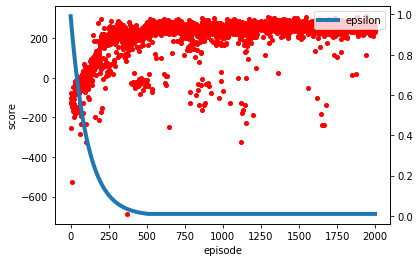

In [12]:
plt.xlabel("episode")
plt.ylabel('score')
plt.plot(scores,'ro',markersize = 4)
plt.twinx()
plt.plot(epsilon_his, label= 'epsilon',linewidth=4)
plt.legend(loc='best')
plt.show()

In [14]:
i = 10
while i > 0:
    i -= 1
    state = env.reset()
    score = 0
    while 1:
        env.render()
        state, reward, done, _ = env.step(agent.action(state))
        score+= reward
        if done:
            env.close()
            break
    print(score)

271.9323236666935
248.50644942754874
267.06851561464754
279.4790908537119
247.97025085448854
-71.71311193789678
107.05244868194788
266.829040289344
274.3321016624041
274.0199291769624
